# **Importando as libs**

In [779]:
pip install wordcloud xlsxwriter openai jupyter_contrib_nbextensions


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.5/23.5 MB 17.8 MB/s eta 0:00:00m eta 0:00:010:01:01
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 466.9/466.9 kB 14.2 MB/s eta 0:00:00


  Created wheel for jupyter_contrib_nbextensions: filename=jupyter_contrib_nbextensions-0.7.0-py2.py3-none-any.whl size=23428784 sha256=31ef483ea20f331e22f1fb4e6f0506c16a14340de7218e52ced1d6746f59f0e8
  Stored in directory: /home/pimentel/.cache/pip/wheels/44/a7/44/406684ced6e1131cbfce3391ab8508a39857e215c5498c4e6b
  Created wheel for jupyter_contrib_core: filename=jupyter_contrib_core-0.4.2-py2.py3-none-any.whl size=17483 sha256=10f3875411ecc47fc11396165c3f34a0cffa5405ff2716f171398f06d3fdc34d
  Stored in directory: /home/pimentel/.cache/pip/wheels/22/48/07/905faed53d1593772d705f08a979f218f8a6caa91f186895e4
Successfully built jupyter_contrib_nbextensions jupyter_contrib_core
Note: you may need to restart the kernel to use updated packages.


In [707]:
import requests
import json
import pandas as pd
import numpy as np
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from datetime import datetime
import time
import plotly.graph_objs as go
import xlsxwriter
import plotly.subplots as sp
import openai
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC

# **APIs**

In [4]:
owner = 'openai'

In [5]:
# Define o nome de usuário e a chave de acesso
access_token = 'sua_chave'

# Define os cabeçalhos de autenticação
headers = {'Authorization': f'token {access_token}'}

 # Define a URL base da API do GitHub
url_rate_limit = 'https://api.github.com/rate_limit'
url = 'https://api.github.com/search/repositories?q=user:{}&sort=stars&order=desc&per_page=10&page='
url_commits = 'https://api.github.com/repos/{}/{}/commits'
url_pr = 'https://api.github.com/repos/{}/{}/pulls?state=all&sort=updated&direction=desc'
url_issues = 'https://api.github.com/repos/{}/{}/issues'
url_release = 'https://api.github.com/repos/{}/{}/releases'
url_pull_files = 'https://api.github.com/repos/{}/{}/pulls/{}/files'
url_commits_coments = 'https://api.github.com/repos/{}/{}/comments'
url_issues_coments = 'https://api.github.com/repos/{}/{}/issues/comments'
url_pull_commit = 'https://api.github.com/repos/{}/{}/commits/{}/pulls'
url_pull_state = 'https://api.github.com/repos/{}/{}/pulls/{}'
url_branches = 'https://api.github.com/repos/{}/{}/branches'

In [671]:
openai.organization = 'sua_organização'
openai.api_key = 'sua_chave'

## Requests

In [14]:
response = requests.get(url_rate_limit, headers=headers)
if response.status_code == 200:
    data = response.json()

    limit = data['rate']['limit']
    remaining = data['rate']['remaining']
    reset_timestamp = data['rate']['reset']

    print(f'Limite de requisições: {limit}')
    print(f'Requisições restantes: {remaining}')

else:
    print('Falha ao obter as informações de consumo da API do GitHub')

current_timestamp = int(time.time())
time_remaining = (reset_timestamp - current_timestamp)/60
if time_remaining > 0:
    print(f'Você precisa esperar {round(time_remaining)} minutos para reiniciar o limite de requisições.')
else:
    print('O limite de requisições já foi reiniciado. Você pode fazer novas requisições agora.')

Limite de requisições: 5000
Requisições restantes: 3288
Você precisa esperar 42 minutos para reiniciar o limite de requisições.


# **Extração**

## **Extraindo os Repos que iremos manipular**

In [7]:
repos = []

for page in range(1,2):
    response = requests.get(url.format(owner) + str(page), headers=headers)
    data = json.loads(response.text)
    repos += data ['items']


# Ordenar os repositórios pelo número de estrelas em ordem decrescente
for indice in range (0,10):
    repos_sorted = sorted(repos, key=lambda x: x['stargazers_count'], reverse=True)

whisper 35453 Python
openai-cookbook 33866 Jupyter Notebook
gym 31196 Python
gpt-2 18970 Python
chatgpt-retrieval-plugin 15871 Python
gpt-3 15006 None
CLIP 14773 Jupyter Notebook
baselines 14327 Python
DALL-E 10226 Python
evals 9213 Python


In [8]:
repos = []
for repo in repos_sorted:
    name = repo['name'] 
    star = repo['stargazers_count']
    language = repo['language']
    fork = repo['forks_count']
    watching = repo['watchers_count']
    issues = repo['open_issues_count']
    created_at = repo['created_at']
    
    repo ={
        'repo': name,
        'star': star,
        'language': language,
        'fork':fork,
        'watching': watching,
        'issues': issues,
        'created_at': created_at
    }
    repos.append(repo)
        
df_repo = pd.DataFrame(repos)

In [9]:
df_repo

repo   star          language  fork  watching  issues  \
0                   whisper  35453            Python  3899     35453      18   
1           openai-cookbook  33866  Jupyter Notebook  4994     33866      97   
2                       gym  31196            Python  8390     31196      53   
3                     gpt-2  18970            Python  4837     18970     149   
4  chatgpt-retrieval-plugin  15871            Python  2388     15871     130   
5                     gpt-3  15006              None  2142     15006       3   
6                      CLIP  14773  Jupyter Notebook  2221     14773     140   
7                 baselines  14327            Python  4648     14327     493   
8                    DALL-E  10226            Python  1885     10226      65   
9                     evals   9213            Python  1725      9213     548   

             created_at  
0  2022-09-16T20:02:54Z  
1  2022-03-11T02:08:53Z  
2  2016-04-27T14:59:16Z  
3  2019-02-11T04:21:59Z  
4  2023-03-23T06:06:22Z  
5  2020-05-18T08:03:50Z  
6  2020-12-16T11:24:42Z  
7  2017-05-24T01:58:13Z  
8  2021-02-23T23:01:11Z  
9  2023-01-23T20:51:04Z

## **Extração dos commits** 

In [10]:
commits = []

for repo in repos_sorted:
    name = repo['name']
    page = 1

    while True:
        response_cl = requests.get(url_commits.format(owner, name) + '?per_page=100&page=' + str(page), headers=headers)

        if response_cl.status_code == 200:
            data_cl = json.loads(response_cl.text)

            if not data_cl:
                break

            for item in data_cl:
                commit = {
                    'repo': name,
                    'sha': item ['sha'],
                    'author': item['commit']['author']['name'],
                    'e-mail': item['commit']['author']['email'],
                    'created_at': item['commit']['author']['date'],
                    'message': item['commit']['message'],
                    'comment_count': item['commit']['comment_count']
                }
                commits.append(commit)
        page += 1

    else:
        break

df_commit = pd.DataFrame(commits)

In [11]:
pulls_commits = []

for index, row in df_commit.iterrows():
    name = row['repo']
    sha = row['sha']
    
    response_pc = requests.get(url_pull_commit.format(owner, name, sha), headers=headers)
    data_pc = json.loads(response_pc.text)

    
    if not data_pc:
        pull_commit = {
            'repo': name,
            'sha': sha,
            'title': None,
            'description': None,
            'pull_number': None,
            'state': None
        }
    else:
        for item in data_pc:
            pull_commit = {
                'repo': name,
                'sha': sha,
                'title': item['title'],
                'description': item['body'],
                'pull_number': item['number'],
                'state': item['state']
            }
            pulls_commits.append(pull_commit)

df_pulls_commits = pd.DataFrame(pulls_commits)

In [15]:
commits_detalhado = []

for index, row in df_commit.iterrows():
    name = row['repo']
    sha = row['sha']

    response_cd = requests.get(url_commits.format(owner, name) +'/{}'.format(sha), headers=headers)

    if response_cd.status_code == 200:
        data_cd = json.loads(response_cd.text)

        additions = data_cd.get("stats", {}).get("additions")
        deletions = data_cd.get("stats", {}).get("deletions")
        changes = data_cd.get("stats", {}).get("total")

        commit_detalhado = {
            'repo': name,
            'sha': sha,
            'changes': changes,
            'additions': additions,
            'deletions': deletions
        }
        commits_detalhado.append(commit_detalhado)

df_commit_detalhado = pd.DataFrame(commits_detalhado)

In [16]:
commits_status = []

for index, row in df_commit.iterrows():
    name = row['repo']
    sha = row['sha']

    response_st = requests.get(url_commits.format(owner, name) +'/{}'.format(sha), headers=headers)

    if response_st.status_code == 200:
        data_st = json.loads(response_st.text)
        
        state = data_cd.get("state")

        status = {
            'repo': name,
            'sha': sha,
            'status': state
        }
        commits_status.append(status)

df_commit_status = pd.DataFrame(commits_status)

### **Ajuste dos dados**

In [17]:
df_commit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2984 entries, 0 to 2983
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   repo           2984 non-null   object
 1   sha            2984 non-null   object
 2   author         2984 non-null   object
 3   e-mail         2984 non-null   object
 4   created_at     2984 non-null   object
 5   message        2984 non-null   object
 6   comment_count  2984 non-null   int64 
dtypes: int64(1), object(6)
memory usage: 163.3+ KB


In [18]:
df_commit_detalhado.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2984 entries, 0 to 2983
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   repo       2984 non-null   object
 1   sha        2984 non-null   object
 2   changes    2984 non-null   int64 
 3   additions  2984 non-null   int64 
 4   deletions  2984 non-null   int64 
dtypes: int64(3), object(2)
memory usage: 116.7+ KB


In [19]:
df_commit_status.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2984 entries, 0 to 2983
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   repo    2984 non-null   object
 1   sha     2984 non-null   object
 2   status  0 non-null      object
dtypes: object(3)
memory usage: 70.1+ KB


In [20]:
df_commit_merged = pd.merge(df_commit, df_commit_detalhado, on=['repo','sha'], how='outer')
df_commit_merged = pd.merge(df_commit_merged, df_commit_status, on=['repo','sha'], how='outer')

In [21]:
df_commit_merged['changes'] = df_commit_merged['changes'].fillna(0)
df_commit_merged['additions'] = df_commit_merged['additions'].fillna(0)
df_commit_merged['deletions'] = df_commit_merged['deletions'].fillna(0)

df_commit_merged['changes'] = df_commit_merged['changes'].astype(int)
df_commit_merged['additions'] = df_commit_merged['additions'].astype(int)
df_commit_merged['deletions'] = df_commit_merged['deletions'].astype(int)
df_commit_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2984 entries, 0 to 2983
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   repo           2984 non-null   object
 1   sha            2984 non-null   object
 2   author         2984 non-null   object
 3   e-mail         2984 non-null   object
 4   created_at     2984 non-null   object
 5   message        2984 non-null   object
 6   comment_count  2984 non-null   int64 
 7   changes        2984 non-null   int64 
 8   additions      2984 non-null   int64 
 9   deletions      2984 non-null   int64 
 10  status         0 non-null      object
dtypes: int64(4), object(7)
memory usage: 279.8+ KB


In [22]:
df_pulls_commits['pull_number']= df_pulls_commits['pull_number'].astype(str)
df_pulls_commits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2055 entries, 0 to 2054
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   repo         2055 non-null   object
 1   sha          2055 non-null   object
 2   title        2055 non-null   object
 3   description  1840 non-null   object
 4   pull_number  2055 non-null   object
 5   state        2055 non-null   object
dtypes: object(6)
memory usage: 96.5+ KB


In [23]:
df_commit_merged = pd.merge(df_commit_merged, df_pulls_commits, on=['repo','sha'],how='outer')
df_commit_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2984 entries, 0 to 2983
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   repo           2984 non-null   object
 1   sha            2984 non-null   object
 2   author         2984 non-null   object
 3   e-mail         2984 non-null   object
 4   created_at     2984 non-null   object
 5   message        2984 non-null   object
 6   comment_count  2984 non-null   int64 
 7   changes        2984 non-null   int64 
 8   additions      2984 non-null   int64 
 9   deletions      2984 non-null   int64 
 10  status         0 non-null      object
 11  title          2055 non-null   object
 12  description    1840 non-null   object
 13  pull_number    2055 non-null   object
 14  state          2055 non-null   object
dtypes: int64(4), object(11)
memory usage: 373.0+ KB


In [24]:
df_commit_merged['created_at']= pd.to_datetime(df_commit_merged['created_at'])
df_commit_merged['pull_number']= df_commit_merged['pull_number'].fillna('Sem PR')
df_commit_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2984 entries, 0 to 2983
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype              
---  ------         --------------  -----              
 0   repo           2984 non-null   object             
 1   sha            2984 non-null   object             
 2   author         2984 non-null   object             
 3   e-mail         2984 non-null   object             
 4   created_at     2984 non-null   datetime64[ns, UTC]
 5   message        2984 non-null   object             
 6   comment_count  2984 non-null   int64              
 7   changes        2984 non-null   int64              
 8   additions      2984 non-null   int64              
 9   deletions      2984 non-null   int64              
 10  status         0 non-null      object             
 11  title          2055 non-null   object             
 12  description    1840 non-null   object             
 13  pull_number    2984 non-null   object           

In [25]:
df_commit_merged.describe()

comment_count        changes      additions      deletions
count    2984.000000    2984.000000    2984.000000    2984.000000
mean        0.062668     556.834450     394.443365     162.391086
std         0.497153    6233.171351    4540.867362    3205.379486
min         0.000000       0.000000       0.000000       0.000000
25%         0.000000       3.000000       1.000000       1.000000
50%         0.000000       8.000000       5.000000       2.000000
75%         0.000000      40.250000      24.000000       8.000000
max        16.000000  200697.000000  125581.000000  136958.000000

In [26]:
df_commit_merged=df_commit_merged.sort_values('comment_count', ascending=False)
df_commit_merged.head()

repo                                       sha           author  \
65    whisper  4179ed2475cc84cba66868b516232ef1b74dacdf    Jong Wook Kim   
2966    evals  a7fe8e0ac5c4e2b71975bef5db10d73f64996b0f  Andrew Kondrich   
2001      gym  58e6aa95e5af2c738557431f812abb81c505a7cf    Greg Brockman   
604       gym  f2aeb823f703549f428b5fea90e28b516a2aa10d      Omar Younis   
2052      gym  751dcc15b10cc45122486e5238626c160b51e752         Jie Tang   

                                                e-mail  \
65                                    jongwook@nyu.edu   
2966  120423412+andrew-openai@users.noreply.github.com   
2001                              gdb@gregbrockman.com   
604           42100908+younik@users.noreply.github.com   
2052                                jietang@openai.com   

                    created_at  \
65   2022-12-05 16:07:14+00:00   
2966 2023-03-14 23:59:17+00:00   
2001 2016-05-29 16:07:09+00:00   
604  2022-06-16 16:29:44+00:00   
2052 2016-05-15 22:59:02+00:00   

                                                message  comment_count  \
65    add large-v2 model\n\n- The "large-v2" model i...             16   
2966  Merge pull request #68 from openai/logankilpat...              8   
2001  [WIP] add support for seeding environments (#1...              8   
604                   check render_mode in make (#2896)              6   
2052  Add close() to Env, add functionality to call ...              5   

      changes  additions  deletions status  \
65          4          3          1   None   
2966       16         14          2   None   
2001      996        711        285   None   
604        21          8         13   None   
2052       63         63          0   None   

                                                  title  \
65                                                  NaN   
2966  Update PULL_REQUEST_TEMPLATE.md and add eval c...   
2001         [WIP] add support for seeding environments   
604                    Pitch: Check render_mode in make   
2052                                                NaN   

                                            description pull_number   state  
65                                                  NaN      Sem PR     NaN  
2966                                               None          68  closed  
2001                                                            135  closed  
604   # Description\r\n\r\nCurrently, every environm...        2896  closed  
2052                                                NaN      Sem PR     NaN

### Manipulação

In [27]:
data_commits = []
for repo in repos_sorted:
    name = repo['name']
    datas = pd.to_datetime(df_commit_merged[(df_commit_merged.repo==name)]['created_at']).dt.date.unique() 
    for data in datas:
        data_commit = {
            'repo': name, 
            'created_at': data,
            'commits': df_commit_merged[(df_commit_merged.created_at.dt.date==data) & (df_commit_merged.repo==name)]['sha'].nunique(),
            'changes': df_commit_merged[(df_commit_merged.created_at.dt.date==data) & (df_commit_merged.repo==name)]['changes'].sum(),
        }
        data_commits.append(data_commit)
        
df_data_commit = pd.DataFrame(data_commits)

### Calculos

Razão entre commits sem PR e PR total

In [28]:
df_commit_merged[df_commit_merged.pull_number=='Sem PR']['pull_number'].count()/df_commit_merged['pull_number'].count()

0.3113270777479893

Média de commits por PR

In [29]:
df_commit_merged['sha'].nunique()/df_commit_merged['pull_number'].nunique()

2.2503770739064857

PR com 1 commit

In [30]:
df_duplicate = pd.DataFrame(df_commit_merged['pull_number'], columns=['pull_number'])
df_duplicate['commits_qty'] = df_duplicate.groupby('pull_number')['pull_number'].transform('count')
df_duplicate = df_duplicate.drop_duplicates()

In [31]:
commit_unico = df_duplicate[(df_duplicate['commits_qty']==1)]['pull_number'].count()
total= df_duplicate[(df_duplicate['pull_number']!='Sem PR')]['commits_qty'].sum()
commit_unico_perc = commit_unico/total
commit_unico_perc

0.5090024330900244

PR com 5 ou mais commits

In [32]:
commit_maior = df_duplicate[(df_duplicate['commits_qty']>=5)]['pull_number'].count()
commit_maior_perc = commit_maior/total
commit_maior_perc

0.028223844282238442

### Graficos

In [33]:
# Converter a coluna de data para um objeto datetime
df_data_commit['created_at'] = pd.to_datetime(df_data_commit['created_at'])

# Obter a lista de repositórios únicos
repos = df_data_commit['repo'].unique()

# Criar uma lista de traços para cada repositório
data = []
for repo in repos:
    # Filtrar o dataframe para o repositório selecionado
    filtered_df = df_data_commit[df_data_commit['repo'] == repo]
    
    # Agrupar os dados por data e contar o número de ocorrências de commits em cada data
    sum_by_date = filtered_df.resample('M', on='created_at')['commits'].sum().reset_index(name='sum')

    # Criar um traço para o repositório atual
    trace = go.Bar(x=sum_by_date['created_at'], y=sum_by_date['sum'], name=repo)
    data.append(trace)

# Definir o layout do gráfico
layout = go.Layout(
    title='Commits por data',
    xaxis=dict(title='Data'),
    yaxis=dict(title='Número de commits'),
    barmode='stack'
)

# Criar a figura com os traços e o layout
fig = go.Figure(data=data, layout=layout)

# Exibir o gráfico
fig.show()

## **Extraindo as Branches**

In [34]:
branches = []

for repo in repos_sorted:
    name = repo['name']
    page = 1

    while True:
        response_br = requests.get(url_branches.format(owner, name) + '?per_page=100&page=' + str(page), headers=headers)

        if response_br.status_code == 200:
            data_br = json.loads(response_br.text)

            if not data_br:
                break

            for item in data_br:
                branch = {
                    'repo': name,
                    'branch_name': item['name'],
                    'protected': item['protected'],
                    'sha_branch': item['commit']['sha']
                }
                branches.append(branch)
        page += 1

    else:
        break

df_branches = pd.DataFrame(branches)

In [35]:
branches = []
for repo in repos_sorted:
    name = repo['name'] 
    branch ={
        'repo': name,
        'branch': df_branches[(df_branches.repo==name)]['branch_name'].count()
    }
    branches.append(branch)
        
df_branch = pd.DataFrame(branches)
df_branch

repo  branch
0                   whisper       5
1           openai-cookbook      39
2                       gym     124
3                     gpt-2       3
4  chatgpt-retrieval-plugin       3
5                     gpt-3       1
6                      CLIP       2
7                 baselines      36
8                    DALL-E       1
9                     evals      47

### **Ajuste dos dados**

In [36]:
df_branches.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 261 entries, 0 to 260
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   repo         261 non-null    object
 1   branch_name  261 non-null    object
 2   protected    261 non-null    bool  
 3   sha_branch   261 non-null    object
dtypes: bool(1), object(3)
memory usage: 6.5+ KB


## Work Breakdown

In [37]:
work_breakdown = []
for repo in repos_sorted:
    name = repo['name']
    datas = pd.to_datetime(df_commit_merged[(df_commit_merged.repo==name)]['created_at']).dt.date.unique() 
    for data in datas:
        mask = df_commit_merged ['message'].str.contains('refactor', case = False, na = False)
        refactor = df_commit_merged[(df_commit_merged.created_at.dt.date == data) & (mask) & (df_commit_merged.repo == name)]['changes']
        new_code = df_commit_merged[(df_commit_merged.created_at.dt.date == data) & (~mask)& (df_commit_merged.additions == df_commit_merged.changes) & (df_commit_merged.repo == name)]['additions']
        total_changes = df_commit_merged[(df_commit_merged.created_at.dt.date == data) & (df_commit_merged.repo == name)]['changes']
        total_rr = df_commit_merged[(df_commit_merged.created_at.dt.date == data) & (df_commit_merged.deletions != 0) & (df_commit_merged.repo == name)]['changes']
        
        breakdown = {
            'repo': name, 
            'created_at': data,
            'new_code': new_code.sum(),
            'total_refactor_rework': total_rr.sum(),
            'refactoring': refactor.sum(),
            'total_changes':total_changes.sum()
        }
        work_breakdown.append(breakdown)
        
df_work_breakdown = pd.DataFrame(work_breakdown)

### Ajuste de dados

In [38]:
df_work_breakdown['created_at'] = pd.to_datetime(df_work_breakdown['created_at'])
df_work_breakdown['rework']= df_work_breakdown['total_refactor_rework'] - df_work_breakdown['refactoring']
df_work_breakdown = df_work_breakdown[['repo', 'created_at', 'new_code', 'rework', 'refactoring', 'total_changes']]
df_work_breakdown['check']= df_work_breakdown['total_changes'] - df_work_breakdown['refactoring']- df_work_breakdown['rework']- df_work_breakdown['new_code']

In [39]:
df_work_breakdown[(df_work_breakdown.check != 0)]

repo created_at  new_code  rework  refactoring  total_changes  check
454        gym 2022-02-11         0      21         1430           1454      3
593        gym 2018-02-09         0     -42           48             52     46
841  baselines 2018-09-30         0      -3            3              3      3

In [40]:
df_work_breakdown.loc[449, ['rework']] = [24]
df_work_breakdown.loc[590, ['rework']] = [4]
df_work_breakdown.loc[837, ['rework']] = [0]
df_work_breakdown.drop('check',axis=1,inplace=True)
df_work_breakdown['check']= df_work_breakdown['total_changes'] - df_work_breakdown['refactoring']- df_work_breakdown['rework']- df_work_breakdown['new_code']
df_work_breakdown[(df_work_breakdown.check != 0)]

repo created_at  new_code  rework  refactoring  total_changes  check
449        gym 2022-04-24         0      24            0            244    220
454        gym 2022-02-11         0      21         1430           1454      3
590        gym 2018-01-29         0       4            0              2     -2
593        gym 2018-02-09         0     -42           48             52     46
837  baselines 2018-09-06         2       0           93            308    213
841  baselines 2018-09-30         0      -3            3              3      3

In [41]:
df_work_breakdown.drop('check',axis=1,inplace=True)
df_work_breakdown

repo created_at  new_code  rework  refactoring  total_changes
0     whisper 2022-12-05         0       4            0              4
1     whisper 2023-01-27         0       2            0              2
2     whisper 2023-03-29         0       3            0              3
3     whisper 2022-09-30         0      74            0             74
4     whisper 2022-11-15         0      12            0             12
...       ...        ...       ...     ...          ...            ...
1030    evals 2023-04-04        17       0          529            546
1031    evals 2023-03-29        86      74            0            160
1032    evals 2023-04-12       238      27            0            265
1033    evals 2023-04-14        59       8            0             67
1034    evals 2023-04-13        22       4            0             26

[1035 rows x 6 columns]

### Gráfico

In [320]:
# Agrupar os dados por tipo de alteração e somar as quantidades
grouped = df_work_breakdown.groupby(['repo'])['new_code','refactoring', 'rework'].sum()

# Extrair as quantidades de cada tipo de alteração
new_code = grouped['new_code'].sum()
refactoring = grouped['refactoring'].sum()
rework = grouped['rework'].sum()

# Criar o gráfico de pizza
labels = ['New Code', 'Refactoring', 'Rework']
values = [new_code, refactoring, rework]

fig = go.Figure(data=[go.Pie(labels=labels, values=values)])

# Adicionar título ao gráfico
fig.update_layout(title='Alterações por tipo')

# Exibir o gráfico
fig.show()


/tmp/ipykernel_4222/4261458560.py:2: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.



In [319]:
# Definir o número de linhas e colunas dos subplots
n_rows = 1
n_cols = 3

# Criar uma lista com os anos
selected_year = [2021, 2022, 2023]

# Criar um subplot para cada repositório selecionado
fig = sp.make_subplots(rows=n_rows, cols=n_cols, 
                       specs=[[{'type':'domain'} for _ in range(n_cols)] for _ in range(n_rows)],
                       subplot_titles=[str(year) for year in selected_year], 
                       horizontal_spacing=0.1)


for i, ano in enumerate(selected_year):
    # Filtrar o dataframe para o ano
    df_work_breakdown_year = df_work_breakdown[df_work_breakdown['created_at'].dt.year == ano]

    # Agrupar os dados por tipo de alteração e somar as quantidades
    grouped = df_work_breakdown_year.groupby('repo').sum()

    # Extrair as quantidades de cada tipo de alteração
    new_code = grouped['new_code'].sum()
    refactoring = grouped['refactoring'].sum()
    rework = grouped['rework'].sum()
    
    # Criar o gráfico de pizza
    labels = ['New Code', 'Refactoring', 'Rework']
    values = [new_code, refactoring, rework]
    
    # Add trace to the subplot
    fig.add_trace(go.Pie(labels=labels, values=values, name=str(ano)), i // n_cols + 1, i % n_cols + 1)

# Atualizar layout
fig.update_layout(height=400, width=950, title_text="Alterações por tipo nos anos")
fig.show()


/tmp/ipykernel_4222/4037009571.py:20: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.

/tmp/ipykernel_4222/4037009571.py:20: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.

/tmp/ipykernel_4222/4037009571.py:20: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.



In [318]:
# Filtrar o dataframe para o ano de 2023
df_work_breakdown_2023 = df_work_breakdown[df_work_breakdown['created_at'].dt.year == 2023]
df_work_breakdown_2023 = df_work_breakdown_2023[df_work_breakdown_2023['created_at'].dt.month == 4]

# Agrupar os dados por tipo de alteração e somar as quantidades
grouped = df_work_breakdown_2023.groupby(['repo'])['new_code','refactoring', 'rework'].sum()

# Extrair as quantidades de cada tipo de alteração
new_code = grouped['new_code'].sum()
refactoring = grouped['refactoring'].sum()
rework = grouped['rework'].sum()

# Criar o gráfico de pizza
labels = ['New Code', 'Refactoring', 'Rework']
values = [new_code, refactoring, rework]

fig = go.Figure(data=[go.Pie(labels=labels, values=values)])

# Adicionar título ao gráfico
fig.update_layout(title='Alterações por tipo em Abril de 2023')

# Exibir o gráfico
fig.show()

/tmp/ipykernel_4222/1490343857.py:6: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.



In [316]:
n_cols = 2
valid_repos = []

# Filtrar o dataframe para o mês 4 de 2023
df_work_breakdown_2023_April = df_work_breakdown[(df_work_breakdown['created_at'].dt.year == 2023) & 
                                                  (df_work_breakdown['created_at'].dt.month == 4)]

# Agrupar os dados por tipo de alteração e somar as quantidades
grouped = df_work_breakdown_2023_April.groupby('repo').sum()

# Primeira iteração para obter os repositórios válidos
for repo in df_work_breakdown['repo'].unique():
    if repo in grouped.index:
        repo_data = grouped.loc[repo]
        new_code = repo_data['new_code']
        refactoring = repo_data['refactoring']
        rework = repo_data['rework']
        
        if new_code != 0 or refactoring != 0 or rework != 0:
            valid_repos.append(repo)

n_repos = len(valid_repos)
n_rows = (n_repos + n_cols - 1) // n_cols

# Criar um subplot para cada repositório válido
fig = sp.make_subplots(rows=n_rows, cols=n_cols, 
                       specs=[[{'type':'domain'} for _ in range(n_cols)] for _ in range(n_rows)],
                       subplot_titles=valid_repos, 
                       horizontal_spacing=0.1)

# Segunda iteração para criar os gráficos
for i, repo in enumerate(valid_repos):
    repo_data = grouped.loc[repo]
    new_code = repo_data['new_code']
    refactoring = repo_data['refactoring']
    rework = repo_data['rework']

    labels = ['New Code', 'Refactoring', 'Rework']
    values = [new_code, refactoring, rework]
    
    fig.add_trace(go.Pie(labels=labels, values=values, name=repo), i // n_cols + 1, i % n_cols + 1)

fig.update_layout(height=400 * n_rows, width=950, title_text="Alterações por tipo e repo em Abril de 2023")
fig.show()



/tmp/ipykernel_4222/4239733056.py:9: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.



## **Extração dos Contributors**

In [45]:
contributors = []
for repo in repos_sorted:
    name = repo['name']
    authors = df_commit_merged[(df_commit_merged.repo==name)]['author'].unique() 
    for author in authors:
        contributor = {
            'repo': name, 
            'contributor': author,
            'commits': df_commit_merged[(df_commit_merged.author==author)& (df_commit_merged.repo==name)]['sha'].nunique(),
            'changes': df_commit_merged[(df_commit_merged.author==author)& (df_commit_merged.repo==name)]['changes'].sum(),
            'pull_request': df_commit_merged[(df_commit_merged.author==author)& (df_commit_merged.repo==name)]['pull_number'].nunique()
        }
        contributors.append(contributor)
        
df_contributor = pd.DataFrame(contributors)

### Ajuste de dados

In [46]:
df_contributor_repos = df_contributor.sort_values('changes', ascending=False)[0:54]

In [47]:
df_contributor_count = df_contributor.groupby('repo')['contributor'].nunique()
df_contributor_count

repo
CLIP                         19
DALL-E                        1
baselines                   117
chatgpt-retrieval-plugin     24
evals                       110
gpt-2                        16
gpt-3                         5
gym                         399
openai-cookbook              76
whisper                      54
Name: contributor, dtype: int64

In [144]:
df_contributor_repo_count = df_contributor_repos.groupby('repo')['contributor'].nunique()
df_contributor_repo_count

repo
CLIP                         1
baselines                    6
chatgpt-retrieval-plugin     1
evals                        2
gpt-2                        1
gpt-3                        1
gym                         28
openai-cookbook             13
whisper                      1
Name: contributor, dtype: int64

In [49]:
df_contributor_repo = df_contributor_repos.groupby('contributor')['repo'].count()
df_contributor_repo

contributor
20chase                          1
Andrew Kondrich                  1
Anton Troynikov                  1
Ariel Kwiatkowski                1
Arjun KG                         1
Arushi Raghuvanshi               1
Benjamin Mann                    1
Boris Power                      1
Christian Clauss                 1
Colin                            1
Colin Jarvis                     1
Filip Haltmayer                  1
Filipe de Avila Belbute Peres    1
Gianluca De Cola                 1
Greg Brockman                    1
J K Terry                        1
James Briggs                     1
Jeff Wu                          1
Jesse Farebrother                1
Jie Tang                         1
John Balis                       1
John Schulman                    2
Jong Wook Kim                    2
Justin Terry                     1
Kacper Łukawski                  1
Logan Kilpatrick                 1
Mark Towers                      1
Markus Krimmel                   1
Matthias

### Calculos

Total de usuários

In [50]:
total_user = df_contributor['contributor'].nunique()
total_user

774

In [146]:
50/774

0.06459948320413436

Total de colaboradores

In [51]:
total_contributor = df_contributor['contributor'].count()
total_contributor

821

In [147]:
54/821

0.06577344701583435

Razão entre os commits dos 50 usuários mais ativos e o total de commits

In [52]:
df_contributor = df_contributor.sort_values('changes', ascending=False)
total_commits = df_contributor['commits'].sum() 
top_commits = df_contributor['commits'][0:54].sum() 
top_commits_perc = top_commits/total_commits
top_commits_perc

0.5214477211796247

In [736]:
df_contributor_repo = df_contributor.groupby('repo').agg(
    {'contributor': 'count', 'commits': 'sum', 'changes': 'sum', 'pull_request': 'sum'}
)
df_contributor_repo = df_contributor_repo.reset_index()
df_contributor_repo

repo  contributor  commits  changes  pull_request
0                      CLIP           19       54    14956            26
1                    DALL-E            1        3      503             1
2                 baselines          117      347    89638           218
3  chatgpt-retrieval-plugin           24       70    15894            46
4                     evals          110      192    15006           163
5                     gpt-2           16       57   276366            19
6                     gpt-3            5        8    27569             6
7                       gym          399     1757   196863          1039
8           openai-cookbook           76      381   701840           231
9                   whisper           54      115   322959            81

Razão entre as mudamças de código dos 50 usuários mais ativos e o total de code changes

In [53]:
total_changes = df_contributor['changes'].sum() 
top_changes = df_contributor['changes'][0:54].sum() 
top_changes_perc = top_changes/total_changes
top_changes_perc

0.9647055778968869

Razão entre os PR dos 50 usuários mais ativos e o total de PR

In [54]:
total_pull = df_contributor['pull_request'].sum() 
top_pull = df_contributor['pull_request'][0:54].sum() 
top_pull_perc = top_pull/total_pull
top_pull_perc

0.3841530054644809

In [737]:
df_contributor_repo['commits_norm'] = (df_contributor_repo['commits'] - df_contributor_repo['commits'].min()) / (df_contributor_repo['commits'].max() - df_contributor_repo['commits'].min())
df_contributor_repo['changes_norm'] = (df_contributor_repo['changes'] - df_contributor_repo['changes'].min()) / (df_contributor_repo['changes'].max() - df_contributor_repo['changes'].min())

# Gera alguns dados
x = df_contributor_repo['changes_norm']
y = df_contributor_repo['commits_norm']
names = df_contributor_repo['repo']

x_average = (max(x))/2
y_average = (max(y))/2

# Cria um Scatter plot
fig = go.Figure(data=go.Scatter(
    x=x, 
    y=y, 
    mode='markers',  
    hovertext=names,  # Adiciona rótulos de texto hover
    marker=dict(color='blue', size=5)
))

# Adiciona linhas para criar quadrantes
fig.add_shape(type="line",
    x0=x_average, y0=0, x1=x_average, y1=max(y),
    line=dict(color="Grey",width=1)
)
fig.add_shape(type="line",
    x0=0, y0=y_average, x1=max(x), y1=y_average,
    line=dict(color="Grey",width=1)
)

# Configura o layout
fig.update_layout(showlegend=False,
    xaxis=dict(range=[0, max(x)], zeroline=False, showgrid=False),
    yaxis=dict(range=[0, max(y)], zeroline=False, showgrid=False),
    width=800, height=800,
)

fig.show()


## **Extração dos issues**

### **Extração dos issues**

In [55]:
issues = []

for repo in repos_sorted:
    name = repo['name']
    page = 1

    while True:
        response_il = requests.get(url_issues.format(owner, name) + '?state=all&per_page=100&page=' + str(page), headers=headers)

        if response_il.status_code == 200:
            data_il = json.loads(response_il.text)

            if not data_il:
                break

            for item in data_il:
                issue = {
                    'repo': name,
                    'id': item['id'],
                    'state': item['state'],
                    'comments': item['comments'],
                    'created_at': item['created_at'],
                    'updated_at': item['updated_at'],
                    'closed_at': item['closed_at'],
                    'reactions': item['reactions']['total_count'],
                    'login': item['user']['login'],
                    'title': item['title'],
                    'assignee': item['assignee']['login'] if item['assignee'] else None,
                    'labels': [label['name'] for label in item['labels']],
                    'description': item['body']
                }
                issues.append(issue)
        page += 1

    else:
        break

df_issue = pd.DataFrame(issues)

In [56]:
data_closed_issues=[]
for repo in repos_sorted:
    name = repo['name']
    data_created = pd.to_datetime(df_issue[df_issue['repo'] == name]['created_at']).dt.date
    data_closed = pd.to_datetime(df_issue[df_issue['repo'] == name]['closed_at']).dt.date
    datas = data_created.append(data_closed).drop_duplicates().reset_index(drop=True)

    for data in datas:
        created_count = df_issue[(pd.to_datetime(df_issue['created_at']).dt.date == data) & (df_issue['repo'] == name)]['created_at'].count()
        closed_count = df_issue[(pd.to_datetime(df_issue['closed_at']).dt.date == data) & (df_issue['repo'] == name)]['closed_at'].count()
        
        data_closed_issue = {
            'repo': name, 
            'timeline': str(data),
            'created_count': created_count,
            'closed_count': closed_count
        }
        data_closed_issues.append(data_closed_issue)
        
df_data_closed_issue = pd.DataFrame(data_closed_issues)

/tmp/ipykernel_4222/933096243.py:6: FutureWarning:

The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/tmp/ipykernel_4222/933096243.py:6: FutureWarning:

The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/tmp/ipykernel_4222/933096243.py:6: FutureWarning:

The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/tmp/ipykernel_4222/933096243.py:6: FutureWarning:

The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/tmp/ipykernel_4222/933096243.py:6: FutureWarning:

The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/tmp/ipykernel_4222/933096243.py:6: FutureWarning:

The series.append method is deprecated and will be removed from pandas in a future versi

### Ajuste dos dados

In [57]:
df_issue['created_at'] = pd.to_datetime(df_issue['created_at'])
df_issue['closed_at'] = pd.to_datetime(df_issue['closed_at'])
df_issue['id']= df_issue['id'].astype(str)
df_issue['updated_at']= pd.to_datetime(df_issue['updated_at'])
df_issue.drop('assignee',axis=1,inplace=True)
df_issue.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6830 entries, 0 to 6829
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype              
---  ------       --------------  -----              
 0   repo         6830 non-null   object             
 1   id           6830 non-null   object             
 2   state        6830 non-null   object             
 3   comments     6830 non-null   int64              
 4   created_at   6830 non-null   datetime64[ns, UTC]
 5   updated_at   6830 non-null   datetime64[ns, UTC]
 6   closed_at    5130 non-null   datetime64[ns, UTC]
 7   reactions    6830 non-null   int64              
 8   login        6830 non-null   object             
 9   title        6830 non-null   object             
 10  labels       6830 non-null   object             
 11  description  6551 non-null   object             
dtypes: datetime64[ns, UTC](3), int64(2), object(7)
memory usage: 640.4+ KB


In [58]:
df_issue.describe()

comments    reactions
count  6830.000000  6830.000000
mean      2.368521     0.678624
std       5.086964     7.338794
min       0.000000     0.000000
25%       0.000000     0.000000
50%       1.000000     0.000000
75%       3.000000     0.000000
max     187.000000   402.000000

In [59]:
df_issue=df_issue.sort_values(['reactions','comments'], ascending=False)
df_issue.head()

repo         id   state  comments                created_at  \
4027  gpt-2  410572332    open       179 2019-02-15 02:02:26+00:00   
4545   CLIP  853114174    open       187 2021-04-08 06:30:25+00:00   
1473    gym  954110170  closed        24 2021-07-27 17:33:35+00:00   
3715    gym  151574258  closed       101 2016-04-28 08:07:27+00:00   
3620    gym  155501162  closed        27 2016-05-18 13:28:16+00:00   

                    updated_at                 closed_at  reactions  \
4027 2020-01-01 21:39:50+00:00                       NaT        402   
4545 2023-05-07 13:15:31+00:00                       NaT        286   
1473 2021-08-25 00:02:12+00:00 2021-08-25 00:02:12+00:00        200   
3715 2021-07-30 19:42:46+00:00 2021-07-30 19:42:46+00:00        189   
3620 2021-07-30 19:43:14+00:00 2021-07-30 19:43:13+00:00         88   

            login                                        title      labels  \
4027  superjayman                      Release The Full Model!  [question]   
4545   vinson2233                           CLIP Training Code          []   
1473     jkterry1          Plans for Future Maintenance of Gym          []   
3715     salarian                              Windows support          []   
3620       joschu  Write more documentation about environments          []   

                                            description  
4027  I understand your concerns but I still think i...  
4545  Not really an issue, I just want to share my t...  
1473  So OpenAI made me a maintainer of Gym. This me...  
3715  It would be nice if you could add support for ...  
3620  We should write a more detailed explanation of...

In [60]:
df_data_closed_issue['timeline'] = pd.to_datetime(df_data_closed_issue['timeline'])
df_data_closed_issue['diff'] = df_data_closed_issue['created_count'] - df_data_closed_issue['closed_count']
df_data_closed_issue.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3531 entries, 0 to 3530
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   repo           3531 non-null   object        
 1   timeline       3521 non-null   datetime64[ns]
 2   created_count  3531 non-null   int64         
 3   closed_count   3531 non-null   int64         
 4   diff           3531 non-null   int64         
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 138.1+ KB


In [61]:
df_data_closed_issue.describe()

created_count  closed_count         diff
count    3531.000000   3531.000000  3531.000000
mean        1.934296      1.452846     0.481450
std         3.382121      4.052100     4.652561
min         0.000000      0.000000   -99.000000
25%         1.000000      0.000000     0.000000
50%         1.000000      0.000000     1.000000
75%         2.000000      1.000000     1.000000
max       124.000000    103.000000   115.000000

### Manipulação

In [62]:
sla_issues = []

for index, row in df_issue.iterrows():
    if row['state'] == 'closed':
        name = row['repo']
        issue_id = row['id']
        closed_at = pd.to_datetime(row['closed_at']).tz_localize(None)
        created_at = pd.to_datetime(row['created_at']).tz_localize(None)

        if pd.notnull(created_at) and pd.notnull(closed_at):
            sla = closed_at - created_at
        else:
            sla = None

        sla_issue = {
            'repo': name,
            'id': issue_id,
            'created_at': created_at,
            'closed_at': closed_at,
            'sla': sla
        }
        sla_issues.append(sla_issue)
    else:
        pass
df_sla_issue = pd.DataFrame(sla_issues)

In [620]:
sla_issues_2023 = []

for index, row in df_issue.iterrows():
    if row['state'] == 'closed':
        name = row['repo']
        issue_id = row['id']
        closed_at = pd.to_datetime(row['closed_at']).tz_localize(None)
        created_at = pd.to_datetime(row['created_at']).tz_localize(None) 

        if created_at.year == 2023 and created_at.month == 4 and closed_at.year == 2023 and closed_at.month == 4 and pd.notnull(created_at) and pd.notnull(closed_at):
            sla = closed_at - created_at
            sla_issue = {
                'repo': name,
                'id': issue_id,
                'created_at': created_at,
                'closed_at': closed_at,
                'sla': sla
            }
            sla_issues_2023.append(sla_issue)
    else:
        pass
    
df_sla_issues_2023 = pd.DataFrame(sla_issues_2023)

In [601]:
sla_issues_open_2023 = []

for index, row in df_issue.iterrows():
    name = row['repo']
    issue_id = row['id']
    created_at = pd.to_datetime(row['created_at']).tz_localize(None) 

    if created_at.year == 2023 and created_at.month == 4 and pd.notnull(created_at):
        sla_issue_open = {
            'repo': name,
            'id': issue_id,
            'created_at': created_at,
        }
        sla_issues_open_2023.append(sla_issue_open)
    else:
        pass
    
df_sla_issue_open_2023 = pd.DataFrame(sla_issues_open_2023)

### Cálculos

In [602]:
df_sla_issue.describe()

sla
count                         5130
mean    94 days 09:44:39.295516570
std    230 days 10:26:56.842338676
min                0 days 00:00:03
25%         0 days 10:39:36.750000
50%         5 days 06:34:30.500000
75%        38 days 15:11:54.750000
max             1993 days 19:37:46

In [608]:
df_issue['closed_at'].count()

5130

In [609]:
df_issue['created_at'].count()

6830

In [610]:
df_data_closed_issue_2021 = df_issue[df_issue['created_at'].dt.year == 2021]
df_data_closed_issue_2021['created_at'].count()

708

In [611]:
df_data_closed_issue_2021 = df_data_closed_issue_2021[df_data_closed_issue_2021['closed_at'].dt.year == 2021] 
df_data_closed_issue_2021['closed_at'].count()

555

In [183]:
598/708

0.844632768361582

In [575]:
df_data_closed_issue_2021 = df_issue[df_issue['closed_at'].dt.year == 2021]
df_data_closed_issue_2021['closed_at'].count()

723

In [576]:
df_data_closed_issue_2022 = df_issue[df_issue['created_at'].dt.year == 2022]
df_data_closed_issue_2022['created_at'].count()

912

In [577]:
df_data_closed_issue_2022 = df_data_closed_issue_2022[df_data_closed_issue_2022['closed_at'].dt.year == 2022] 
df_data_closed_issue_2022['closed_at'].count()

744

In [578]:
df_data_closed_issue_2022 = df_issue[df_issue['closed_at'].dt.year == 2022]
df_data_closed_issue_2022['closed_at'].count()

853

In [579]:
df_data_closed_issue_2023 = df_issue[df_issue['created_at'].dt.year == 2023]
df_data_closed_issue_2023['created_at'].count()

1635

In [580]:
df_data_closed_issue_2023 = df_data_closed_issue_2023[df_data_closed_issue_2023['closed_at'].dt.year == 2023] 
df_data_closed_issue_2023['closed_at'].count()

762

In [581]:
df_data_closed_issue_2023 = df_issue[df_issue['closed_at'].dt.year == 2023]
df_data_closed_issue_2023['closed_at'].count()

783

In [622]:
df_data_closed_issue_2023_4 = df_issue[df_issue['created_at'].dt.year == 2023]
df_data_closed_issue_2023_4 = df_data_closed_issue_2023_4[df_data_closed_issue_2023_4['created_at'].dt.month == 4]
df_data_closed_issue_2023_4['created_at'].count()

538

In [624]:
df_data_closed_issue_2023_4 = df_data_closed_issue_2023_4[df_data_closed_issue_2023_4['closed_at'].dt.year == 2023] 
df_data_closed_issue_2023_4 = df_data_closed_issue_2023_4[df_data_closed_issue_2023_4['closed_at'].dt.month == 4]
df_data_closed_issue_2023_4['closed_at'].count()

166

In [625]:
df_sla_issues_2023.describe()

sla
count                        166
mean   2 days 23:46:22.102409638
std    4 days 21:50:15.611131381
min              0 days 00:00:06
25%       0 days 00:10:00.250000
50%       0 days 14:34:20.500000
75%       4 days 14:09:37.500000
max             27 days 07:10:12

In [584]:
df_data_closed_issue_2023_4 = df_issue[df_issue['closed_at'].dt.year == 2023]
df_data_closed_issue_2023_4 = df_data_closed_issue_2023_4[df_data_closed_issue_2023_4['closed_at'].dt.month == 4]
df_data_closed_issue_2023_4['closed_at'].count()

251

In [626]:
df_data_closed_issue_2022_9 = df_issue[df_issue['created_at'].dt.year == 2023]
df_data_closed_issue_2022_9 = df_data_closed_issue_2022_9[df_data_closed_issue_2022_9['created_at'].dt.month == 5]
df_data_closed_issue_2022_9['created_at'].count()

74

In [630]:
df_data_closed_issue_2022_9.sort_values('updated_at').tail()

repo          id state  comments          created_at  \
5943            evals  1696606678  open         2 2023-05-04 19:51:44   
143   openai-cookbook  1699111553  open         0 2023-05-07 15:23:53   
5936            evals  1699118470  open         0 2023-05-07 15:41:46   
5935            evals  1699153890  open         0 2023-05-07 17:12:48   
5934            evals  1699155514  open         0 2023-05-07 17:16:53   

              updated_at closed_at  reactions         login  \
5943 2023-05-07 09:56:19       NaT          0     Naomiball   
143  2023-05-07 15:25:53       NaT          0      sebawita   
5936 2023-05-07 15:42:13       NaT          0     Eynaliyev   
5935 2023-05-07 17:12:48       NaT          0  Omar-HeshamR   
5934 2023-05-07 17:16:53       NaT          0       Lingnik   

                                                  title labels  \
5943               Adding logic argument validity evals     []   
143   Add Generative Search to Weaviate examples + f...     []   
5936                                   docs out of date  [bug]   
5935                               recurrence-relation      []   
5934  Add Eval: Categorize Phishing URL as Phishing URL     []   

                                            description  
5943  # Thank you for contributing an eval! ♥️\r\n\r...  
143                                                None  
5936  ### Describe the bug\r\n\r\ncods at https://gi...  
5935  # Thank you for contributing an eval! ♥️\r\n\r...  
5934  Email address: taylor.meek@gmail.com - My pers...

In [592]:
df_data_closed_issue_2022_9 = df_data_closed_issue_2022_9[df_data_closed_issue_2022_9['closed_at'].dt.year == 2022] 
df_data_closed_issue_2022_9 = df_data_closed_issue_2022_9[df_data_closed_issue_2022_9['closed_at'].dt.month == 12]
df_data_closed_issue_2022_9['closed_at'].count()

13

In [593]:
df_data_closed_issue_2022_9 = df_issue[df_issue['closed_at'].dt.year == 2022]
df_data_closed_issue_2022_9 = df_data_closed_issue_2022_9[df_data_closed_issue_2022_9['closed_at'].dt.month == 12]
df_data_closed_issue_2022_9['closed_at'].count()

25

### Gráficos

In [434]:
# Agrupar os dados por data e contar o número total de commits criados e fechados em cada data
total_by_date = df_data_closed_issue.resample('M', on='timeline')['created_count', 'closed_count'].sum().reset_index()

# Calcular a diferença entre os commits criados e fechados em cada data
diff = total_by_date['created_count'] - total_by_date['closed_count']
cumulative_error = total_by_date['created_count'].cumsum() - total_by_date['closed_count'].cumsum()

# Criar listas de traços para os commits criados, fechados e a diferença
created_data = []
closed_data = []
diff_data = []

# Definir as cores para os commits criados e fechados
created_color = 'rgb(0, 255, 0)'
closed_color = 'rgb(255, 0, 0)'

# Para cada repositório
for repo in repos:
    # Filtrar o dataframe para o repositório selecionado
    filtered_df = df_data_closed_issue[df_data_closed_issue['repo'] == repo]
    
    # Agrupar os dados por data e contar o número de ocorrências de issues criadas e fechadas em cada data
    created_by_date = filtered_df.resample('M', on='timeline')['created_count'].sum().reset_index(name='sum_created')
    closed_by_date = filtered_df.resample('M', on='timeline')['closed_count'].sum().reset_index(name='sum_closed')

    # Definir os valores de y como positivos para os commits criados e negativos para os commits fechados
    created_y = created_by_date['sum_created']
    closed_y = -closed_by_date['sum_closed']

    # Criar traços para os commits criados e fechados
    trace_created = go.Bar(x=created_by_date['timeline'], y=created_y, name=f'{repo} - Issues criados',
                           marker=dict(color=created_color))
    trace_closed = go.Bar(x=closed_by_date['timeline'], y=closed_y, name=f'{repo} - Issues fechados',
                          marker=dict(color=closed_color))

    # Adicionar os traços às listas correspondentes
    created_data.append(trace_created)
    closed_data.append(trace_closed)

# Criar um traço de linha para as diferenças
trace_diff = go.Scatter(x=total_by_date['timeline'], y=cumulative_error, name='Diferença', line=dict(color='black'))
diff_data.append(trace_diff)

# Definir o layout do gráfico
layout = go.Layout(
    title='Issues por data',
    xaxis=dict(title='Data'),
    yaxis=dict(title='Número de Issues'),
    barmode='relative'
)

# Criar a figura com os traços e o layout
fig = go.Figure(data=created_data + closed_data + diff_data, layout=layout)

# Exibir o gráfico
fig.show()


In [427]:
# Converter a coluna de data para um objeto datetime
df_data_closed_issue['timeline'] = pd.to_datetime(df_data_closed_issue['timeline'])
df_data_closed_issue_2023 = df_data_closed_issue[df_data_closed_issue['timeline'].dt.year == 2023] 
df_data_closed_issue_2023 = df_data_closed_issue_2023[df_data_closed_issue_2023['timeline'].dt.month == 4]

# Agrupar os dados por data e contar o número total de commits criados e fechados em cada data
total_by_date = df_data_closed_issue_2023.resample('D', on='timeline')['created_count', 'closed_count'].sum().reset_index()

# Criar listas de traços para os commits criados, fechados e a diferença
created_data = []
closed_data = []
diff_data = []

# Definir as cores para os commits criados e fechados
created_color = 'rgb(0, 255, 0)'
closed_color = 'rgb(255, 0, 0)'

#whisper, openai-cookbook, gym, chatgpt-retrieval-plugin, CLIP, baselines, DALL-E, evals
repo = 'evals'

# Filtrar o dataframe para o repositório selecionado
filtered_df = df_data_closed_issue_2023[df_data_closed_issue_2023['repo'] == repo]

# Calcular a diferença entre os commits criados e fechados em cada data
diff = filtered_df['created_count'] - filtered_df['closed_count']
filtered_df['c_diff']=cumulative_error = filtered_df['created_count'].cumsum() - filtered_df['closed_count'].cumsum()
c_diff = filtered_df['c_diff']
# Definir os valores de y como positivos para os commits criados e negativos para os commits fechados
created_y = filtered_df['created_count']
closed_y = -filtered_df['closed_count']

# Criar traços para os commits criados e fechados
trace_created = go.Bar(x=total_by_date['timeline'], y=created_y, name=f'{repo} - Issues criados',
                       marker=dict(color=created_color))
trace_closed = go.Bar(x=total_by_date['timeline'], y=closed_y, name=f'{repo} - Issues fechados',
                      marker=dict(color=closed_color))

# Adicionar os traços às listas correspondentes
created_data.append(trace_created)
closed_data.append(trace_closed)

# Criar um traço de linha para as diferenças
trace_diff = go.Scatter(x=total_by_date['timeline'], y=c_diff, name='Diferença', line=dict(color='black'), mode='lines+markers+text', text=c_diff, textposition='top center')
diff_data.append(trace_diff)

# Definir o layout do gráfico
layout = go.Layout(
    title={'text':'Número de Issues<br><br>Evals ','y': 0.9, 'x': 0.5, 'xanchor': 'center','yanchor': 'middle'},
    xaxis=dict(title='Data'),
    yaxis=dict(title='Número de Issues'),
    barmode='relative'
)

# Criar a figura com os traços e o layout
fig = go.Figure(data=created_data + closed_data + diff_data, layout=layout)

# Exibir o gráfico
fig.show()

/tmp/ipykernel_4222/963641377.py:26: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [432]:
filtered_df['created_count'].sum()

328

In [433]:
filtered_df['closed_count'].sum()

160

In [245]:
# Definir o número de linhas e colunas dos subplots
n_rows = 2
n_cols = 2

# Criar uma lista com os nomes dos repositórios selecionados
selected_repos = ['chatgpt-retrieval-plugin', 'openai-cookbook', 'CLIP', 'whisper']

# Criar uma lista para armazenar os dados de cada subplot
subplots = []

# Criar um subplot para cada repositório selecionado
for i, repo in enumerate(selected_repos):
    # Filtrar o dataframe para o repositório selecionado
    filtered_df = df_data_closed_issue_2023[df_data_closed_issue_2023['repo'] == repo]

    # Calcular a diferença entre os commits criados e fechados em cada data
    diff = filtered_df['created_count'] - filtered_df['closed_count']
    filtered_df['c_diff']=cumulative_error = filtered_df['created_count'].cumsum() - filtered_df['closed_count'].cumsum()
    c_diff = filtered_df['c_diff']

    # Definir os valores de y como positivos para os commits criados e negativos para os commits fechados
    created_y = filtered_df['created_count']
    closed_y = -filtered_df['closed_count']

    # Criar traços para os commits criados e fechados
    trace_created = go.Bar(x=total_by_date['timeline'], y=created_y, name=f'{repo} - Issues criados',
                           marker=dict(color=created_color))
    trace_closed = go.Bar(x=total_by_date['timeline'], y=closed_y, name=f'{repo} - Issues fechados',
                          marker=dict(color=closed_color))

    # Criar um traço de linha para as diferenças
    trace_diff = go.Scatter(x=total_by_date['timeline'], y=c_diff, name=f'{repo} - Diferença', line=dict(color='black'), 
                            mode='lines+markers+text', text=c_diff, textposition='bottom center', textfont=dict(size=8))

    # Adicionar os traços ao subplot correspondente
    subplot_data = [trace_created, trace_closed, trace_diff]
    subplot = sp.make_subplots(rows=n_rows, cols=n_cols, specs=[[{'secondary_y': True}]*n_cols]*n_rows,
                              subplot_titles=[selected_repos[0], selected_repos[1], selected_repos[2],
                                              selected_repos[3]],
                              vertical_spacing=0.1, horizontal_spacing=0.1)
    for j in range(len(subplot_data)):
        subplot.add_trace(subplot_data[j], row=1 + i // n_cols, col=1 + i % n_cols, secondary_y=(j == 2))

    subplots.append(subplot)

# Definir o layout do gráfico
fig = subplots[0]
for i in range(1, len(subplots)):
    fig.add_traces(subplots[i].data)
    fig.layout.xaxis.update(subplots[i].layout.xaxis)
    fig.layout.yaxis.update(subplots[i].layout.yaxis)
fig.update_layout(
    legend=dict(orientation='h',yanchor='top',y=-0.1,xanchor='right',x=1,font=dict(size=10)),
    margin=dict(t=50),
    width=1000,
    height=800
)
fig.update_layout()

# Exibir o gráfico
fig.show()


/tmp/ipykernel_4222/635087032.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_4222/635087032.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_4222/635087032.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_4222

In [117]:
filtered_df

repo   timeline  created_count  closed_count  diff  c_diff
267   gym 2023-04-20              2             1     1       1
268   gym 2023-04-18              1             0     1       2
269   gym 2023-04-17              1             0     1       3
270   gym 2023-04-16              1             0     1       4
271   gym 2023-04-11              1             1     0       4
272   gym 2023-04-07              1             0     1       5
1843  gym 2023-04-27              0             1    -1       4

## **Extração dos pull requests**

### **Extração dos pulls**

In [73]:
pulls = []

for repo in repos_sorted:
    name = repo['name']
    page = 1

    while True:
        response_pl = requests.get(url_pr.format(owner, name) + 'per_page=100&page=' + str(page), headers=headers)

        if response_pl.status_code == 200:
            data_pl = json.loads(response_pl.text)

            if not data_pl:
                break

            for item in data_pl:
                pull = {
                    'repo': name,
                    'id': item['id'],
                    'number': item['number'],
                    'state': item['state'],
                    'title': item['title'],
                    'created_at': item['created_at'],
                    'updated_at': item['updated_at'],
                    'closed_at': item['closed_at'],
                    'merged_at': item['merged_at'],
                    'merge_commit_sha': item['merge_commit_sha'],
                    'login': item['user']['login'],
                    'assignee': item['assignee']['login'] if item['assignee'] else None,
                    'labels': [label['name'] for label in item['labels']],
                    'description': item['body']
                }
                pulls.append(pull)
        page += 1

    else:
        break

df_pull = pd.DataFrame(pulls)

In [74]:
pulls_states = []
for index, row in df_pull.iterrows():
    name = row['repo']
    number = row['number']

    response_ps = requests.get(url_pull_state.format(owner, name,number), headers=headers)

    if response_ps.status_code == 200:
        data_ps = json.loads(response_ps.text)

        merged = data_ps.get('merged')
        mergeable_state = data_ps.get('mergeable_state')
        commits = data_ps.get('commits')
        additions = data_ps.get('additions')
        deletions = data_ps.get('deletions')
        changed_files = data_ps.get('changed_files')
        review_comments = data_ps.get('review_comments')

        pull_state = {
            'repo': name,
            'number': number,
            'merged': merged,
            'mergeable_state': mergeable_state,
            'commits': commits,
            'additions': additions,
            'deletions': deletions,
            'changed_files': changed_files,
            'review_comments':review_comments
        }
        pulls_states.append(pull_state)

    else:
        break

df_pulls_states = pd.DataFrame(pulls_states)

In [75]:
reveiws = []
for index, row in df_pull.iterrows():
    name = row['repo']
    number = row['number']

    response_rv = requests.get(url_pull_state.format(owner, name,number)+'/reviews', headers=headers)

    if response_rv.status_code == 200:
        data_rv = json.loads(response_rv.text)

        if data_rv:
            reveiw = {
                    'repo': name,
                    'pull_number':number,
                    'first_review_date': data_rv[0]['submitted_at']
            }
            reveiws.append(reveiw)

df_reveiw = pd.DataFrame(reveiws)

### **Ajuste dos dados**

In [76]:
df_pull_request = pd.merge(df_pull, df_pulls_states, on=['number','repo'])
df_pull_request.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3167 entries, 0 to 3166
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   repo              3167 non-null   object
 1   id                3167 non-null   int64 
 2   number            3167 non-null   int64 
 3   state             3167 non-null   object
 4   title             3167 non-null   object
 5   created_at        3167 non-null   object
 6   updated_at        3167 non-null   object
 7   closed_at         2437 non-null   object
 8   merged_at         1631 non-null   object
 9   merge_commit_sha  3134 non-null   object
 10  login             3167 non-null   object
 11  assignee          36 non-null     object
 12  labels            3167 non-null   object
 13  description       2945 non-null   object
 14  merged            3167 non-null   bool  
 15  mergeable_state   3167 non-null   object
 16  commits           3167 non-null   int64 
 17  additions     

In [77]:
df_pull_request['id']= df_pull_request['id'].astype(str)
df_pull_request['number']= df_pull_request['number'].astype(str)
df_pull_request['created_at']= pd.to_datetime(df_pull_request['created_at'])
df_pull_request['updated_at']= pd.to_datetime(df_pull_request['updated_at'])
df_pull_request['closed_at']= pd.to_datetime(df_pull_request['closed_at'])
df_pull_request['merged_at']= pd.to_datetime(df_pull_request['updated_at'])
df_pull_request.drop('assignee',axis=1,inplace=True)
df_pull_request['changes'] = df_pull_request['additions'] + df_pull_request['deletions']
df_pull_request.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3167 entries, 0 to 3166
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype              
---  ------            --------------  -----              
 0   repo              3167 non-null   object             
 1   id                3167 non-null   object             
 2   number            3167 non-null   object             
 3   state             3167 non-null   object             
 4   title             3167 non-null   object             
 5   created_at        3167 non-null   datetime64[ns, UTC]
 6   updated_at        3167 non-null   datetime64[ns, UTC]
 7   closed_at         2437 non-null   datetime64[ns, UTC]
 8   merged_at         3167 non-null   datetime64[ns, UTC]
 9   merge_commit_sha  3134 non-null   object             
 10  login             3167 non-null   object             
 11  labels            3167 non-null   object             
 12  description       2945 non-null   object             
 13  mer

In [78]:
df_reveiw['pull_number']= df_reveiw['pull_number'].astype(str)
df_reveiw['first_review_date']= pd.to_datetime(df_reveiw['first_review_date'])
df_reveiw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 750 entries, 0 to 749
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype              
---  ------             --------------  -----              
 0   repo               750 non-null    object             
 1   pull_number        750 non-null    object             
 2   first_review_date  750 non-null    datetime64[ns, UTC]
dtypes: datetime64[ns, UTC](1), object(2)
memory usage: 17.7+ KB


In [79]:
df_pull_request = pd.merge(df_pull_request, df_reveiw, left_on=['repo','number'], right_on=['repo','pull_number'], how = 'outer')
df_pull_request.drop('pull_number',axis=1,inplace=True)
df_pull_request.head()

repo          id number   state  \
0  whisper  1339542826   1317    open   
1  whisper  1319897273   1257    open   
2  whisper  1310633347   1224  closed   
3  whisper  1316605511   1250  closed   
4  whisper  1314921249   1233  closed   

                                               title  \
0        Fix occasional IndexError on empty segments   
1  Teach whisper to look for models in /usr/ and ...   
2  Fix: disabling conditionning on previous text ...   
3  Replaced 'no' langauge code with 'nb' and use ...   
4                      Fix numba depreceation notice   

                 created_at                updated_at  \
0 2023-05-05 08:40:04+00:00 2023-05-05 08:40:55+00:00   
1 2023-04-19 13:23:14+00:00 2023-05-05 07:55:55+00:00   
2 2023-04-12 10:29:00+00:00 2023-05-05 07:31:36+00:00   
3 2023-04-17 13:11:04+00:00 2023-05-05 06:50:21+00:00   
4 2023-04-15 06:06:09+00:00 2023-05-05 06:48:06+00:00   

                  closed_at                 merged_at  \
0                       NaT 2023-05-05 08:40:55+00:00   
1                       NaT 2023-05-05 07:55:55+00:00   
2 2023-05-05 07:31:36+00:00 2023-05-05 07:31:36+00:00   
3 2023-05-05 06:50:21+00:00 2023-05-05 06:50:21+00:00   
4 2023-05-05 06:48:06+00:00 2023-05-05 06:48:06+00:00   

                           merge_commit_sha  ...  \
0  7c1f40e2f5a03968c36b98ff93e413a9072b90a7  ...   
1  67ad45f024998f965ae35cebe46121cc85f49b81  ...   
2  248b6cb124225dd263bb9bd32d060b6517e067f8  ...   
3  156d61b6fe1f6c54ec7a30158a420885e5aea2cd  ...   
4  7ca9fbea86987a11266c0a6205bc284c089e5fbc  ...   

                                         description merged mergeable_state  \
0                                               None  False         blocked   
1  This allow the model to be provided in OS pack...  False          behind   
2  Hello,\r\n\r\nprompt_reset_since is set before...   True         unknown   
3  The 'no' language code is a obsolete language ...  False         unknown   
4  From numba 0.57 raise a warning if `nopython` ...   True         unknown   

   commits additions  deletions  changed_files  review_comments  changes  \
0        1         2          0              1                0        2   
1        1        13          2              1                0       15   
2        1         4          4              1                0        8   
3        1         3          2              1                0        5   
4        1         1          1              1                0        2   

   first_review_date  
0                NaT  
1                NaT  
2                NaT  
3                NaT  
4                NaT  

[5 rows x 22 columns]

In [633]:
df_pull_request.sort_values('updated_at').tail()

repo          id number state  \
1852  chatgpt-retrieval-plugin  1321412546    205  open   
143            openai-cookbook  1341174490    398  open   
2394                     evals  1341209005    930  open   
2393                     evals  1341210359    931  open   
2392                     evals  1338984496    922  open   

                                                  title          created_at  \
1852                    Add Searchium datastore support 2023-04-20 12:21:34   
143   Add Generative Search to Weaviate examples + f... 2023-05-07 15:23:53   
2394                               recurrence-relation  2023-05-07 17:12:48   
2393  Add Eval: Categorize Phishing URL as Phishing URL 2023-05-07 17:16:52   
2392               Adding logic argument validity evals 2023-05-04 19:51:44   

              updated_at closed_at           merged_at  \
1852 2023-05-07 14:27:42       NaT 2023-05-07 14:27:42   
143  2023-05-07 15:25:53       NaT 2023-05-07 15:25:53   
2394 2023-05-07 17:12:48       NaT 2023-05-07 17:12:48   
2393 2023-05-07 17:16:53       NaT 2023-05-07 17:16:53   
2392 2023-05-07 18:42:09       NaT 2023-05-07 18:42:09   

                              merge_commit_sha  ...  \
1852  9dc6bccb72b6e772d12709dafebe8f309bd45c18  ...   
143   e44419178406747d89b28b4f251fed87207432e6  ...   
2394  82d39a56647492def04543a2756c0d721bf623dd  ...   
2393  33d72acdc06e9c54af35bb64fd15a806546304c0  ...   
2392  56066a2335a75a91bf9daff083786a5655f3b046  ...   

                                            description merged  \
1852  This adds support for the Searchium cloud plat...  False   
143                                                None  False   
2394  # Thank you for contributing an eval! ♥️\r\n\r...  False   
2393  Email address: taylor.meek@gmail.com - My pers...  False   
2392  # Thank you for contributing an eval! ♥️\r\n\r...  False   

     mergeable_state  commits additions  deletions  changed_files  \
1852         unknown       10       278          2              6   
143            clean        3       278          0              4   
2394         blocked        1        16          0              3   
2393         blocked        1        13          0              2   
2392         blocked        6        12          0              2   

      review_comments  changes  first_review_date  
1852                0      280                NaT  
143                 0      278                NaT  
2394                0       16                NaT  
2393                0       13                NaT  
2392                1       12                NaT  

[5 rows x 22 columns]

### Manipulação

In [80]:
sla_pulls = []

for index, row in df_pull_request.iterrows():
    if row['state'] == 'closed':
        name = row['repo']
        pull_number = row['number']
        created_at = pd.to_datetime(row['created_at']).tz_localize(None)
        reveiw_at = pd.to_datetime(row['first_review_date']).tz_localize(None)
        merged_at = pd.to_datetime(row['merged_at']).tz_localize(None)
        closed_at = pd.to_datetime(row['closed_at']).tz_localize(None)


        if pd.notnull(created_at) and pd.notnull(closed_at):
            sla = closed_at - created_at
            
            if pd.notnull(reveiw_at):
                sla_1 = reveiw_at - created_at
            else:
                sla_1 = None
                
            sla_2 = closed_at - reveiw_at
            sla_3 = merged_at - closed_at

        sla_pull = {
            'repo': name,
            'pull_number': pull_number,
            'created_at': created_at,
            'reveiw_at': reveiw_at,
            'sla_1': sla_1,
            'closed_at': closed_at,
            'sla_2': sla_2,
            'merged_at': merged_at,
            'sla_3': sla_3,
            'sla': sla
        }
        sla_pulls.append(sla_pull)
    else:
        pass
    
df_sla_pull = pd.DataFrame(sla_pulls)

In [411]:
sla_pull_2023 = []

for index, row in df_pull_request.iterrows():
    if row['state'] == 'closed':
        name = row['repo']
        pull_number = row['number']
        created_at = pd.to_datetime(row['created_at']).tz_localize(None)
        reveiw_at = pd.to_datetime(row['first_review_date']).tz_localize(None)
        merged_at = pd.to_datetime(row['merged_at']).tz_localize(None)
        closed_at = pd.to_datetime(row['closed_at']).tz_localize(None)

        if  closed_at.year == 2021 and pd.notnull(created_at) and pd.notnull(closed_at):
            sla = closed_at - created_at
            
            if pd.notnull(reveiw_at):
                sla_1 = reveiw_at - created_at
            else:
                sla_1 = None
                
            sla_2 = closed_at - reveiw_at
            sla_3 = merged_at - closed_at

            sla_pull = {
                'repo': name,
                'pull_number': pull_number,
                'created_at': created_at,
                'reveiw_at': reveiw_at,
                'sla_1': sla_1,
                'closed_at': closed_at,
                'sla_2': sla_2,
                'merged_at': merged_at,
                'sla_3': sla_3,
                'sla': sla

            }
            sla_pull_2023.append(sla_pull)
    else:
        pass
    
df_sla_pull_2023 = pd.DataFrame(sla_pull_2023)

In [413]:
sla_pull_test = []

for index, row in df_pull_request.iterrows():
    name = row['repo']
    pull_number = row['number']
    created_at = pd.to_datetime(row['created_at']).tz_localize(None)

    if created_at.year == 2023 and pd.notnull(created_at):

        sla_pull = {
            'repo': name,
            'pull_number': pull_number,
            'created_at': created_at
        }
        sla_pull_test.append(sla_pull)
    
df_sla_pull_test = pd.DataFrame(sla_pull_test)

In [414]:
df_sla_pull_test.describe()

/tmp/ipykernel_4222/2387740040.py:1: FutureWarning:

Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.



repo pull_number           created_at
count    1133        1133                 1133
unique      9         871                 1133
top     evals         221  2023-05-05 08:40:04
freq      775           3                    1
first     NaN         NaN  2023-01-03 01:09:17
last      NaN         NaN  2023-05-07 17:16:52

In [816]:
pull_still_open = []

for index, row in df_pull_request.iterrows():
    name = row['repo']
    state = row['state']
    pull_number = row['number']
    created_at = pd.to_datetime(row['created_at']).tz_localize(None)
    closed_at = pd.to_datetime(row['closed_at']).tz_localize(None)

    if created_at.year == 2023 and pd.notnull(created_at) and state == 'open':

        sla_pull = {
            'repo': name,
            'state':state,
            'pull_number': pull_number,
            'created_at': created_at,
            'closed_at': closed_at
        }
        pull_still_open.append(sla_pull)
    
df_pull_still_open = pd.DataFrame(pull_still_open)

In [817]:
df_pull_still_open

repo state pull_number          created_at closed_at
0    whisper  open        1317 2023-05-05 08:40:04       NaT
1    whisper  open        1257 2023-04-19 13:23:14       NaT
2    whisper  open        1252 2023-04-17 20:51:21       NaT
3    whisper  open        1239 2023-04-16 00:31:24       NaT
4    whisper  open        1040 2023-03-07 03:23:04       NaT
..       ...   ...         ...                 ...       ...
593    evals  open          40 2023-03-14 20:59:09       NaT
594    evals  open          39 2023-03-14 20:47:43       NaT
595    evals  open          32 2023-03-14 20:18:45       NaT
596    evals  open          20 2023-03-14 19:15:20       NaT
597    evals  open          28 2023-03-14 19:53:03       NaT

[598 rows x 5 columns]

### Cálculos

In [82]:
df_sla_pull.describe()

sla_1                       sla_2  \
count                         702                         702   
mean   14 days 07:02:10.314814814  19 days 19:26:04.663817663   
std    50 days 04:16:10.724527311  79 days 14:32:20.929667915   
min               0 days 00:00:41          -99 days +12:17:47   
25%        0 days 05:46:41.500000             0 days 00:00:11   
50%        2 days 19:57:46.500000             0 days 02:55:17   
75%       10 days 18:26:05.750000      8 days 14:08:49.500000   
max             777 days 19:59:00           877 days 15:41:41   

                            sla_3                          sla  
count                        2437                         2437  
mean    9 days 06:13:07.961838325   42 days 23:26:02.932704144  
std    76 days 01:53:04.880307608  128 days 10:27:23.487903306  
min               0 days 00:00:00              0 days 00:00:03  
25%               0 days 00:00:00              0 days 03:41:32  
50%               0 days 00:00:00              2 days 15:28:12  
75%               0 days 00:00:23             17 days 08:55:53  
max            1899 days 12:05:33           1669 days 23:57:57

In [412]:
df_sla_pull_2023.describe()

sla_1                        sla_2  \
count                          46                           46   
mean   36 days 06:25:30.652173913  109 days 22:18:57.065217392   
std    95 days 00:47:57.285150988  205 days 15:33:39.091039518   
min               0 days 00:00:48           -29 days +19:40:48   
25%        1 days 03:19:52.250000              4 days 12:11:00   
50%        4 days 00:43:50.500000      12 days 15:19:04.500000   
75%       23 days 07:46:41.750000      69 days 09:21:34.250000   
max             581 days 17:27:56            766 days 18:20:03   

                            sla_3                          sla  
count                         259                          259  
mean    6 days 21:58:31.814671814   70 days 05:34:17.355212355  
std    39 days 18:04:30.284708528  169 days 22:54:01.330248152  
min               0 days 00:00:00              0 days 00:00:05  
25%               0 days 00:00:00              0 days 06:48:48  
50%               0 days 00:00:00              4 days 07:56:29  
75%               0 days 00:02:04      35 days 11:09:17.500000  
max             477 days 04:55:01           1669 days 23:57:57

### Gráficos

In [805]:
data_closed_pulls = []
for repo in repos_sorted:
    name = repo['name']
    data_created = pd.to_datetime(df_pull_request[df_pull_request['repo'] == name]['created_at']).dt.date
    data_closed = pd.to_datetime(df_pull_request[df_pull_request['repo'] == name]['closed_at']).dt.date
    datas = data_created.append(data_closed).drop_duplicates().reset_index(drop=True)
    data_merged = pd.to_datetime(df_pull_request[df_pull_request['repo'] == name]['merged_at']).dt.date
    datas = datas.append(data_merged).drop_duplicates().reset_index(drop=True)
    data_reveiw = pd.to_datetime(df_pull_request[df_pull_request['repo'] == name]['first_review_date']).dt.date
    datas = datas.append(data_reveiw).drop_duplicates().reset_index(drop=True)


    for data in datas:
        created_count = df_pull_request[(pd.to_datetime(df_pull_request['created_at']).dt.date == data) & (df_pull_request['repo'] == name)]['created_at'].count()
        closed_count = df_pull_request[(pd.to_datetime(df_pull_request['closed_at']).dt.date == data) & (df_pull_request['repo'] == name)]['closed_at'].count()
        merged_count = df_pull_request[(pd.to_datetime(df_pull_request['merged_at']).dt.date == data) & (df_pull_request['repo'] == name)]['merged_at'].count()
        reveiw_count = df_pull_request[(pd.to_datetime(df_pull_request['first_review_date']).dt.date == data) & (df_pull_request['repo'] == name)]['first_review_date'].count()
        code_changes = df_pull_request[(pd.to_datetime(df_pull_request['merged_at']).dt.date == data) & (df_pull_request['repo'] == name)]['changes'].sum()

        
        data_closed_pull = {
            'repo': name, 
            'timeline': str(data),
            'created_count': created_count,
            'merged_count': merged_count,
            'reveiw_count': reveiw_count,
            'closed_count': closed_count,
            'code_changes': code_changes
        }
        data_closed_pulls.append(data_closed_pull)
        
df_data_closed_pull = pd.DataFrame(data_closed_pulls)

/tmp/ipykernel_4222/2680525675.py:6: FutureWarning:

The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/tmp/ipykernel_4222/2680525675.py:8: FutureWarning:

The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/tmp/ipykernel_4222/2680525675.py:10: FutureWarning:

The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/tmp/ipykernel_4222/2680525675.py:6: FutureWarning:

The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/tmp/ipykernel_4222/2680525675.py:8: FutureWarning:

The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/tmp/ipykernel_4222/2680525675.py:10: FutureWarning:

The series.append method is deprecated and will be removed from pandas in a futu

In [818]:
# Converter a coluna de data para um objeto datetime
df_data_closed_pull['timeline'] = pd.to_datetime(df_data_closed_pull['timeline'])

# Obter a lista de repositórios únicos
repos = df_data_closed_pull['repo'].unique()

# Criar uma lista de traços para cada repositório
data = []
for repo in repos:
    # Filtrar o dataframe para o repositório selecionado
    filtered_df = df_data_closed_pull[df_data_closed_pull['repo'] == repo]
    
    # Agrupar os dados por data e contar o número de ocorrências de commits em cada data
    sum_by_date = filtered_df.resample('M', on='timeline')['created_count'].sum().reset_index(name='sum')

    # Criar um traço para o repositório atual
    trace = go.Bar(x=sum_by_date['timeline'], y=sum_by_date['sum'], name=repo)
    data.append(trace)

# Definir o layout do gráfico
layout = go.Layout(
    title='Pull request por data',
    xaxis=dict(title='Data'),
    yaxis=dict(title='Número de PR aberta'),
    barmode='stack'
)

# Criar a figura com os traços e o layout
fig = go.Figure(data=data, layout=layout)

# Exibir o gráfico
fig.show()

In [820]:
# Obter a lista de repositórios únicos
repos = df_pull_still_open['repo'].unique()

# Criar uma lista de traços para cada repositório
data = []
for repo in repos:
    # Filtrar o dataframe para o repositório selecionado
    filtered_df = df_pull_still_open[df_pull_still_open['repo'] == repo]
    
    # Agrupar os dados por data e contar o número de ocorrências de commits em cada data
    sum_by_date = filtered_df.resample('D', on='created_at')['pull_number'].nunique().reset_index(name='sum')

    # Criar um traço para o repositório atual
    trace = go.Bar(x=sum_by_date['created_at'], y=sum_by_date['sum'], name=repo)
    data.append(trace)

# Definir o layout do gráfico
layout = go.Layout(
    title='Pull request que continuam abertas por data',
    xaxis=dict(title='Data'),
    yaxis=dict(title='Número de PR aberta'),
    barmode='stack'
)

# Criar a figura com os traços e o layout
fig = go.Figure(data=data, layout=layout)

# Exibir o gráfico
fig.show()

In [417]:
# Filtrar o dataframe para o ano de 2023
df_data_closed_pull_2023 = df_data_closed_pull[df_data_closed_pull['timeline'].dt.year == 2023] 
df_data_closed_pull_2023 = df_data_closed_pull_2023[df_data_closed_pull['timeline'].dt.month == 4]

# Agrupar os dados por data e contar o número de ocorrências de pull requests em cada data
sum_by_date = df_data_closed_pull_2023.groupby(['timeline'])['created_count'].sum().reset_index(name='sum')

# Criar um traço de área
trace = go.Scatter(x=sum_by_date['timeline'], y=sum_by_date['sum'], fill='tozeroy')

# Definir o layout do gráfico
layout = go.Layout(
    title='Pull request por data',
    xaxis=dict(title='Data'),
    yaxis=dict(title='Número de PR aberta'),
)

# Criar a figura com o traço e o layout
fig = go.Figure(data=trace, layout=layout)

# Exibir o gráfico
fig.show()


/tmp/ipykernel_4222/2841595313.py:3: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



In [418]:
# Criar uma lista de traços para cada repositório
data = []
filtered_df = df_data_closed_pull[df_data_closed_pull['repo'] == repo]

for repo in repos:
    # Filtrar o dataframe para o repositório selecionado
    filtered_df = df_data_closed_pull[df_data_closed_pull['repo'] == repo]
    
    # Agrupar os dados por data e contar o número de ocorrências de commits em cada data
    sum_by_date = filtered_df.resample('M', on='timeline')['merged_count'].sum().reset_index(name='sum')

    # Criar um traço para o repositório atual
    trace = go.Bar(x=sum_by_date['timeline'], y=sum_by_date['sum'], name=repo)
    data.append(trace)

# Definir o layout do gráfico
layout = go.Layout(
    title='Pull request por data',
    xaxis=dict(title='Data'),
    yaxis=dict(title='Número de PR mergeadas'),
    barmode='stack'
)

# Criar a figura com os traços e o layout
fig = go.Figure(data=data, layout=layout)

# Exibir o gráfico
fig.show()

In [419]:
# Agrupar os dados por data e contar o número de ocorrências de pull requests em cada data
sum_by_date = df_data_closed_pull_2023.groupby(['timeline'])['merged_count'].sum().reset_index(name='sum')

# Criar um traço de área
trace = go.Scatter(x=sum_by_date['timeline'], y=sum_by_date['sum'], fill='tozeroy')

# Definir o layout do gráfico
layout = go.Layout(
    title='Pull request por data',
    xaxis=dict(title='Data'),
    yaxis=dict(title='Número de PR mergeadas'),
)

# Criar a figura com o traço e o layout
fig = go.Figure(data=trace, layout=layout)

# Exibir o gráfico
fig.show()


In [420]:
# Agrupar os dados por data e contar o número de ocorrências de pull requests em cada data
sum_by_date = df_data_closed_pull_2023.groupby(['timeline'])['code_changes'].sum().reset_index(name='sum')

# Criar um traço de área
trace = go.Scatter(x=sum_by_date['timeline'], y=sum_by_date['sum'], fill='tozeroy')

# Definir o layout do gráfico
layout = go.Layout(
    title='Pull request por data',
    xaxis=dict(title='Data'),
    yaxis=dict(title='Tamanho das PR'),
)

# Criar a figura com o traço e o layout
fig = go.Figure(data=trace, layout=layout)

# Exibir o gráfico
fig.show()

In [421]:
# Criar uma lista de traços para cada repositório
data = []
for repo in repos:
    # Filtrar o dataframe para o repositório selecionado
    filtered_df = df_data_closed_pull[df_data_closed_pull['repo'] == repo]
    
    # Agrupar os dados por data e contar o número de ocorrências de commits em cada data
    sum_by_date = filtered_df.resample('M', on='timeline')['code_changes'].sum().reset_index(name='sum')

    # Criar um traço para o repositório atual
    trace = go.Bar(x=sum_by_date['timeline'], y=sum_by_date['sum'], name=repo)
    data.append(trace)

# Definir o layout do gráfico
layout = go.Layout(
    title='Pull request por data',
    xaxis=dict(title='Data'),
    yaxis=dict(title='Tamanho das PR'),
    barmode='stack'
)

# Criar a figura com os traços e o layout
fig = go.Figure(data=data, layout=layout)

# Exibir o gráfico
fig.show()

### Cálculos

Total de pull com revisão

In [92]:
reveiwed = df_sla_pull['reveiw_at'].count()
reveiwed

702

Razão entre Pull abertas e mergeadas

In [93]:
df_data_closed_pull.describe()

created_count  merged_count  reveiw_count  closed_count  code_changes
count    2001.000000   2001.000000   2001.000000   2001.000000  2.001000e+03
mean        1.582709      1.582709      0.374813      1.217891  2.327344e+03
std         3.764875      3.442714      1.272574      2.436699  5.575439e+04
min         0.000000      0.000000      0.000000      0.000000  0.000000e+00
25%         1.000000      0.000000      0.000000      0.000000  0.000000e+00
50%         1.000000      1.000000      0.000000      0.000000  4.000000e+00
75%         2.000000      2.000000      0.000000      1.000000  8.500000e+01
max       116.000000     57.000000     18.000000     39.000000  2.437982e+06

In [94]:
df_data_closed_pull_2023.describe()

created_count  merged_count  reveiw_count  closed_count   code_changes
count      98.000000     98.000000     98.000000     98.000000      98.000000
mean        3.938776      4.663265      0.826531      1.989796    6324.510204
std         4.639179      6.887826      2.616465      4.296954   38696.927587
min         0.000000      0.000000      0.000000      0.000000       0.000000
25%         1.000000      1.000000      0.000000      0.000000       1.250000
50%         2.000000      2.000000      0.000000      1.000000     150.500000
75%         6.000000      6.750000      0.750000      2.000000     769.250000
max        23.000000     41.000000     18.000000     29.000000  329209.000000

## **Extração das releases**

In [95]:
releases = []

for repo in repos_sorted:
    name = repo['name']
    page = 1

    while True:
        response_rl = requests.get(url_release.format(owner, name) + '?per_page=100&page=' + str(page), headers=headers)

        # verifica se a requisição foi bem sucedida
        if response_rl.status_code == 200:
            data_rl = json.loads(response_rl.text)

        if not data_rl:
            break

        for item in data_rl:
            release = {
                'repo': name,
                'release_name': item['name'],
                'tag_name': item ['tag_name'],
                'author': item['author']['login'],
                'created_at': item['created_at'],
                'published_at': item['published_at'],
            }
            releases.append(release)
            page += 1

    else:
        break

# Criar o DataFrame
df_release = pd.DataFrame(releases)

### **Ajuste dos dados**

In [96]:
df_release.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25 entries, 0 to 24
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   repo          25 non-null     object
 1   release_name  25 non-null     object
 2   tag_name      25 non-null     object
 3   author        25 non-null     object
 4   created_at    25 non-null     object
 5   published_at  25 non-null     object
dtypes: object(6)
memory usage: 1.3+ KB


In [97]:
df_release['created_at']= pd.to_datetime(df_release['created_at'])
df_release['published_at']= pd.to_datetime(df_release['published_at'])
df_release.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25 entries, 0 to 24
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype              
---  ------        --------------  -----              
 0   repo          25 non-null     object             
 1   release_name  25 non-null     object             
 2   tag_name      25 non-null     object             
 3   author        25 non-null     object             
 4   created_at    25 non-null     datetime64[ns, UTC]
 5   published_at  25 non-null     datetime64[ns, UTC]
dtypes: datetime64[ns, UTC](2), object(4)
memory usage: 1.3+ KB


In [98]:
df_release=df_release.sort_values(['published_at'], ascending=False)
df_release.head()

repo release_name   tag_name               author  \
0  whisper    v20230314  v20230314  github-actions[bot]   
1  whisper    v20230308  v20230308  github-actions[bot]   
2  whisper    v20230307  v20230307  github-actions[bot]   
3  whisper    v20230306  v20230306  github-actions[bot]   
4  whisper    v20230124  v20230124  github-actions[bot]   

                 created_at              published_at  
0 2023-03-15 07:39:19+00:00 2023-03-15 07:40:02+00:00  
1 2023-03-08 23:48:57+00:00 2023-03-08 23:49:55+00:00  
2 2023-03-08 04:36:29+00:00 2023-03-08 04:37:08+00:00  
3 2023-03-07 02:53:04+00:00 2023-03-07 02:53:46+00:00  
4 2023-01-24 19:11:08+00:00 2023-01-24 19:12:00+00:00

 # **Extraindo para XLS**

In [100]:
date_columns = df_commit_merged.select_dtypes(include=['datetime64[ns, UTC]']).columns
for date_column in date_columns:
     df_commit_merged[date_column] = df_commit_merged[date_column].dt.tz_localize(None)

In [102]:
date_columns = df_issue.select_dtypes(include=['datetime64[ns, UTC]']).columns
for date_column in date_columns:
     df_issue[date_column] = df_issue[date_column].dt.tz_localize(None)

In [104]:
date_columns = df_pull_request.select_dtypes(include=['datetime64[ns, UTC]']).columns
for date_column in date_columns:
     df_pull_request[date_column] = df_pull_request[date_column].dt.tz_localize(None)

In [106]:
date_columns = df_release.select_dtypes(include=['datetime64[ns, UTC]']).columns
for date_column in date_columns:
     df_release[date_column] = df_release[date_column].dt.tz_localize(None)

In [107]:
# Cria um objeto ExcelWriter
writer = pd.ExcelWriter('Metricas_github.xlsx')

# Salva o dataframe em uma planilha
df_commit_merged.to_excel(writer, sheet_name='commits', index=False)
df_issue.to_excel(writer, sheet_name='issues', index=False, engine='xlsxwriter')
df_pull_request.to_excel(writer, sheet_name='pull', index=False)
df_release.to_excel(writer, sheet_name='release', index=False)
df_branches.to_excel(writer, sheet_name='branch', index=False)
df_contributor.to_excel(writer, sheet_name='contributor', index=False)

# Fecha o objeto ExcelWriter
writer.save()

/tmp/ipykernel_4222/4066158980.py:13: FutureWarning:

save is not part of the public API, usage can give unexpected results and will be removed in a future version



In [108]:
# Cria um objeto ExcelWriter
writer = pd.ExcelWriter('Metricas_github_refinado.xlsx')

# Salva o dataframe em uma planilha
df_repo.to_excel(writer, sheet_name='repo', index=False)
df_contributor.to_excel(writer, sheet_name='contributor', index=False, engine='xlsxwriter')
df_branch.to_excel(writer, sheet_name='branch', index=False)
df_work_breakdown.to_excel(writer, sheet_name='work breakdown', index=False)
df_data_commit.to_excel(writer, sheet_name='commit-data', index=False)
df_data_closed_issue.to_excel(writer, sheet_name='issue-data', index=False)
df_sla_issue.to_excel(writer, sheet_name='issue sla', index=False)
df_data_closed_pull.to_excel(writer, sheet_name='pull-data', index=False)
df_sla_pull.to_excel(writer, sheet_name='pull sla', index=False)
df_release.to_excel(writer, sheet_name='release', index=False)

# Fecha o objeto ExcelWriter
writer.save()

/tmp/ipykernel_4222/2694672477.py:17: FutureWarning:

save is not part of the public API, usage can give unexpected results and will be removed in a future version



# **Comentários**

### **Extração dos comentários dos commits**

In [254]:
commit_coments = []

for repo in repos_sorted:
    name = repo['name']
    page = 1

    while True:
        response_cc = requests.get(url_commits_coments.format(owner, name)+ '?per_page=100&page=' + str(page), headers=headers)

        if response_cc.status_code == 200:
            data_cc = json.loads(response_cc.text)

            if not data_cc:
                break

            for coment in data_cc:
                commit_coment = {
                    'repo': name,
                    'id': coment['id'],
                    'author': coment['user']['login'],
                    'body': coment['body'],
                    'reactions': coment['reactions']['total_count'],
                    'created_at': coment['created_at']
                }
                commit_coments.append(commit_coment)    
            page += 1

    else:
        break

df_commit_coments = pd.DataFrame(commit_coments)

In [685]:
## Para essa pesquisa tem que pagar

for index, row in df_commit_coments.iterrows():    
    try:
        response = openai.Completion.create(
          engine="text-davinci-003",
          prompt=f"Decide whether a commit coment sentiment is positive, neutral, confused or negative.\n\n{row['body']}\n\nSentiment:",
          temperature=0.5,
          max_tokens=60
        )
        df_commit_coments.loc[index, 'sentimento'] = response.choices[0].text.strip().lower()
    except Exception as e:
        print(f"Error at index {index}: {str(e)}")

In [686]:
df_commit_coments[df_commit_coments['sentimento']== 'positive']['id'].count()

24

In [687]:
df_commit_coments[df_commit_coments['sentimento']== 'negative']['id'].count()

13

In [688]:
df_commit_coments[df_commit_coments['sentimento']== 'neutral']['id'].count()

121

In [689]:
df_commit_coments[df_commit_coments['sentimento']== 'confused']['id'].count()

44

### **Extração dos comentários dos issues**

In [257]:
issues_coments = []

for repo in repos_sorted:
    name = repo['name']
    page = 1

    while True:
        response_ic = requests.get(url_issues_coments.format(owner, name) + '?per_page=100&page=' + str(page), headers=headers)

        if response_ic.status_code == 200:
            data_ic = json.loads(response_ic.text)

            if not data_ic:
                break

            for coment in data_ic:
                issue_coment = {
                    'repo': name,
                    'id': coment['id'],
                    'author': coment['user']['login'],
                    'body': coment['body'],
                    'reactions': coment['reactions']['total_count'],
                    'created_at': coment['created_at'][0:10]
                }
                issues_coments.append(issue_coment)
        page += 1

    else:
        break

df_issue_coments = pd.DataFrame(issues_coments)

In [691]:
for index, row in df_issue_coments.iterrows():    
    try:
        response = openai.Completion.create(
          engine="text-davinci-003",
          prompt=f"Decide whether a issue coment sentiment is positive, neutral, confused or negative.\n\n{row['body'][:4096]}\n\nSentiment:",
          temperature=0.5,
          max_tokens=60
        )
        df_issue_coments.loc[index, 'sentimento'] = response.choices[0].text.strip().lower()
    except Exception as e:
        print(f"Error at index {index}: {str(e)}")


Error at index 3267: You exceeded your current quota, please check your plan and billing details.
Error at index 2943: You exceeded your current quota, please check your plan and billing details.
Error at index 2624: You exceeded your current quota, please check your plan and billing details.
Error at index 5552: You exceeded your current quota, please check your plan and billing details.
Error at index 1916: You exceeded your current quota, please check your plan and billing details.
Error at index 3276: You exceeded your current quota, please check your plan and billing details.
Error at index 10316: You exceeded your current quota, please check your plan and billing details.
Error at index 10305: You exceeded your current quota, please check your plan and billing details.
Error at index 10376: You exceeded your current quota, please check your plan and billing details.
Error at index 2636: You exceeded your current quota, please check your plan and billing details.
Error at index 20

Error at index 2207: You exceeded your current quota, please check your plan and billing details.
Error at index 11593: You exceeded your current quota, please check your plan and billing details.
Error at index 13570: You exceeded your current quota, please check your plan and billing details.
Error at index 10365: You exceeded your current quota, please check your plan and billing details.
Error at index 1193: You exceeded your current quota, please check your plan and billing details.
Error at index 13073: You exceeded your current quota, please check your plan and billing details.
Error at index 15237: You exceeded your current quota, please check your plan and billing details.
Error at index 4284: You exceeded your current quota, please check your plan and billing details.
Error at index 3513: You exceeded your current quota, please check your plan and billing details.
Error at index 1162: You exceeded your current quota, please check your plan and billing details.
Error at index 

Error at index 10435: You exceeded your current quota, please check your plan and billing details.
Error at index 2114: You exceeded your current quota, please check your plan and billing details.
Error at index 11597: You exceeded your current quota, please check your plan and billing details.
Error at index 10656: You exceeded your current quota, please check your plan and billing details.
Error at index 11589: You exceeded your current quota, please check your plan and billing details.
Error at index 10646: You exceeded your current quota, please check your plan and billing details.
Error at index 3088: You exceeded your current quota, please check your plan and billing details.
Error at index 2101: You exceeded your current quota, please check your plan and billing details.
Error at index 10321: You exceeded your current quota, please check your plan and billing details.
Error at index 10658: You exceeded your current quota, please check your plan and billing details.
Error at inde

Error at index 3863: You exceeded your current quota, please check your plan and billing details.
Error at index 13597: You exceeded your current quota, please check your plan and billing details.
Error at index 15116: You exceeded your current quota, please check your plan and billing details.
Error at index 11178: You exceeded your current quota, please check your plan and billing details.
Error at index 12220: You exceeded your current quota, please check your plan and billing details.
Error at index 3932: You exceeded your current quota, please check your plan and billing details.
Error at index 11637: You exceeded your current quota, please check your plan and billing details.
Error at index 14465: You exceeded your current quota, please check your plan and billing details.
Error at index 1043: You exceeded your current quota, please check your plan and billing details.
Error at index 2715: You exceeded your current quota, please check your plan and billing details.
Error at index

Error at index 11930: You exceeded your current quota, please check your plan and billing details.
Error at index 5489: You exceeded your current quota, please check your plan and billing details.
Error at index 14155: You exceeded your current quota, please check your plan and billing details.
Error at index 2778: You exceeded your current quota, please check your plan and billing details.
Error at index 10434: You exceeded your current quota, please check your plan and billing details.
Error at index 7531: You exceeded your current quota, please check your plan and billing details.
Error at index 4200: You exceeded your current quota, please check your plan and billing details.
Error at index 3014: You exceeded your current quota, please check your plan and billing details.
Error at index 1495: You exceeded your current quota, please check your plan and billing details.
Error at index 15069: You exceeded your current quota, please check your plan and billing details.
Error at index 2

Error at index 14934: You exceeded your current quota, please check your plan and billing details.
Error at index 5493: You exceeded your current quota, please check your plan and billing details.
Error at index 11201: You exceeded your current quota, please check your plan and billing details.
Error at index 12293: You exceeded your current quota, please check your plan and billing details.
Error at index 2795: You exceeded your current quota, please check your plan and billing details.
Error at index 5756: You exceeded your current quota, please check your plan and billing details.
Error at index 12870: You exceeded your current quota, please check your plan and billing details.
Error at index 3478: You exceeded your current quota, please check your plan and billing details.
Error at index 5556: You exceeded your current quota, please check your plan and billing details.
Error at index 4387: You exceeded your current quota, please check your plan and billing details.
Error at index 1

Error at index 12612: You exceeded your current quota, please check your plan and billing details.
Error at index 1510: You exceeded your current quota, please check your plan and billing details.
Error at index 1414: You exceeded your current quota, please check your plan and billing details.
Error at index 12543: You exceeded your current quota, please check your plan and billing details.
Error at index 256: You exceeded your current quota, please check your plan and billing details.
Error at index 13317: You exceeded your current quota, please check your plan and billing details.
Error at index 11265: You exceeded your current quota, please check your plan and billing details.
Error at index 5832: You exceeded your current quota, please check your plan and billing details.
Error at index 11259: You exceeded your current quota, please check your plan and billing details.
Error at index 4226: You exceeded your current quota, please check your plan and billing details.
Error at index 1

Error at index 11660: You exceeded your current quota, please check your plan and billing details.
Error at index 6740: You exceeded your current quota, please check your plan and billing details.
Error at index 1411: You exceeded your current quota, please check your plan and billing details.
Error at index 5625: You exceeded your current quota, please check your plan and billing details.
Error at index 10493: You exceeded your current quota, please check your plan and billing details.
Error at index 6746: You exceeded your current quota, please check your plan and billing details.
Error at index 12432: You exceeded your current quota, please check your plan and billing details.
Error at index 103: You exceeded your current quota, please check your plan and billing details.
Error at index 15030: You exceeded your current quota, please check your plan and billing details.
Error at index 13776: You exceeded your current quota, please check your plan and billing details.
Error at index 1

Error at index 188: You exceeded your current quota, please check your plan and billing details.
Error at index 187: You exceeded your current quota, please check your plan and billing details.
Error at index 15596: You exceeded your current quota, please check your plan and billing details.
Error at index 2687: You exceeded your current quota, please check your plan and billing details.
Error at index 15124: You exceeded your current quota, please check your plan and billing details.
Error at index 2689: You exceeded your current quota, please check your plan and billing details.
Error at index 6432: You exceeded your current quota, please check your plan and billing details.
Error at index 2693: You exceeded your current quota, please check your plan and billing details.
Error at index 15590: You exceeded your current quota, please check your plan and billing details.
Error at index 9245: You exceeded your current quota, please check your plan and billing details.
Error at index 4192

Error at index 14368: You exceeded your current quota, please check your plan and billing details.
Error at index 11127: You exceeded your current quota, please check your plan and billing details.
Error at index 15195: You exceeded your current quota, please check your plan and billing details.
Error at index 8569: You exceeded your current quota, please check your plan and billing details.
Error at index 10340: You exceeded your current quota, please check your plan and billing details.
Error at index 13643: You exceeded your current quota, please check your plan and billing details.
Error at index 10812: You exceeded your current quota, please check your plan and billing details.
Error at index 4100: You exceeded your current quota, please check your plan and billing details.
Error at index 13174: You exceeded your current quota, please check your plan and billing details.
Error at index 12790: You exceeded your current quota, please check your plan and billing details.
Error at ind

Error at index 14812: You exceeded your current quota, please check your plan and billing details.
Error at index 9682: You exceeded your current quota, please check your plan and billing details.
Error at index 1996: You exceeded your current quota, please check your plan and billing details.
Error at index 7374: You exceeded your current quota, please check your plan and billing details.
Error at index 14489: You exceeded your current quota, please check your plan and billing details.
Error at index 1763: You exceeded your current quota, please check your plan and billing details.
Error at index 9664: You exceeded your current quota, please check your plan and billing details.
Error at index 2041: You exceeded your current quota, please check your plan and billing details.
Error at index 1608: You exceeded your current quota, please check your plan and billing details.
Error at index 14855: You exceeded your current quota, please check your plan and billing details.
Error at index 73

Error at index 11371: You exceeded your current quota, please check your plan and billing details.
Error at index 5685: You exceeded your current quota, please check your plan and billing details.
Error at index 12500: You exceeded your current quota, please check your plan and billing details.
Error at index 3983: You exceeded your current quota, please check your plan and billing details.
Error at index 11060: You exceeded your current quota, please check your plan and billing details.
Error at index 5671: You exceeded your current quota, please check your plan and billing details.
Error at index 6195: You exceeded your current quota, please check your plan and billing details.
Error at index 10960: You exceeded your current quota, please check your plan and billing details.
Error at index 10958: You exceeded your current quota, please check your plan and billing details.
Error at index 10947: You exceeded your current quota, please check your plan and billing details.
Error at index

Error at index 11627: You exceeded your current quota, please check your plan and billing details.
Error at index 12424: You exceeded your current quota, please check your plan and billing details.
Error at index 11441: You exceeded your current quota, please check your plan and billing details.
Error at index 12437: You exceeded your current quota, please check your plan and billing details.
Error at index 5638: You exceeded your current quota, please check your plan and billing details.
Error at index 4492: You exceeded your current quota, please check your plan and billing details.
Error at index 4462: You exceeded your current quota, please check your plan and billing details.
Error at index 4608: You exceeded your current quota, please check your plan and billing details.
Error at index 5550: You exceeded your current quota, please check your plan and billing details.
Error at index 11506: You exceeded your current quota, please check your plan and billing details.
Error at index 

Error at index 13857: You exceeded your current quota, please check your plan and billing details.
Error at index 13856: You exceeded your current quota, please check your plan and billing details.
Error at index 10432: You exceeded your current quota, please check your plan and billing details.
Error at index 2776: You exceeded your current quota, please check your plan and billing details.
Error at index 2780: You exceeded your current quota, please check your plan and billing details.
Error at index 13847: You exceeded your current quota, please check your plan and billing details.
Error at index 13844: You exceeded your current quota, please check your plan and billing details.
Error at index 13836: You exceeded your current quota, please check your plan and billing details.
Error at index 13835: You exceeded your current quota, please check your plan and billing details.
Error at index 2808: You exceeded your current quota, please check your plan and billing details.
Error at inde

Error at index 15397: You exceeded your current quota, please check your plan and billing details.
Error at index 112: You exceeded your current quota, please check your plan and billing details.
Error at index 15539: You exceeded your current quota, please check your plan and billing details.
Error at index 15511: You exceeded your current quota, please check your plan and billing details.
Error at index 553: You exceeded your current quota, please check your plan and billing details.
Error at index 15255: You exceeded your current quota, please check your plan and billing details.
Error at index 109: You exceeded your current quota, please check your plan and billing details.
Error at index 292: You exceeded your current quota, please check your plan and billing details.
Error at index 8849: You exceeded your current quota, please check your plan and billing details.
Error at index 507: You exceeded your current quota, please check your plan and billing details.
Error at index 956: Y

Error at index 1103: You exceeded your current quota, please check your plan and billing details.
Error at index 90: You exceeded your current quota, please check your plan and billing details.
Error at index 152: You exceeded your current quota, please check your plan and billing details.
Error at index 15653: You exceeded your current quota, please check your plan and billing details.
Error at index 8632: You exceeded your current quota, please check your plan and billing details.
Error at index 593: You exceeded your current quota, please check your plan and billing details.
Error at index 15548: You exceeded your current quota, please check your plan and billing details.
Error at index 139: You exceeded your current quota, please check your plan and billing details.
Error at index 15566: You exceeded your current quota, please check your plan and billing details.
Error at index 916: You exceeded your current quota, please check your plan and billing details.
Error at index 8565: Yo

Error at index 15478: You exceeded your current quota, please check your plan and billing details.
Error at index 4317: You exceeded your current quota, please check your plan and billing details.
Error at index 9068: You exceeded your current quota, please check your plan and billing details.
Error at index 5788: You exceeded your current quota, please check your plan and billing details.
Error at index 11300: You exceeded your current quota, please check your plan and billing details.
Error at index 13525: You exceeded your current quota, please check your plan and billing details.
Error at index 10231: You exceeded your current quota, please check your plan and billing details.
Error at index 8864: You exceeded your current quota, please check your plan and billing details.
Error at index 9237: You exceeded your current quota, please check your plan and billing details.
Error at index 11302: You exceeded your current quota, please check your plan and billing details.
Error at index 

Error at index 10209: You exceeded your current quota, please check your plan and billing details.
Error at index 5704: You exceeded your current quota, please check your plan and billing details.
Error at index 6500: You exceeded your current quota, please check your plan and billing details.
Error at index 8524: You exceeded your current quota, please check your plan and billing details.
Error at index 14390: You exceeded your current quota, please check your plan and billing details.
Error at index 8932: You exceeded your current quota, please check your plan and billing details.
Error at index 10730: You exceeded your current quota, please check your plan and billing details.
Error at index 12408: You exceeded your current quota, please check your plan and billing details.
Error at index 12407: You exceeded your current quota, please check your plan and billing details.
Error at index 14382: You exceeded your current quota, please check your plan and billing details.
Error at index

Error at index 11462: You exceeded your current quota, please check your plan and billing details.
Error at index 6456: You exceeded your current quota, please check your plan and billing details.
Error at index 7297: You exceeded your current quota, please check your plan and billing details.
Error at index 3348: You exceeded your current quota, please check your plan and billing details.
Error at index 14417: You exceeded your current quota, please check your plan and billing details.
Error at index 389: You exceeded your current quota, please check your plan and billing details.
Error at index 13038: You exceeded your current quota, please check your plan and billing details.
Error at index 15797: You exceeded your current quota, please check your plan and billing details.
Error at index 6147: You exceeded your current quota, please check your plan and billing details.
Error at index 12381: You exceeded your current quota, please check your plan and billing details.
Error at index 1

Error at index 15943: You exceeded your current quota, please check your plan and billing details.
Error at index 10049: You exceeded your current quota, please check your plan and billing details.
Error at index 8520: You exceeded your current quota, please check your plan and billing details.
Error at index 13019: You exceeded your current quota, please check your plan and billing details.
Error at index 6473: You exceeded your current quota, please check your plan and billing details.
Error at index 2197: You exceeded your current quota, please check your plan and billing details.
Error at index 13435: You exceeded your current quota, please check your plan and billing details.
Error at index 7227: You exceeded your current quota, please check your plan and billing details.
Error at index 12441: You exceeded your current quota, please check your plan and billing details.
Error at index 10043: You exceeded your current quota, please check your plan and billing details.
Error at index

Error at index 2856: You exceeded your current quota, please check your plan and billing details.
Error at index 13786: You exceeded your current quota, please check your plan and billing details.
Error at index 10481: You exceeded your current quota, please check your plan and billing details.
Error at index 10480: You exceeded your current quota, please check your plan and billing details.
Error at index 10478: You exceeded your current quota, please check your plan and billing details.
Error at index 6762: You exceeded your current quota, please check your plan and billing details.
Error at index 4116: You exceeded your current quota, please check your plan and billing details.
Error at index 13627: You exceeded your current quota, please check your plan and billing details.
Error at index 10451: You exceeded your current quota, please check your plan and billing details.
Error at index 11185: You exceeded your current quota, please check your plan and billing details.
Error at inde

Error at index 12869: You exceeded your current quota, please check your plan and billing details.
Error at index 2883: You exceeded your current quota, please check your plan and billing details.
Error at index 6687: You exceeded your current quota, please check your plan and billing details.
Error at index 8292: You exceeded your current quota, please check your plan and billing details.
Error at index 11093: You exceeded your current quota, please check your plan and billing details.
Error at index 15662: You exceeded your current quota, please check your plan and billing details.
Error at index 8291: You exceeded your current quota, please check your plan and billing details.
Error at index 13690: You exceeded your current quota, please check your plan and billing details.
Error at index 700: You exceeded your current quota, please check your plan and billing details.
Error at index 8567: You exceeded your current quota, please check your plan and billing details.
Error at index 15

Error at index 8182: You exceeded your current quota, please check your plan and billing details.
Error at index 6582: You exceeded your current quota, please check your plan and billing details.
Error at index 8181: You exceeded your current quota, please check your plan and billing details.
Error at index 9081: You exceeded your current quota, please check your plan and billing details.
Error at index 12679: You exceeded your current quota, please check your plan and billing details.
Error at index 2581: You exceeded your current quota, please check your plan and billing details.
Error at index 8178: You exceeded your current quota, please check your plan and billing details.
Error at index 15719: You exceeded your current quota, please check your plan and billing details.
Error at index 9220: You exceeded your current quota, please check your plan and billing details.
Error at index 2577: You exceeded your current quota, please check your plan and billing details.
Error at index 155

Error at index 11262: You exceeded your current quota, please check your plan and billing details.
Error at index 8869: You exceeded your current quota, please check your plan and billing details.
Error at index 268: You exceeded your current quota, please check your plan and billing details.
Error at index 3166: You exceeded your current quota, please check your plan and billing details.
Error at index 8602: You exceeded your current quota, please check your plan and billing details.
Error at index 5828: You exceeded your current quota, please check your plan and billing details.
Error at index 2541: You exceeded your current quota, please check your plan and billing details.
Error at index 6959: You exceeded your current quota, please check your plan and billing details.
Error at index 10295: You exceeded your current quota, please check your plan and billing details.
Error at index 15724: You exceeded your current quota, please check your plan and billing details.
Error at index 159

Error at index 15714: You exceeded your current quota, please check your plan and billing details.
Error at index 3139: You exceeded your current quota, please check your plan and billing details.
Error at index 4223: You exceeded your current quota, please check your plan and billing details.
Error at index 6879: You exceeded your current quota, please check your plan and billing details.
Error at index 13942: You exceeded your current quota, please check your plan and billing details.
Error at index 10369: You exceeded your current quota, please check your plan and billing details.
Error at index 279: You exceeded your current quota, please check your plan and billing details.
Error at index 13588: You exceeded your current quota, please check your plan and billing details.
Error at index 13922: You exceeded your current quota, please check your plan and billing details.
Error at index 835: You exceeded your current quota, please check your plan and billing details.
Error at index 10

Error at index 3563: You exceeded your current quota, please check your plan and billing details.
Error at index 13256: You exceeded your current quota, please check your plan and billing details.
Error at index 5279: You exceeded your current quota, please check your plan and billing details.
Error at index 9556: You exceeded your current quota, please check your plan and billing details.
Error at index 16181: You exceeded your current quota, please check your plan and billing details.
Error at index 3565: You exceeded your current quota, please check your plan and billing details.
Error at index 14991: You exceeded your current quota, please check your plan and billing details.
Error at index 8460: You exceeded your current quota, please check your plan and billing details.
Error at index 11984: You exceeded your current quota, please check your plan and billing details.
Error at index 9551: You exceeded your current quota, please check your plan and billing details.
Error at index 1

Error at index 4870: You exceeded your current quota, please check your plan and billing details.
Error at index 1659: You exceeded your current quota, please check your plan and billing details.
Error at index 11662: You exceeded your current quota, please check your plan and billing details.
Error at index 12100: You exceeded your current quota, please check your plan and billing details.
Error at index 93: You exceeded your current quota, please check your plan and billing details.
Error at index 494: You exceeded your current quota, please check your plan and billing details.
Error at index 9688: You exceeded your current quota, please check your plan and billing details.
Error at index 12103: You exceeded your current quota, please check your plan and billing details.
Error at index 15347: You exceeded your current quota, please check your plan and billing details.
Error at index 9686: You exceeded your current quota, please check your plan and billing details.
Error at index 7659

Error at index 8764: You exceeded your current quota, please check your plan and billing details.
Error at index 6293: You exceeded your current quota, please check your plan and billing details.
Error at index 7934: You exceeded your current quota, please check your plan and billing details.
Error at index 15174: You exceeded your current quota, please check your plan and billing details.
Error at index 15896: You exceeded your current quota, please check your plan and billing details.
Error at index 15176: You exceeded your current quota, please check your plan and billing details.
Error at index 9439: You exceeded your current quota, please check your plan and billing details.
Error at index 3613: You exceeded your current quota, please check your plan and billing details.
Error at index 5108: You exceeded your current quota, please check your plan and billing details.
Error at index 10852: You exceeded your current quota, please check your plan and billing details.
Error at index 9

Error at index 13227: You exceeded your current quota, please check your plan and billing details.
Error at index 3688: You exceeded your current quota, please check your plan and billing details.
Error at index 11769: You exceeded your current quota, please check your plan and billing details.
Error at index 15283: You exceeded your current quota, please check your plan and billing details.
Error at index 11763: You exceeded your current quota, please check your plan and billing details.
Error at index 8722: You exceeded your current quota, please check your plan and billing details.
Error at index 11954: You exceeded your current quota, please check your plan and billing details.
Error at index 10892: You exceeded your current quota, please check your plan and billing details.
Error at index 15871: You exceeded your current quota, please check your plan and billing details.
Error at index 10845: You exceeded your current quota, please check your plan and billing details.
Error at ind

Error at index 9508: You exceeded your current quota, please check your plan and billing details.
Error at index 11938: You exceeded your current quota, please check your plan and billing details.
Error at index 15272: You exceeded your current quota, please check your plan and billing details.
Error at index 36: You exceeded your current quota, please check your plan and billing details.
Error at index 5062: You exceeded your current quota, please check your plan and billing details.
Error at index 7869: You exceeded your current quota, please check your plan and billing details.
Error at index 13235: You exceeded your current quota, please check your plan and billing details.
Error at index 11936: You exceeded your current quota, please check your plan and billing details.
Error at index 5238: You exceeded your current quota, please check your plan and billing details.
Error at index 5066: You exceeded your current quota, please check your plan and billing details.
Error at index 119

Error at index 12213: You exceeded your current quota, please check your plan and billing details.
Error at index 7516: You exceeded your current quota, please check your plan and billing details.
Error at index 12212: You exceeded your current quota, please check your plan and billing details.
Error at index 15829: You exceeded your current quota, please check your plan and billing details.
Error at index 4759: You exceeded your current quota, please check your plan and billing details.
Error at index 5450: You exceeded your current quota, please check your plan and billing details.
Error at index 13326: You exceeded your current quota, please check your plan and billing details.
Error at index 1817: You exceeded your current quota, please check your plan and billing details.
Error at index 9293: You exceeded your current quota, please check your plan and billing details.
Error at index 7522: You exceeded your current quota, please check your plan and billing details.
Error at index 1

Error at index 14585: You exceeded your current quota, please check your plan and billing details.
Error at index 1959: You exceeded your current quota, please check your plan and billing details.
Error at index 9850: You exceeded your current quota, please check your plan and billing details.
Error at index 10773: You exceeded your current quota, please check your plan and billing details.
Error at index 3402: You exceeded your current quota, please check your plan and billing details.
Error at index 15386: You exceeded your current quota, please check your plan and billing details.
Error at index 4706: You exceeded your current quota, please check your plan and billing details.
Error at index 3773: You exceeded your current quota, please check your plan and billing details.
Error at index 9844: You exceeded your current quota, please check your plan and billing details.
Error at index 15398: You exceeded your current quota, please check your plan and billing details.
Error at index 1

Error at index 4849: You exceeded your current quota, please check your plan and billing details.
Error at index 11492: You exceeded your current quota, please check your plan and billing details.
Error at index 6365: You exceeded your current quota, please check your plan and billing details.
Error at index 1704: You exceeded your current quota, please check your plan and billing details.
Error at index 14766: You exceeded your current quota, please check your plan and billing details.
Error at index 7346: You exceeded your current quota, please check your plan and billing details.
Error at index 4842: You exceeded your current quota, please check your plan and billing details.
Error at index 4843: You exceeded your current quota, please check your plan and billing details.
Error at index 2043: You exceeded your current quota, please check your plan and billing details.
Error at index 11642: You exceeded your current quota, please check your plan and billing details.
Error at index 11

Error at index 11086: You exceeded your current quota, please check your plan and billing details.
Error at index 11085: You exceeded your current quota, please check your plan and billing details.
Error at index 10988: You exceeded your current quota, please check your plan and billing details.
Error at index 10961: You exceeded your current quota, please check your plan and billing details.
Error at index 10881: You exceeded your current quota, please check your plan and billing details.
Error at index 10882: You exceeded your current quota, please check your plan and billing details.
Error at index 8935: You exceeded your current quota, please check your plan and billing details.
Error at index 10987: You exceeded your current quota, please check your plan and billing details.
Error at index 11070: You exceeded your current quota, please check your plan and billing details.
Error at index 10972: You exceeded your current quota, please check your plan and billing details.
Error at in

Error at index 8912: You exceeded your current quota, please check your plan and billing details.
Error at index 11005: You exceeded your current quota, please check your plan and billing details.
Error at index 8927: You exceeded your current quota, please check your plan and billing details.
Error at index 8913: You exceeded your current quota, please check your plan and billing details.
Error at index 10906: You exceeded your current quota, please check your plan and billing details.
Error at index 8914: You exceeded your current quota, please check your plan and billing details.
Error at index 8926: You exceeded your current quota, please check your plan and billing details.
Error at index 10904: You exceeded your current quota, please check your plan and billing details.
Error at index 8915: You exceeded your current quota, please check your plan and billing details.
Error at index 10928: You exceeded your current quota, please check your plan and billing details.
Error at index 8

Error at index 10890: You exceeded your current quota, please check your plan and billing details.
Error at index 11064: You exceeded your current quota, please check your plan and billing details.
Error at index 8904: You exceeded your current quota, please check your plan and billing details.
Error at index 10889: You exceeded your current quota, please check your plan and billing details.
Error at index 10950: You exceeded your current quota, please check your plan and billing details.
Error at index 8929: You exceeded your current quota, please check your plan and billing details.
Error at index 11062: You exceeded your current quota, please check your plan and billing details.
Error at index 8905: You exceeded your current quota, please check your plan and billing details.
Error at index 11055: You exceeded your current quota, please check your plan and billing details.
Error at index 10894: You exceeded your current quota, please check your plan and billing details.
Error at inde

Error at index 11543: You exceeded your current quota, please check your plan and billing details.
Error at index 11544: You exceeded your current quota, please check your plan and billing details.
Error at index 11545: You exceeded your current quota, please check your plan and billing details.
Error at index 8820: You exceeded your current quota, please check your plan and billing details.
Error at index 8819: You exceeded your current quota, please check your plan and billing details.
Error at index 11546: You exceeded your current quota, please check your plan and billing details.
Error at index 11563: You exceeded your current quota, please check your plan and billing details.
Error at index 11565: You exceeded your current quota, please check your plan and billing details.
Error at index 11443: You exceeded your current quota, please check your plan and billing details.
Error at index 11566: You exceeded your current quota, please check your plan and billing details.
Error at ind

Error at index 8836: You exceeded your current quota, please check your plan and billing details.
Error at index 11458: You exceeded your current quota, please check your plan and billing details.
Error at index 11459: You exceeded your current quota, please check your plan and billing details.
Error at index 11460: You exceeded your current quota, please check your plan and billing details.
Error at index 11483: You exceeded your current quota, please check your plan and billing details.
Error at index 11484: You exceeded your current quota, please check your plan and billing details.
Error at index 11485: You exceeded your current quota, please check your plan and billing details.
Error at index 8826: You exceeded your current quota, please check your plan and billing details.
Error at index 11511: You exceeded your current quota, please check your plan and billing details.
Error at index 8827: You exceeded your current quota, please check your plan and billing details.
Error at inde

Error at index 11773: You exceeded your current quota, please check your plan and billing details.
Error at index 11801: You exceeded your current quota, please check your plan and billing details.
Error at index 11802: You exceeded your current quota, please check your plan and billing details.
Error at index 11803: You exceeded your current quota, please check your plan and billing details.
Error at index 11831: You exceeded your current quota, please check your plan and billing details.
Error at index 11826: You exceeded your current quota, please check your plan and billing details.
Error at index 8758: You exceeded your current quota, please check your plan and billing details.
Error at index 11829: You exceeded your current quota, please check your plan and billing details.
Error at index 11830: You exceeded your current quota, please check your plan and billing details.
Error at index 8757: You exceeded your current quota, please check your plan and billing details.
Error at ind

Error at index 11700: You exceeded your current quota, please check your plan and billing details.
Error at index 11738: You exceeded your current quota, please check your plan and billing details.
Error at index 11731: You exceeded your current quota, please check your plan and billing details.
Error at index 11732: You exceeded your current quota, please check your plan and billing details.
Error at index 11733: You exceeded your current quota, please check your plan and billing details.
Error at index 11734: You exceeded your current quota, please check your plan and billing details.
Error at index 11735: You exceeded your current quota, please check your plan and billing details.
Error at index 11736: You exceeded your current quota, please check your plan and billing details.
Error at index 11737: You exceeded your current quota, please check your plan and billing details.
Error at index 11739: You exceeded your current quota, please check your plan and billing details.
Error at i

Error at index 11241: You exceeded your current quota, please check your plan and billing details.
Error at index 11243: You exceeded your current quota, please check your plan and billing details.
Error at index 11244: You exceeded your current quota, please check your plan and billing details.
Error at index 11245: You exceeded your current quota, please check your plan and billing details.
Error at index 11246: You exceeded your current quota, please check your plan and billing details.
Error at index 11247: You exceeded your current quota, please check your plan and billing details.
Error at index 11248: You exceeded your current quota, please check your plan and billing details.
Error at index 11249: You exceeded your current quota, please check your plan and billing details.
Error at index 8872: You exceeded your current quota, please check your plan and billing details.
Error at index 11251: You exceeded your current quota, please check your plan and billing details.
Error at in

Error at index 11161: You exceeded your current quota, please check your plan and billing details.
Error at index 11162: You exceeded your current quota, please check your plan and billing details.
Error at index 11163: You exceeded your current quota, please check your plan and billing details.
Error at index 11164: You exceeded your current quota, please check your plan and billing details.
Error at index 11165: You exceeded your current quota, please check your plan and billing details.
Error at index 11166: You exceeded your current quota, please check your plan and billing details.
Error at index 11168: You exceeded your current quota, please check your plan and billing details.
Error at index 11158: You exceeded your current quota, please check your plan and billing details.
Error at index 8885: You exceeded your current quota, please check your plan and billing details.
Error at index 11169: You exceeded your current quota, please check your plan and billing details.
Error at in

Error at index 8846: You exceeded your current quota, please check your plan and billing details.
Error at index 11430: You exceeded your current quota, please check your plan and billing details.
Error at index 11431: You exceeded your current quota, please check your plan and billing details.
Error at index 11433: You exceeded your current quota, please check your plan and billing details.
Error at index 11423: You exceeded your current quota, please check your plan and billing details.
Error at index 11434: You exceeded your current quota, please check your plan and billing details.
Error at index 11435: You exceeded your current quota, please check your plan and billing details.
Error at index 11436: You exceeded your current quota, please check your plan and billing details.
Error at index 8845: You exceeded your current quota, please check your plan and billing details.
Error at index 11437: You exceeded your current quota, please check your plan and billing details.
Error at ind

Error at index 11338: You exceeded your current quota, please check your plan and billing details.
Error at index 11341: You exceeded your current quota, please check your plan and billing details.
Error at index 11331: You exceeded your current quota, please check your plan and billing details.
Error at index 11342: You exceeded your current quota, please check your plan and billing details.
Error at index 11344: You exceeded your current quota, please check your plan and billing details.
Error at index 11345: You exceeded your current quota, please check your plan and billing details.
Error at index 11346: You exceeded your current quota, please check your plan and billing details.
Error at index 11347: You exceeded your current quota, please check your plan and billing details.
Error at index 11349: You exceeded your current quota, please check your plan and billing details.
Error at index 11350: You exceeded your current quota, please check your plan and billing details.
Error at i

Error at index 9934: You exceeded your current quota, please check your plan and billing details.
Error at index 9935: You exceeded your current quota, please check your plan and billing details.
Error at index 9936: You exceeded your current quota, please check your plan and billing details.
Error at index 9937: You exceeded your current quota, please check your plan and billing details.
Error at index 9939: You exceeded your current quota, please check your plan and billing details.
Error at index 9940: You exceeded your current quota, please check your plan and billing details.
Error at index 9942: You exceeded your current quota, please check your plan and billing details.
Error at index 9908: You exceeded your current quota, please check your plan and billing details.
Error at index 9943: You exceeded your current quota, please check your plan and billing details.
Error at index 9944: You exceeded your current quota, please check your plan and billing details.
Error at index 9945:

Error at index 9793: You exceeded your current quota, please check your plan and billing details.
Error at index 9323: You exceeded your current quota, please check your plan and billing details.
Error at index 9322: You exceeded your current quota, please check your plan and billing details.
Error at index 9812: You exceeded your current quota, please check your plan and billing details.
Error at index 9813: You exceeded your current quota, please check your plan and billing details.
Error at index 9814: You exceeded your current quota, please check your plan and billing details.
Error at index 9843: You exceeded your current quota, please check your plan and billing details.
Error at index 9837: You exceeded your current quota, please check your plan and billing details.
Error at index 9308: You exceeded your current quota, please check your plan and billing details.
Error at index 9307: You exceeded your current quota, please check your plan and billing details.
Error at index 9306:

Error at index 10054: You exceeded your current quota, please check your plan and billing details.
Error at index 10055: You exceeded your current quota, please check your plan and billing details.
Error at index 10056: You exceeded your current quota, please check your plan and billing details.
Error at index 10058: You exceeded your current quota, please check your plan and billing details.
Error at index 10067: You exceeded your current quota, please check your plan and billing details.
Error at index 10059: You exceeded your current quota, please check your plan and billing details.
Error at index 9266: You exceeded your current quota, please check your plan and billing details.
Error at index 9265: You exceeded your current quota, please check your plan and billing details.
Error at index 10062: You exceeded your current quota, please check your plan and billing details.
Error at index 10063: You exceeded your current quota, please check your plan and billing details.
Error at ind

Error at index 9989: You exceeded your current quota, please check your plan and billing details.
Error at index 9973: You exceeded your current quota, please check your plan and billing details.
Error at index 9971: You exceeded your current quota, please check your plan and billing details.
Error at index 10046: You exceeded your current quota, please check your plan and billing details.
Error at index 9963: You exceeded your current quota, please check your plan and billing details.
Error at index 9956: You exceeded your current quota, please check your plan and billing details.
Error at index 9957: You exceeded your current quota, please check your plan and billing details.
Error at index 9287: You exceeded your current quota, please check your plan and billing details.
Error at index 9286: You exceeded your current quota, please check your plan and billing details.
Error at index 9958: You exceeded your current quota, please check your plan and billing details.
Error at index 9959

Error at index 9523: You exceeded your current quota, please check your plan and billing details.
Error at index 9525: You exceeded your current quota, please check your plan and billing details.
Error at index 9372: You exceeded your current quota, please check your plan and billing details.
Error at index 9526: You exceeded your current quota, please check your plan and billing details.
Error at index 9527: You exceeded your current quota, please check your plan and billing details.
Error at index 9528: You exceeded your current quota, please check your plan and billing details.
Error at index 9529: You exceeded your current quota, please check your plan and billing details.
Error at index 9530: You exceeded your current quota, please check your plan and billing details.
Error at index 9531: You exceeded your current quota, please check your plan and billing details.
Error at index 9532: You exceeded your current quota, please check your plan and billing details.
Error at index 9368:

Error at index 9490: You exceeded your current quota, please check your plan and billing details.
Error at index 9575: You exceeded your current quota, please check your plan and billing details.
Error at index 9430: You exceeded your current quota, please check your plan and billing details.
Error at index 9422: You exceeded your current quota, please check your plan and billing details.
Error at index 9423: You exceeded your current quota, please check your plan and billing details.
Error at index 9424: You exceeded your current quota, please check your plan and billing details.
Error at index 9425: You exceeded your current quota, please check your plan and billing details.
Error at index 9426: You exceeded your current quota, please check your plan and billing details.
Error at index 9388: You exceeded your current quota, please check your plan and billing details.
Error at index 9427: You exceeded your current quota, please check your plan and billing details.
Error at index 9428:

Error at index 9453: You exceeded your current quota, please check your plan and billing details.
Error at index 9454: You exceeded your current quota, please check your plan and billing details.
Error at index 9456: You exceeded your current quota, please check your plan and billing details.
Error at index 9383: You exceeded your current quota, please check your plan and billing details.
Error at index 9457: You exceeded your current quota, please check your plan and billing details.
Error at index 9458: You exceeded your current quota, please check your plan and billing details.
Error at index 9459: You exceeded your current quota, please check your plan and billing details.
Error at index 9381: You exceeded your current quota, please check your plan and billing details.
Error at index 9462: You exceeded your current quota, please check your plan and billing details.
Error at index 9466: You exceeded your current quota, please check your plan and billing details.
Error at index 9574:

Error at index 9328: You exceeded your current quota, please check your plan and billing details.
Error at index 9744: You exceeded your current quota, please check your plan and billing details.
Error at index 9725: You exceeded your current quota, please check your plan and billing details.
Error at index 9726: You exceeded your current quota, please check your plan and billing details.
Error at index 9727: You exceeded your current quota, please check your plan and billing details.
Error at index 9728: You exceeded your current quota, please check your plan and billing details.
Error at index 9729: You exceeded your current quota, please check your plan and billing details.
Error at index 9730: You exceeded your current quota, please check your plan and billing details.
Error at index 9731: You exceeded your current quota, please check your plan and billing details.
Error at index 9732: You exceeded your current quota, please check your plan and billing details.
Error at index 9733:

Error at index 9662: You exceeded your current quota, please check your plan and billing details.
Error at index 9663: You exceeded your current quota, please check your plan and billing details.
Error at index 9340: You exceeded your current quota, please check your plan and billing details.
Error at index 9665: You exceeded your current quota, please check your plan and billing details.
Error at index 9667: You exceeded your current quota, please check your plan and billing details.
Error at index 9668: You exceeded your current quota, please check your plan and billing details.
Error at index 9669: You exceeded your current quota, please check your plan and billing details.
Error at index 9670: You exceeded your current quota, please check your plan and billing details.
Error at index 9671: You exceeded your current quota, please check your plan and billing details.
Error at index 9652: You exceeded your current quota, please check your plan and billing details.
Error at index 9651:

Error at index 9046: You exceeded your current quota, please check your plan and billing details.
Error at index 10700: You exceeded your current quota, please check your plan and billing details.
Error at index 10701: You exceeded your current quota, please check your plan and billing details.
Error at index 10702: You exceeded your current quota, please check your plan and billing details.
Error at index 9044: You exceeded your current quota, please check your plan and billing details.
Error at index 10704: You exceeded your current quota, please check your plan and billing details.
Error at index 9042: You exceeded your current quota, please check your plan and billing details.
Error at index 10707: You exceeded your current quota, please check your plan and billing details.
Error at index 9041: You exceeded your current quota, please check your plan and billing details.
Error at index 10710: You exceeded your current quota, please check your plan and billing details.
Error at index

Error at index 10556: You exceeded your current quota, please check your plan and billing details.
Error at index 9118: You exceeded your current quota, please check your plan and billing details.
Error at index 10558: You exceeded your current quota, please check your plan and billing details.
Error at index 9117: You exceeded your current quota, please check your plan and billing details.
Error at index 9116: You exceeded your current quota, please check your plan and billing details.
Error at index 10559: You exceeded your current quota, please check your plan and billing details.
Error at index 10561: You exceeded your current quota, please check your plan and billing details.
Error at index 10586: You exceeded your current quota, please check your plan and billing details.
Error at index 10587: You exceeded your current quota, please check your plan and billing details.
Error at index 9102: You exceeded your current quota, please check your plan and billing details.
Error at index

Error at index 8999: You exceeded your current quota, please check your plan and billing details.
Error at index 10796: You exceeded your current quota, please check your plan and billing details.
Error at index 8998: You exceeded your current quota, please check your plan and billing details.
Error at index 10797: You exceeded your current quota, please check your plan and billing details.
Error at index 8997: You exceeded your current quota, please check your plan and billing details.
Error at index 10798: You exceeded your current quota, please check your plan and billing details.
Error at index 10799: You exceeded your current quota, please check your plan and billing details.
Error at index 10800: You exceeded your current quota, please check your plan and billing details.
Error at index 10808: You exceeded your current quota, please check your plan and billing details.
Error at index 8995: You exceeded your current quota, please check your plan and billing details.
Error at index

Error at index 10751: You exceeded your current quota, please check your plan and billing details.
Error at index 9015: You exceeded your current quota, please check your plan and billing details.
Error at index 10752: You exceeded your current quota, please check your plan and billing details.
Error at index 10753: You exceeded your current quota, please check your plan and billing details.
Error at index 10754: You exceeded your current quota, please check your plan and billing details.
Error at index 9024: You exceeded your current quota, please check your plan and billing details.
Error at index 10741: You exceeded your current quota, please check your plan and billing details.
Error at index 10791: You exceeded your current quota, please check your plan and billing details.
Error at index 10731: You exceeded your current quota, please check your plan and billing details.
Error at index 10725: You exceeded your current quota, please check your plan and billing details.
Error at ind

Error at index 10275: You exceeded your current quota, please check your plan and billing details.
Error at index 10277: You exceeded your current quota, please check your plan and billing details.
Error at index 10279: You exceeded your current quota, please check your plan and billing details.
Error at index 10280: You exceeded your current quota, please check your plan and billing details.
Error at index 10281: You exceeded your current quota, please check your plan and billing details.
Error at index 10283: You exceeded your current quota, please check your plan and billing details.
Error at index 10269: You exceeded your current quota, please check your plan and billing details.
Error at index 9232: You exceeded your current quota, please check your plan and billing details.
Error at index 10287: You exceeded your current quota, please check your plan and billing details.
Error at index 10288: You exceeded your current quota, please check your plan and billing details.
Error at in

Error at index 9219: You exceeded your current quota, please check your plan and billing details.
Error at index 10323: You exceeded your current quota, please check your plan and billing details.
Error at index 9218: You exceeded your current quota, please check your plan and billing details.
Error at index 9236: You exceeded your current quota, please check your plan and billing details.
Error at index 10237: You exceeded your current quota, please check your plan and billing details.
Error at index 10535: You exceeded your current quota, please check your plan and billing details.
Error at index 10173: You exceeded your current quota, please check your plan and billing details.
Error at index 10165: You exceeded your current quota, please check your plan and billing details.
Error at index 10166: You exceeded your current quota, please check your plan and billing details.
Error at index 10167: You exceeded your current quota, please check your plan and billing details.
Error at inde

Error at index 10192: You exceeded your current quota, please check your plan and billing details.
Error at index 9242: You exceeded your current quota, please check your plan and billing details.
Error at index 10194: You exceeded your current quota, please check your plan and billing details.
Error at index 10196: You exceeded your current quota, please check your plan and billing details.
Error at index 10197: You exceeded your current quota, please check your plan and billing details.
Error at index 9241: You exceeded your current quota, please check your plan and billing details.
Error at index 10198: You exceeded your current quota, please check your plan and billing details.
Error at index 10199: You exceeded your current quota, please check your plan and billing details.
Error at index 10200: You exceeded your current quota, please check your plan and billing details.
Error at index 10201: You exceeded your current quota, please check your plan and billing details.
Error at ind

Error at index 9129: You exceeded your current quota, please check your plan and billing details.
Error at index 10533: You exceeded your current quota, please check your plan and billing details.
Error at index 10534: You exceeded your current quota, please check your plan and billing details.
Error at index 10513: You exceeded your current quota, please check your plan and billing details.
Error at index 10512: You exceeded your current quota, please check your plan and billing details.
Error at index 10511: You exceeded your current quota, please check your plan and billing details.
Error at index 10510: You exceeded your current quota, please check your plan and billing details.
Error at index 10491: You exceeded your current quota, please check your plan and billing details.
Error at index 9146: You exceeded your current quota, please check your plan and billing details.
Error at index 10492: You exceeded your current quota, please check your plan and billing details.
Error at ind

Error at index 9177: You exceeded your current quota, please check your plan and billing details.
Error at index 9176: You exceeded your current quota, please check your plan and billing details.
Error at index 9174: You exceeded your current quota, please check your plan and billing details.
Error at index 10406: You exceeded your current quota, please check your plan and billing details.
Error at index 9173: You exceeded your current quota, please check your plan and billing details.
Error at index 10436: You exceeded your current quota, please check your plan and billing details.
Error at index 9172: You exceeded your current quota, please check your plan and billing details.
Error at index 9171: You exceeded your current quota, please check your plan and billing details.
Error at index 10437: You exceeded your current quota, please check your plan and billing details.
Error at index 10438: You exceeded your current quota, please check your plan and billing details.
Error at index 1

Error at index 14682: You exceeded your current quota, please check your plan and billing details.
Error at index 14683: You exceeded your current quota, please check your plan and billing details.
Error at index 14684: You exceeded your current quota, please check your plan and billing details.
Error at index 14686: You exceeded your current quota, please check your plan and billing details.
Error at index 14687: You exceeded your current quota, please check your plan and billing details.
Error at index 14688: You exceeded your current quota, please check your plan and billing details.
Error at index 14689: You exceeded your current quota, please check your plan and billing details.
Error at index 14690: You exceeded your current quota, please check your plan and billing details.
Error at index 14723: You exceeded your current quota, please check your plan and billing details.
Error at index 14725: You exceeded your current quota, please check your plan and billing details.
Error at i

Error at index 14590: You exceeded your current quota, please check your plan and billing details.
Error at index 14591: You exceeded your current quota, please check your plan and billing details.
Error at index 14592: You exceeded your current quota, please check your plan and billing details.
Error at index 14593: You exceeded your current quota, please check your plan and billing details.
Error at index 14594: You exceeded your current quota, please check your plan and billing details.
Error at index 14595: You exceeded your current quota, please check your plan and billing details.
Error at index 14596: You exceeded your current quota, please check your plan and billing details.
Error at index 14597: You exceeded your current quota, please check your plan and billing details.
Error at index 14598: You exceeded your current quota, please check your plan and billing details.
Error at index 14570: You exceeded your current quota, please check your plan and billing details.
Error at i

Error at index 14619: You exceeded your current quota, please check your plan and billing details.
Error at index 14620: You exceeded your current quota, please check your plan and billing details.
Error at index 14621: You exceeded your current quota, please check your plan and billing details.
Error at index 14622: You exceeded your current quota, please check your plan and billing details.
Error at index 14623: You exceeded your current quota, please check your plan and billing details.
Error at index 14624: You exceeded your current quota, please check your plan and billing details.
Error at index 14625: You exceeded your current quota, please check your plan and billing details.
Error at index 14626: You exceeded your current quota, please check your plan and billing details.
Error at index 14627: You exceeded your current quota, please check your plan and billing details.
Error at index 14628: You exceeded your current quota, please check your plan and billing details.
Error at i

Error at index 15044: You exceeded your current quota, please check your plan and billing details.
Error at index 15045: You exceeded your current quota, please check your plan and billing details.
Error at index 15046: You exceeded your current quota, please check your plan and billing details.
Error at index 15047: You exceeded your current quota, please check your plan and billing details.
Error at index 15049: You exceeded your current quota, please check your plan and billing details.
Error at index 15050: You exceeded your current quota, please check your plan and billing details.
Error at index 15053: You exceeded your current quota, please check your plan and billing details.
Error at index 15054: You exceeded your current quota, please check your plan and billing details.
Error at index 15055: You exceeded your current quota, please check your plan and billing details.
Error at index 15058: You exceeded your current quota, please check your plan and billing details.
Error at i

Error at index 14800: You exceeded your current quota, please check your plan and billing details.
Error at index 14801: You exceeded your current quota, please check your plan and billing details.
Error at index 14802: You exceeded your current quota, please check your plan and billing details.
Error at index 14803: You exceeded your current quota, please check your plan and billing details.
Error at index 14804: You exceeded your current quota, please check your plan and billing details.
Error at index 14805: You exceeded your current quota, please check your plan and billing details.
Error at index 14806: You exceeded your current quota, please check your plan and billing details.
Error at index 14807: You exceeded your current quota, please check your plan and billing details.
Error at index 14808: You exceeded your current quota, please check your plan and billing details.
Error at index 14809: You exceeded your current quota, please check your plan and billing details.
Error at i

Error at index 14211: You exceeded your current quota, please check your plan and billing details.
Error at index 14212: You exceeded your current quota, please check your plan and billing details.
Error at index 14213: You exceeded your current quota, please check your plan and billing details.
Error at index 14214: You exceeded your current quota, please check your plan and billing details.
Error at index 14216: You exceeded your current quota, please check your plan and billing details.
Error at index 14220: You exceeded your current quota, please check your plan and billing details.
Error at index 14221: You exceeded your current quota, please check your plan and billing details.
Error at index 14222: You exceeded your current quota, please check your plan and billing details.
Error at index 14223: You exceeded your current quota, please check your plan and billing details.
Error at index 14224: You exceeded your current quota, please check your plan and billing details.
Error at i

Error at index 14257: You exceeded your current quota, please check your plan and billing details.
Error at index 14245: You exceeded your current quota, please check your plan and billing details.
Error at index 14246: You exceeded your current quota, please check your plan and billing details.
Error at index 14247: You exceeded your current quota, please check your plan and billing details.
Error at index 14248: You exceeded your current quota, please check your plan and billing details.
Error at index 14249: You exceeded your current quota, please check your plan and billing details.
Error at index 14250: You exceeded your current quota, please check your plan and billing details.
Error at index 14251: You exceeded your current quota, please check your plan and billing details.
Error at index 14252: You exceeded your current quota, please check your plan and billing details.
Error at index 14253: You exceeded your current quota, please check your plan and billing details.
Error at i

Error at index 14128: You exceeded your current quota, please check your plan and billing details.
Error at index 14144: You exceeded your current quota, please check your plan and billing details.
Error at index 14145: You exceeded your current quota, please check your plan and billing details.
Error at index 14146: You exceeded your current quota, please check your plan and billing details.
Error at index 14147: You exceeded your current quota, please check your plan and billing details.
Error at index 14148: You exceeded your current quota, please check your plan and billing details.
Error at index 14150: You exceeded your current quota, please check your plan and billing details.
Error at index 14151: You exceeded your current quota, please check your plan and billing details.
Error at index 14152: You exceeded your current quota, please check your plan and billing details.
Error at index 14153: You exceeded your current quota, please check your plan and billing details.
Error at i

Error at index 14445: You exceeded your current quota, please check your plan and billing details.
Error at index 14432: You exceeded your current quota, please check your plan and billing details.
Error at index 14433: You exceeded your current quota, please check your plan and billing details.
Error at index 14434: You exceeded your current quota, please check your plan and billing details.
Error at index 14436: You exceeded your current quota, please check your plan and billing details.
Error at index 14437: You exceeded your current quota, please check your plan and billing details.
Error at index 14438: You exceeded your current quota, please check your plan and billing details.
Error at index 14439: You exceeded your current quota, please check your plan and billing details.
Error at index 14440: You exceeded your current quota, please check your plan and billing details.
Error at index 14441: You exceeded your current quota, please check your plan and billing details.
Error at i

Error at index 14332: You exceeded your current quota, please check your plan and billing details.
Error at index 14318: You exceeded your current quota, please check your plan and billing details.
Error at index 14333: You exceeded your current quota, please check your plan and billing details.
Error at index 14334: You exceeded your current quota, please check your plan and billing details.
Error at index 14336: You exceeded your current quota, please check your plan and billing details.
Error at index 14337: You exceeded your current quota, please check your plan and billing details.
Error at index 14339: You exceeded your current quota, please check your plan and billing details.
Error at index 14340: You exceeded your current quota, please check your plan and billing details.
Error at index 14341: You exceeded your current quota, please check your plan and billing details.
Error at index 14342: You exceeded your current quota, please check your plan and billing details.
Error at i

Error at index 14362: You exceeded your current quota, please check your plan and billing details.
Error at index 14363: You exceeded your current quota, please check your plan and billing details.
Error at index 14364: You exceeded your current quota, please check your plan and billing details.
Error at index 14365: You exceeded your current quota, please check your plan and billing details.
Error at index 14367: You exceeded your current quota, please check your plan and billing details.
Error at index 14369: You exceeded your current quota, please check your plan and billing details.
Error at index 14370: You exceeded your current quota, please check your plan and billing details.
Error at index 14371: You exceeded your current quota, please check your plan and billing details.
Error at index 14372: You exceeded your current quota, please check your plan and billing details.
Error at index 14373: You exceeded your current quota, please check your plan and billing details.
Error at i

Error at index 15938: You exceeded your current quota, please check your plan and billing details.
Error at index 15922: You exceeded your current quota, please check your plan and billing details.
Error at index 15939: You exceeded your current quota, please check your plan and billing details.
Error at index 15940: You exceeded your current quota, please check your plan and billing details.
Error at index 15941: You exceeded your current quota, please check your plan and billing details.
Error at index 15942: You exceeded your current quota, please check your plan and billing details.
Error at index 15944: You exceeded your current quota, please check your plan and billing details.
Error at index 15945: You exceeded your current quota, please check your plan and billing details.
Error at index 15946: You exceeded your current quota, please check your plan and billing details.
Error at index 15947: You exceeded your current quota, please check your plan and billing details.
Error at i

Error at index 15694: You exceeded your current quota, please check your plan and billing details.
Error at index 15696: You exceeded your current quota, please check your plan and billing details.
Error at index 15712: You exceeded your current quota, please check your plan and billing details.
Error at index 15697: You exceeded your current quota, please check your plan and billing details.
Error at index 15698: You exceeded your current quota, please check your plan and billing details.
Error at index 15699: You exceeded your current quota, please check your plan and billing details.
Error at index 15700: You exceeded your current quota, please check your plan and billing details.
Error at index 15701: You exceeded your current quota, please check your plan and billing details.
Error at index 15702: You exceeded your current quota, please check your plan and billing details.
Error at index 15703: You exceeded your current quota, please check your plan and billing details.
Error at i

Error at index 16135: You exceeded your current quota, please check your plan and billing details.
Error at index 16136: You exceeded your current quota, please check your plan and billing details.
Error at index 16138: You exceeded your current quota, please check your plan and billing details.
Error at index 16122: You exceeded your current quota, please check your plan and billing details.
Error at index 16139: You exceeded your current quota, please check your plan and billing details.
Error at index 16141: You exceeded your current quota, please check your plan and billing details.
Error at index 16142: You exceeded your current quota, please check your plan and billing details.
Error at index 16144: You exceeded your current quota, please check your plan and billing details.
Error at index 16145: You exceeded your current quota, please check your plan and billing details.
Error at index 16146: You exceeded your current quota, please check your plan and billing details.
Error at i

Error at index 16169: You exceeded your current quota, please check your plan and billing details.
Error at index 16170: You exceeded your current quota, please check your plan and billing details.
Error at index 16171: You exceeded your current quota, please check your plan and billing details.
Error at index 16173: You exceeded your current quota, please check your plan and billing details.
Error at index 16190: You exceeded your current quota, please check your plan and billing details.
Error at index 16174: You exceeded your current quota, please check your plan and billing details.
Error at index 16176: You exceeded your current quota, please check your plan and billing details.
Error at index 16177: You exceeded your current quota, please check your plan and billing details.
Error at index 16178: You exceeded your current quota, please check your plan and billing details.
Error at index 16179: You exceeded your current quota, please check your plan and billing details.
Error at i

Error at index 16067: You exceeded your current quota, please check your plan and billing details.
Error at index 16068: You exceeded your current quota, please check your plan and billing details.
Error at index 16069: You exceeded your current quota, please check your plan and billing details.
Error at index 16071: You exceeded your current quota, please check your plan and billing details.
Error at index 16057: You exceeded your current quota, please check your plan and billing details.
Error at index 16072: You exceeded your current quota, please check your plan and billing details.
Error at index 16073: You exceeded your current quota, please check your plan and billing details.
Error at index 16074: You exceeded your current quota, please check your plan and billing details.
Error at index 16075: You exceeded your current quota, please check your plan and billing details.
Error at index 16076: You exceeded your current quota, please check your plan and billing details.
Error at i

Error at index 15229: You exceeded your current quota, please check your plan and billing details.
Error at index 15231: You exceeded your current quota, please check your plan and billing details.
Error at index 15232: You exceeded your current quota, please check your plan and billing details.
Error at index 15235: You exceeded your current quota, please check your plan and billing details.
Error at index 15254: You exceeded your current quota, please check your plan and billing details.
Error at index 15236: You exceeded your current quota, please check your plan and billing details.
Error at index 15241: You exceeded your current quota, please check your plan and billing details.
Error at index 15242: You exceeded your current quota, please check your plan and billing details.
Error at index 15244: You exceeded your current quota, please check your plan and billing details.
Error at index 15245: You exceeded your current quota, please check your plan and billing details.
Error at i

Error at index 15114: You exceeded your current quota, please check your plan and billing details.
Error at index 15117: You exceeded your current quota, please check your plan and billing details.
Error at index 15118: You exceeded your current quota, please check your plan and billing details.
Error at index 15120: You exceeded your current quota, please check your plan and billing details.
Error at index 15100: You exceeded your current quota, please check your plan and billing details.
Error at index 15122: You exceeded your current quota, please check your plan and billing details.
Error at index 15125: You exceeded your current quota, please check your plan and billing details.
Error at index 15127: You exceeded your current quota, please check your plan and billing details.
Error at index 15128: You exceeded your current quota, please check your plan and billing details.
Error at index 15129: You exceeded your current quota, please check your plan and billing details.
Error at i

Error at index 15155: You exceeded your current quota, please check your plan and billing details.
Error at index 15156: You exceeded your current quota, please check your plan and billing details.
Error at index 15157: You exceeded your current quota, please check your plan and billing details.
Error at index 15162: You exceeded your current quota, please check your plan and billing details.
Error at index 15180: You exceeded your current quota, please check your plan and billing details.
Error at index 15163: You exceeded your current quota, please check your plan and billing details.
Error at index 15164: You exceeded your current quota, please check your plan and billing details.
Error at index 15167: You exceeded your current quota, please check your plan and billing details.
Error at index 15169: You exceeded your current quota, please check your plan and billing details.
Error at index 15170: You exceeded your current quota, please check your plan and billing details.
Error at i

Error at index 15652: You exceeded your current quota, please check your plan and billing details.
Error at index 15655: You exceeded your current quota, please check your plan and billing details.
Error at index 15656: You exceeded your current quota, please check your plan and billing details.
Error at index 15657: You exceeded your current quota, please check your plan and billing details.
Error at index 15660: You exceeded your current quota, please check your plan and billing details.
Error at index 15643: You exceeded your current quota, please check your plan and billing details.
Error at index 15661: You exceeded your current quota, please check your plan and billing details.
Error at index 15663: You exceeded your current quota, please check your plan and billing details.
Error at index 15664: You exceeded your current quota, please check your plan and billing details.
Error at index 15666: You exceeded your current quota, please check your plan and billing details.
Error at i

Error at index 15396: You exceeded your current quota, please check your plan and billing details.
Error at index 15399: You exceeded your current quota, please check your plan and billing details.
Error at index 15400: You exceeded your current quota, please check your plan and billing details.
Error at index 15401: You exceeded your current quota, please check your plan and billing details.
Error at index 15404: You exceeded your current quota, please check your plan and billing details.
Error at index 15418: You exceeded your current quota, please check your plan and billing details.
Error at index 15405: You exceeded your current quota, please check your plan and billing details.
Error at index 15406: You exceeded your current quota, please check your plan and billing details.
Error at index 15408: You exceeded your current quota, please check your plan and billing details.
Error at index 15409: You exceeded your current quota, please check your plan and billing details.
Error at i

Error at index 12594: You exceeded your current quota, please check your plan and billing details.
Error at index 12595: You exceeded your current quota, please check your plan and billing details.
Error at index 12596: You exceeded your current quota, please check your plan and billing details.
Error at index 12598: You exceeded your current quota, please check your plan and billing details.
Error at index 12584: You exceeded your current quota, please check your plan and billing details.
Error at index 12599: You exceeded your current quota, please check your plan and billing details.
Error at index 12601: You exceeded your current quota, please check your plan and billing details.
Error at index 12602: You exceeded your current quota, please check your plan and billing details.
Error at index 12603: You exceeded your current quota, please check your plan and billing details.
Error at index 12604: You exceeded your current quota, please check your plan and billing details.
Error at i

Error at index 12627: You exceeded your current quota, please check your plan and billing details.
Error at index 12628: You exceeded your current quota, please check your plan and billing details.
Error at index 12629: You exceeded your current quota, please check your plan and billing details.
Error at index 12633: You exceeded your current quota, please check your plan and billing details.
Error at index 12645: You exceeded your current quota, please check your plan and billing details.
Error at index 12634: You exceeded your current quota, please check your plan and billing details.
Error at index 12635: You exceeded your current quota, please check your plan and billing details.
Error at index 12636: You exceeded your current quota, please check your plan and billing details.
Error at index 12637: You exceeded your current quota, please check your plan and billing details.
Error at index 12638: You exceeded your current quota, please check your plan and billing details.
Error at i

Error at index 12530: You exceeded your current quota, please check your plan and billing details.
Error at index 12531: You exceeded your current quota, please check your plan and billing details.
Error at index 12532: You exceeded your current quota, please check your plan and billing details.
Error at index 12534: You exceeded your current quota, please check your plan and billing details.
Error at index 12537: You exceeded your current quota, please check your plan and billing details.
Error at index 12521: You exceeded your current quota, please check your plan and billing details.
Error at index 12538: You exceeded your current quota, please check your plan and billing details.
Error at index 12539: You exceeded your current quota, please check your plan and billing details.
Error at index 12540: You exceeded your current quota, please check your plan and billing details.
Error at index 12541: You exceeded your current quota, please check your plan and billing details.
Error at i

Error at index 12816: You exceeded your current quota, please check your plan and billing details.
Error at index 12817: You exceeded your current quota, please check your plan and billing details.
Error at index 12819: You exceeded your current quota, please check your plan and billing details.
Error at index 12820: You exceeded your current quota, please check your plan and billing details.
Error at index 12821: You exceeded your current quota, please check your plan and billing details.
Error at index 12823: You exceeded your current quota, please check your plan and billing details.
Error at index 12835: You exceeded your current quota, please check your plan and billing details.
Error at index 12824: You exceeded your current quota, please check your plan and billing details.
Error at index 12825: You exceeded your current quota, please check your plan and billing details.
Error at index 12826: You exceeded your current quota, please check your plan and billing details.
Error at i

Error at index 12721: You exceeded your current quota, please check your plan and billing details.
Error at index 12722: You exceeded your current quota, please check your plan and billing details.
Error at index 12723: You exceeded your current quota, please check your plan and billing details.
Error at index 12724: You exceeded your current quota, please check your plan and billing details.
Error at index 12725: You exceeded your current quota, please check your plan and billing details.
Error at index 12728: You exceeded your current quota, please check your plan and billing details.
Error at index 12711: You exceeded your current quota, please check your plan and billing details.
Error at index 12729: You exceeded your current quota, please check your plan and billing details.
Error at index 12730: You exceeded your current quota, please check your plan and billing details.
Error at index 12731: You exceeded your current quota, please check your plan and billing details.
Error at i

Error at index 12750: You exceeded your current quota, please check your plan and billing details.
Error at index 12751: You exceeded your current quota, please check your plan and billing details.
Error at index 12752: You exceeded your current quota, please check your plan and billing details.
Error at index 12753: You exceeded your current quota, please check your plan and billing details.
Error at index 12754: You exceeded your current quota, please check your plan and billing details.
Error at index 12755: You exceeded your current quota, please check your plan and billing details.
Error at index 12757: You exceeded your current quota, please check your plan and billing details.
Error at index 12769: You exceeded your current quota, please check your plan and billing details.
Error at index 12758: You exceeded your current quota, please check your plan and billing details.
Error at index 12759: You exceeded your current quota, please check your plan and billing details.
Error at i

Error at index 12112: You exceeded your current quota, please check your plan and billing details.
Error at index 12113: You exceeded your current quota, please check your plan and billing details.
Error at index 12114: You exceeded your current quota, please check your plan and billing details.
Error at index 12116: You exceeded your current quota, please check your plan and billing details.
Error at index 12117: You exceeded your current quota, please check your plan and billing details.
Error at index 12118: You exceeded your current quota, please check your plan and billing details.
Error at index 12120: You exceeded your current quota, please check your plan and billing details.
Error at index 12102: You exceeded your current quota, please check your plan and billing details.
Error at index 12121: You exceeded your current quota, please check your plan and billing details.
Error at index 12123: You exceeded your current quota, please check your plan and billing details.
Error at i

Error at index 11850: You exceeded your current quota, please check your plan and billing details.
Error at index 11851: You exceeded your current quota, please check your plan and billing details.
Error at index 11852: You exceeded your current quota, please check your plan and billing details.
Error at index 11853: You exceeded your current quota, please check your plan and billing details.
Error at index 11858: You exceeded your current quota, please check your plan and billing details.
Error at index 11859: You exceeded your current quota, please check your plan and billing details.
Error at index 11861: You exceeded your current quota, please check your plan and billing details.
Error at index 11877: You exceeded your current quota, please check your plan and billing details.
Error at index 11862: You exceeded your current quota, please check your plan and billing details.
Error at index 11864: You exceeded your current quota, please check your plan and billing details.
Error at i

Error at index 12323: You exceeded your current quota, please check your plan and billing details.
Error at index 12324: You exceeded your current quota, please check your plan and billing details.
Error at index 12325: You exceeded your current quota, please check your plan and billing details.
Error at index 12326: You exceeded your current quota, please check your plan and billing details.
Error at index 12327: You exceeded your current quota, please check your plan and billing details.
Error at index 12328: You exceeded your current quota, please check your plan and billing details.
Error at index 12329: You exceeded your current quota, please check your plan and billing details.
Error at index 12331: You exceeded your current quota, please check your plan and billing details.
Error at index 12317: You exceeded your current quota, please check your plan and billing details.
Error at index 12333: You exceeded your current quota, please check your plan and billing details.
Error at i

Error at index 12356: You exceeded your current quota, please check your plan and billing details.
Error at index 12357: You exceeded your current quota, please check your plan and billing details.
Error at index 12358: You exceeded your current quota, please check your plan and billing details.
Error at index 12359: You exceeded your current quota, please check your plan and billing details.
Error at index 12360: You exceeded your current quota, please check your plan and billing details.
Error at index 12361: You exceeded your current quota, please check your plan and billing details.
Error at index 12362: You exceeded your current quota, please check your plan and billing details.
Error at index 12364: You exceeded your current quota, please check your plan and billing details.
Error at index 12382: You exceeded your current quota, please check your plan and billing details.
Error at index 12366: You exceeded your current quota, please check your plan and billing details.
Error at i

Error at index 12256: You exceeded your current quota, please check your plan and billing details.
Error at index 12257: You exceeded your current quota, please check your plan and billing details.
Error at index 12258: You exceeded your current quota, please check your plan and billing details.
Error at index 12259: You exceeded your current quota, please check your plan and billing details.
Error at index 12260: You exceeded your current quota, please check your plan and billing details.
Error at index 12261: You exceeded your current quota, please check your plan and billing details.
Error at index 12262: You exceeded your current quota, please check your plan and billing details.
Error at index 12265: You exceeded your current quota, please check your plan and billing details.
Error at index 12215: You exceeded your current quota, please check your plan and billing details.
Error at index 12266: You exceeded your current quota, please check your plan and billing details.
Error at i

Error at index 13632: You exceeded your current quota, please check your plan and billing details.
Error at index 13633: You exceeded your current quota, please check your plan and billing details.
Error at index 13634: You exceeded your current quota, please check your plan and billing details.
Error at index 13635: You exceeded your current quota, please check your plan and billing details.
Error at index 13636: You exceeded your current quota, please check your plan and billing details.
Error at index 13637: You exceeded your current quota, please check your plan and billing details.
Error at index 13639: You exceeded your current quota, please check your plan and billing details.
Error at index 13655: You exceeded your current quota, please check your plan and billing details.
Error at index 13640: You exceeded your current quota, please check your plan and billing details.
Error at index 13641: You exceeded your current quota, please check your plan and billing details.
Error at i

Error at index 13522: You exceeded your current quota, please check your plan and billing details.
Error at index 13523: You exceeded your current quota, please check your plan and billing details.
Error at index 13524: You exceeded your current quota, please check your plan and billing details.
Error at index 13526: You exceeded your current quota, please check your plan and billing details.
Error at index 13527: You exceeded your current quota, please check your plan and billing details.
Error at index 13528: You exceeded your current quota, please check your plan and billing details.
Error at index 13529: You exceeded your current quota, please check your plan and billing details.
Error at index 13532: You exceeded your current quota, please check your plan and billing details.
Error at index 13515: You exceeded your current quota, please check your plan and billing details.
Error at index 13534: You exceeded your current quota, please check your plan and billing details.
Error at i

Error at index 13557: You exceeded your current quota, please check your plan and billing details.
Error at index 13558: You exceeded your current quota, please check your plan and billing details.
Error at index 13559: You exceeded your current quota, please check your plan and billing details.
Error at index 13560: You exceeded your current quota, please check your plan and billing details.
Error at index 13561: You exceeded your current quota, please check your plan and billing details.
Error at index 13562: You exceeded your current quota, please check your plan and billing details.
Error at index 13563: You exceeded your current quota, please check your plan and billing details.
Error at index 13565: You exceeded your current quota, please check your plan and billing details.
Error at index 13580: You exceeded your current quota, please check your plan and billing details.
Error at index 13566: You exceeded your current quota, please check your plan and billing details.
Error at i

Error at index 14009: You exceeded your current quota, please check your plan and billing details.
Error at index 14010: You exceeded your current quota, please check your plan and billing details.
Error at index 14011: You exceeded your current quota, please check your plan and billing details.
Error at index 14012: You exceeded your current quota, please check your plan and billing details.
Error at index 14013: You exceeded your current quota, please check your plan and billing details.
Error at index 14014: You exceeded your current quota, please check your plan and billing details.
Error at index 14015: You exceeded your current quota, please check your plan and billing details.
Error at index 14017: You exceeded your current quota, please check your plan and billing details.
Error at index 14003: You exceeded your current quota, please check your plan and billing details.
Error at index 14020: You exceeded your current quota, please check your plan and billing details.
Error at i

Error at index 13766: You exceeded your current quota, please check your plan and billing details.
Error at index 13767: You exceeded your current quota, please check your plan and billing details.
Error at index 13768: You exceeded your current quota, please check your plan and billing details.
Error at index 13769: You exceeded your current quota, please check your plan and billing details.
Error at index 13770: You exceeded your current quota, please check your plan and billing details.
Error at index 13772: You exceeded your current quota, please check your plan and billing details.
Error at index 13773: You exceeded your current quota, please check your plan and billing details.
Error at index 13775: You exceeded your current quota, please check your plan and billing details.
Error at index 13793: You exceeded your current quota, please check your plan and billing details.
Error at index 13779: You exceeded your current quota, please check your plan and billing details.
Error at i

Error at index 13119: You exceeded your current quota, please check your plan and billing details.
Error at index 13120: You exceeded your current quota, please check your plan and billing details.
Error at index 13121: You exceeded your current quota, please check your plan and billing details.
Error at index 13122: You exceeded your current quota, please check your plan and billing details.
Error at index 13123: You exceeded your current quota, please check your plan and billing details.
Error at index 13124: You exceeded your current quota, please check your plan and billing details.
Error at index 13125: You exceeded your current quota, please check your plan and billing details.
Error at index 13127: You exceeded your current quota, please check your plan and billing details.
Error at index 13108: You exceeded your current quota, please check your plan and billing details.
Error at index 13128: You exceeded your current quota, please check your plan and billing details.
Error at i

Error at index 13155: You exceeded your current quota, please check your plan and billing details.
Error at index 13156: You exceeded your current quota, please check your plan and billing details.
Error at index 13157: You exceeded your current quota, please check your plan and billing details.
Error at index 13158: You exceeded your current quota, please check your plan and billing details.
Error at index 13159: You exceeded your current quota, please check your plan and billing details.
Error at index 13160: You exceeded your current quota, please check your plan and billing details.
Error at index 13161: You exceeded your current quota, please check your plan and billing details.
Error at index 13163: You exceeded your current quota, please check your plan and billing details.
Error at index 13177: You exceeded your current quota, please check your plan and billing details.
Error at index 13164: You exceeded your current quota, please check your plan and billing details.
Error at i

Error at index 13048: You exceeded your current quota, please check your plan and billing details.
Error at index 13049: You exceeded your current quota, please check your plan and billing details.
Error at index 13050: You exceeded your current quota, please check your plan and billing details.
Error at index 13051: You exceeded your current quota, please check your plan and billing details.
Error at index 13053: You exceeded your current quota, please check your plan and billing details.
Error at index 13054: You exceeded your current quota, please check your plan and billing details.
Error at index 13055: You exceeded your current quota, please check your plan and billing details.
Error at index 13056: You exceeded your current quota, please check your plan and billing details.
Error at index 13058: You exceeded your current quota, please check your plan and billing details.
Error at index 13043: You exceeded your current quota, please check your plan and billing details.
Error at i

Error at index 13358: You exceeded your current quota, please check your plan and billing details.
Error at index 13359: You exceeded your current quota, please check your plan and billing details.
Error at index 13360: You exceeded your current quota, please check your plan and billing details.
Error at index 13362: You exceeded your current quota, please check your plan and billing details.
Error at index 13363: You exceeded your current quota, please check your plan and billing details.
Error at index 13364: You exceeded your current quota, please check your plan and billing details.
Error at index 13365: You exceeded your current quota, please check your plan and billing details.
Error at index 13366: You exceeded your current quota, please check your plan and billing details.
Error at index 13368: You exceeded your current quota, please check your plan and billing details.
Error at index 13382: You exceeded your current quota, please check your plan and billing details.
Error at i

Error at index 13255: You exceeded your current quota, please check your plan and billing details.
Error at index 13257: You exceeded your current quota, please check your plan and billing details.
Error at index 13258: You exceeded your current quota, please check your plan and billing details.
Error at index 13259: You exceeded your current quota, please check your plan and billing details.
Error at index 13261: You exceeded your current quota, please check your plan and billing details.
Error at index 13262: You exceeded your current quota, please check your plan and billing details.
Error at index 13264: You exceeded your current quota, please check your plan and billing details.
Error at index 13265: You exceeded your current quota, please check your plan and billing details.
Error at index 13267: You exceeded your current quota, please check your plan and billing details.
Error at index 13249: You exceeded your current quota, please check your plan and billing details.
Error at i

Error at index 13290: You exceeded your current quota, please check your plan and billing details.
Error at index 13291: You exceeded your current quota, please check your plan and billing details.
Error at index 13292: You exceeded your current quota, please check your plan and billing details.
Error at index 13293: You exceeded your current quota, please check your plan and billing details.
Error at index 13294: You exceeded your current quota, please check your plan and billing details.
Error at index 13295: You exceeded your current quota, please check your plan and billing details.
Error at index 13296: You exceeded your current quota, please check your plan and billing details.
Error at index 13297: You exceeded your current quota, please check your plan and billing details.
Error at index 13298: You exceeded your current quota, please check your plan and billing details.
Error at index 13300: You exceeded your current quota, please check your plan and billing details.
Error at i

Error at index 3012: You exceeded your current quota, please check your plan and billing details.
Error at index 3013: You exceeded your current quota, please check your plan and billing details.
Error at index 3016: You exceeded your current quota, please check your plan and billing details.
Error at index 3017: You exceeded your current quota, please check your plan and billing details.
Error at index 3018: You exceeded your current quota, please check your plan and billing details.
Error at index 3019: You exceeded your current quota, please check your plan and billing details.
Error at index 3020: You exceeded your current quota, please check your plan and billing details.
Error at index 3021: You exceeded your current quota, please check your plan and billing details.
Error at index 3022: You exceeded your current quota, please check your plan and billing details.
Error at index 3023: You exceeded your current quota, please check your plan and billing details.
Error at index 3024:

Error at index 2770: You exceeded your current quota, please check your plan and billing details.
Error at index 2769: You exceeded your current quota, please check your plan and billing details.
Error at index 2766: You exceeded your current quota, please check your plan and billing details.
Error at index 2734: You exceeded your current quota, please check your plan and billing details.
Error at index 2735: You exceeded your current quota, please check your plan and billing details.
Error at index 2736: You exceeded your current quota, please check your plan and billing details.
Error at index 2737: You exceeded your current quota, please check your plan and billing details.
Error at index 2739: You exceeded your current quota, please check your plan and billing details.
Error at index 2742: You exceeded your current quota, please check your plan and billing details.
Error at index 2743: You exceeded your current quota, please check your plan and billing details.
Error at index 2744:

Error at index 2839: You exceeded your current quota, please check your plan and billing details.
Error at index 3039: You exceeded your current quota, please check your plan and billing details.
Error at index 3040: You exceeded your current quota, please check your plan and billing details.
Error at index 3041: You exceeded your current quota, please check your plan and billing details.
Error at index 3246: You exceeded your current quota, please check your plan and billing details.
Error at index 3228: You exceeded your current quota, please check your plan and billing details.
Error at index 3229: You exceeded your current quota, please check your plan and billing details.
Error at index 3231: You exceeded your current quota, please check your plan and billing details.
Error at index 3233: You exceeded your current quota, please check your plan and billing details.
Error at index 3234: You exceeded your current quota, please check your plan and billing details.
Error at index 3235:

Error at index 3334: You exceeded your current quota, please check your plan and billing details.
Error at index 3336: You exceeded your current quota, please check your plan and billing details.
Error at index 3337: You exceeded your current quota, please check your plan and billing details.
Error at index 3338: You exceeded your current quota, please check your plan and billing details.
Error at index 3339: You exceeded your current quota, please check your plan and billing details.
Error at index 3304: You exceeded your current quota, please check your plan and billing details.
Error at index 3302: You exceeded your current quota, please check your plan and billing details.
Error at index 3265: You exceeded your current quota, please check your plan and billing details.
Error at index 3300: You exceeded your current quota, please check your plan and billing details.
Error at index 3266: You exceeded your current quota, please check your plan and billing details.
Error at index 3268:

Error at index 3064: You exceeded your current quota, please check your plan and billing details.
Error at index 3065: You exceeded your current quota, please check your plan and billing details.
Error at index 3066: You exceeded your current quota, please check your plan and billing details.
Error at index 3068: You exceeded your current quota, please check your plan and billing details.
Error at index 3069: You exceeded your current quota, please check your plan and billing details.
Error at index 3070: You exceeded your current quota, please check your plan and billing details.
Error at index 3071: You exceeded your current quota, please check your plan and billing details.
Error at index 3072: You exceeded your current quota, please check your plan and billing details.
Error at index 3112: You exceeded your current quota, please check your plan and billing details.
Error at index 3114: You exceeded your current quota, please check your plan and billing details.
Error at index 3190:

Error at index 2358: You exceeded your current quota, please check your plan and billing details.
Error at index 2359: You exceeded your current quota, please check your plan and billing details.
Error at index 2360: You exceeded your current quota, please check your plan and billing details.
Error at index 2361: You exceeded your current quota, please check your plan and billing details.
Error at index 2363: You exceeded your current quota, please check your plan and billing details.
Error at index 2364: You exceeded your current quota, please check your plan and billing details.
Error at index 2365: You exceeded your current quota, please check your plan and billing details.
Error at index 2367: You exceeded your current quota, please check your plan and billing details.
Error at index 2369: You exceeded your current quota, please check your plan and billing details.
Error at index 2370: You exceeded your current quota, please check your plan and billing details.
Error at index 2371:

Error at index 2389: You exceeded your current quota, please check your plan and billing details.
Error at index 2391: You exceeded your current quota, please check your plan and billing details.
Error at index 2392: You exceeded your current quota, please check your plan and billing details.
Error at index 2393: You exceeded your current quota, please check your plan and billing details.
Error at index 2395: You exceeded your current quota, please check your plan and billing details.
Error at index 2396: You exceeded your current quota, please check your plan and billing details.
Error at index 2397: You exceeded your current quota, please check your plan and billing details.
Error at index 2398: You exceeded your current quota, please check your plan and billing details.
Error at index 2399: You exceeded your current quota, please check your plan and billing details.
Error at index 2401: You exceeded your current quota, please check your plan and billing details.
Error at index 2402:

Error at index 2283: You exceeded your current quota, please check your plan and billing details.
Error at index 2284: You exceeded your current quota, please check your plan and billing details.
Error at index 2285: You exceeded your current quota, please check your plan and billing details.
Error at index 2286: You exceeded your current quota, please check your plan and billing details.
Error at index 2287: You exceeded your current quota, please check your plan and billing details.
Error at index 2288: You exceeded your current quota, please check your plan and billing details.
Error at index 2289: You exceeded your current quota, please check your plan and billing details.
Error at index 2290: You exceeded your current quota, please check your plan and billing details.
Error at index 2291: You exceeded your current quota, please check your plan and billing details.
Error at index 2292: You exceeded your current quota, please check your plan and billing details.
Error at index 2293:

Error at index 2586: You exceeded your current quota, please check your plan and billing details.
Error at index 2587: You exceeded your current quota, please check your plan and billing details.
Error at index 2588: You exceeded your current quota, please check your plan and billing details.
Error at index 2589: You exceeded your current quota, please check your plan and billing details.
Error at index 2590: You exceeded your current quota, please check your plan and billing details.
Error at index 2591: You exceeded your current quota, please check your plan and billing details.
Error at index 2592: You exceeded your current quota, please check your plan and billing details.
Error at index 2593: You exceeded your current quota, please check your plan and billing details.
Error at index 2595: You exceeded your current quota, please check your plan and billing details.
Error at index 2596: You exceeded your current quota, please check your plan and billing details.
Error at index 2597:

Error at index 2474: You exceeded your current quota, please check your plan and billing details.
Error at index 2475: You exceeded your current quota, please check your plan and billing details.
Error at index 2476: You exceeded your current quota, please check your plan and billing details.
Error at index 2478: You exceeded your current quota, please check your plan and billing details.
Error at index 2479: You exceeded your current quota, please check your plan and billing details.
Error at index 2480: You exceeded your current quota, please check your plan and billing details.
Error at index 2481: You exceeded your current quota, please check your plan and billing details.
Error at index 2482: You exceeded your current quota, please check your plan and billing details.
Error at index 2483: You exceeded your current quota, please check your plan and billing details.
Error at index 2484: You exceeded your current quota, please check your plan and billing details.
Error at index 2486:

Error at index 2536: You exceeded your current quota, please check your plan and billing details.
Error at index 2506: You exceeded your current quota, please check your plan and billing details.
Error at index 2508: You exceeded your current quota, please check your plan and billing details.
Error at index 2509: You exceeded your current quota, please check your plan and billing details.
Error at index 2510: You exceeded your current quota, please check your plan and billing details.
Error at index 2511: You exceeded your current quota, please check your plan and billing details.
Error at index 2512: You exceeded your current quota, please check your plan and billing details.
Error at index 2513: You exceeded your current quota, please check your plan and billing details.
Error at index 2514: You exceeded your current quota, please check your plan and billing details.
Error at index 2515: You exceeded your current quota, please check your plan and billing details.
Error at index 2517:

Error at index 4097: You exceeded your current quota, please check your plan and billing details.
Error at index 4140: You exceeded your current quota, please check your plan and billing details.
Error at index 4141: You exceeded your current quota, please check your plan and billing details.
Error at index 4142: You exceeded your current quota, please check your plan and billing details.
Error at index 4173: You exceeded your current quota, please check your plan and billing details.
Error at index 4176: You exceeded your current quota, please check your plan and billing details.
Error at index 4177: You exceeded your current quota, please check your plan and billing details.
Error at index 4178: You exceeded your current quota, please check your plan and billing details.
Error at index 4180: You exceeded your current quota, please check your plan and billing details.
Error at index 4181: You exceeded your current quota, please check your plan and billing details.
Error at index 4182:

Error at index 3994: You exceeded your current quota, please check your plan and billing details.
Error at index 3995: You exceeded your current quota, please check your plan and billing details.
Error at index 3996: You exceeded your current quota, please check your plan and billing details.
Error at index 3997: You exceeded your current quota, please check your plan and billing details.
Error at index 3998: You exceeded your current quota, please check your plan and billing details.
Error at index 3968: You exceeded your current quota, please check your plan and billing details.
Error at index 3967: You exceeded your current quota, please check your plan and billing details.
Error at index 3966: You exceeded your current quota, please check your plan and billing details.
Error at index 3965: You exceeded your current quota, please check your plan and billing details.
Error at index 3931: You exceeded your current quota, please check your plan and billing details.
Error at index 3933:

Error at index 4028: You exceeded your current quota, please check your plan and billing details.
Error at index 4029: You exceeded your current quota, please check your plan and billing details.
Error at index 4030: You exceeded your current quota, please check your plan and billing details.
Error at index 4031: You exceeded your current quota, please check your plan and billing details.
Error at index 4032: You exceeded your current quota, please check your plan and billing details.
Error at index 4033: You exceeded your current quota, please check your plan and billing details.
Error at index 4034: You exceeded your current quota, please check your plan and billing details.
Error at index 4204: You exceeded your current quota, please check your plan and billing details.
Error at index 4205: You exceeded your current quota, please check your plan and billing details.
Error at index 4206: You exceeded your current quota, please check your plan and billing details.
Error at index 4378:

Error at index 4443: You exceeded your current quota, please check your plan and billing details.
Error at index 4444: You exceeded your current quota, please check your plan and billing details.
Error at index 4445: You exceeded your current quota, please check your plan and billing details.
Error at index 4446: You exceeded your current quota, please check your plan and billing details.
Error at index 4447: You exceeded your current quota, please check your plan and billing details.
Error at index 4448: You exceeded your current quota, please check your plan and billing details.
Error at index 4449: You exceeded your current quota, please check your plan and billing details.
Error at index 4450: You exceeded your current quota, please check your plan and billing details.
Error at index 4451: You exceeded your current quota, please check your plan and billing details.
Error at index 4452: You exceeded your current quota, please check your plan and billing details.
Error at index 4453:

Error at index 4220: You exceeded your current quota, please check your plan and billing details.
Error at index 4221: You exceeded your current quota, please check your plan and billing details.
Error at index 4222: You exceeded your current quota, please check your plan and billing details.
Error at index 4224: You exceeded your current quota, please check your plan and billing details.
Error at index 4225: You exceeded your current quota, please check your plan and billing details.
Error at index 4227: You exceeded your current quota, please check your plan and billing details.
Error at index 4228: You exceeded your current quota, please check your plan and billing details.
Error at index 4229: You exceeded your current quota, please check your plan and billing details.
Error at index 4230: You exceeded your current quota, please check your plan and billing details.
Error at index 4231: You exceeded your current quota, please check your plan and billing details.
Error at index 4232:

Error at index 3554: You exceeded your current quota, please check your plan and billing details.
Error at index 3555: You exceeded your current quota, please check your plan and billing details.
Error at index 3556: You exceeded your current quota, please check your plan and billing details.
Error at index 3557: You exceeded your current quota, please check your plan and billing details.
Error at index 3560: You exceeded your current quota, please check your plan and billing details.
Error at index 3654: You exceeded your current quota, please check your plan and billing details.
Error at index 3561: You exceeded your current quota, please check your plan and billing details.
Error at index 3564: You exceeded your current quota, please check your plan and billing details.
Error at index 3567: You exceeded your current quota, please check your plan and billing details.
Error at index 3568: You exceeded your current quota, please check your plan and billing details.
Error at index 3569:

Error at index 3591: You exceeded your current quota, please check your plan and billing details.
Error at index 3592: You exceeded your current quota, please check your plan and billing details.
Error at index 3593: You exceeded your current quota, please check your plan and billing details.
Error at index 3594: You exceeded your current quota, please check your plan and billing details.
Error at index 3595: You exceeded your current quota, please check your plan and billing details.
Error at index 3597: You exceeded your current quota, please check your plan and billing details.
Error at index 3598: You exceeded your current quota, please check your plan and billing details.
Error at index 3601: You exceeded your current quota, please check your plan and billing details.
Error at index 3602: You exceeded your current quota, please check your plan and billing details.
Error at index 3603: You exceeded your current quota, please check your plan and billing details.
Error at index 3604:

Error at index 3466: You exceeded your current quota, please check your plan and billing details.
Error at index 3468: You exceeded your current quota, please check your plan and billing details.
Error at index 3469: You exceeded your current quota, please check your plan and billing details.
Error at index 3470: You exceeded your current quota, please check your plan and billing details.
Error at index 3471: You exceeded your current quota, please check your plan and billing details.
Error at index 3472: You exceeded your current quota, please check your plan and billing details.
Error at index 3473: You exceeded your current quota, please check your plan and billing details.
Error at index 3475: You exceeded your current quota, please check your plan and billing details.
Error at index 3477: You exceeded your current quota, please check your plan and billing details.
Error at index 3480: You exceeded your current quota, please check your plan and billing details.
Error at index 3481:

Error at index 3819: You exceeded your current quota, please check your plan and billing details.
Error at index 3792: You exceeded your current quota, please check your plan and billing details.
Error at index 3793: You exceeded your current quota, please check your plan and billing details.
Error at index 3794: You exceeded your current quota, please check your plan and billing details.
Error at index 3795: You exceeded your current quota, please check your plan and billing details.
Error at index 3796: You exceeded your current quota, please check your plan and billing details.
Error at index 3797: You exceeded your current quota, please check your plan and billing details.
Error at index 3798: You exceeded your current quota, please check your plan and billing details.
Error at index 3800: You exceeded your current quota, please check your plan and billing details.
Error at index 3801: You exceeded your current quota, please check your plan and billing details.
Error at index 3802:

Error at index 3791: You exceeded your current quota, please check your plan and billing details.
Error at index 3790: You exceeded your current quota, please check your plan and billing details.
Error at index 3789: You exceeded your current quota, please check your plan and billing details.
Error at index 3686: You exceeded your current quota, please check your plan and billing details.
Error at index 3691: You exceeded your current quota, please check your plan and billing details.
Error at index 3692: You exceeded your current quota, please check your plan and billing details.
Error at index 3693: You exceeded your current quota, please check your plan and billing details.
Error at index 3694: You exceeded your current quota, please check your plan and billing details.
Error at index 3695: You exceeded your current quota, please check your plan and billing details.
Error at index 3696: You exceeded your current quota, please check your plan and billing details.
Error at index 3697:

Error at index 3785: You exceeded your current quota, please check your plan and billing details.
Error at index 3787: You exceeded your current quota, please check your plan and billing details.
Error at index 3754: You exceeded your current quota, please check your plan and billing details.
Error at index 3752: You exceeded your current quota, please check your plan and billing details.
Error at index 3722: You exceeded your current quota, please check your plan and billing details.
Error at index 3751: You exceeded your current quota, please check your plan and billing details.
Error at index 3723: You exceeded your current quota, please check your plan and billing details.
Error at index 3724: You exceeded your current quota, please check your plan and billing details.
Error at index 3725: You exceeded your current quota, please check your plan and billing details.
Error at index 3726: You exceeded your current quota, please check your plan and billing details.
Error at index 3727:

Error at index 756: You exceeded your current quota, please check your plan and billing details.
Error at index 757: You exceeded your current quota, please check your plan and billing details.
Error at index 758: You exceeded your current quota, please check your plan and billing details.
Error at index 759: You exceeded your current quota, please check your plan and billing details.
Error at index 760: You exceeded your current quota, please check your plan and billing details.
Error at index 795: You exceeded your current quota, please check your plan and billing details.
Error at index 796: You exceeded your current quota, please check your plan and billing details.
Error at index 797: You exceeded your current quota, please check your plan and billing details.
Error at index 833: You exceeded your current quota, please check your plan and billing details.
Error at index 837: You exceeded your current quota, please check your plan and billing details.
Error at index 838: You exceed

Error at index 656: You exceeded your current quota, please check your plan and billing details.
Error at index 657: You exceeded your current quota, please check your plan and billing details.
Error at index 658: You exceeded your current quota, please check your plan and billing details.
Error at index 659: You exceeded your current quota, please check your plan and billing details.
Error at index 660: You exceeded your current quota, please check your plan and billing details.
Error at index 661: You exceeded your current quota, please check your plan and billing details.
Error at index 662: You exceeded your current quota, please check your plan and billing details.
Error at index 633: You exceeded your current quota, please check your plan and billing details.
Error at index 632: You exceeded your current quota, please check your plan and billing details.
Error at index 631: You exceeded your current quota, please check your plan and billing details.
Error at index 630: You exceed

Error at index 686: You exceeded your current quota, please check your plan and billing details.
Error at index 687: You exceeded your current quota, please check your plan and billing details.
Error at index 688: You exceeded your current quota, please check your plan and billing details.
Error at index 689: You exceeded your current quota, please check your plan and billing details.
Error at index 690: You exceeded your current quota, please check your plan and billing details.
Error at index 691: You exceeded your current quota, please check your plan and billing details.
Error at index 692: You exceeded your current quota, please check your plan and billing details.
Error at index 693: You exceeded your current quota, please check your plan and billing details.
Error at index 865: You exceeded your current quota, please check your plan and billing details.
Error at index 866: You exceeded your current quota, please check your plan and billing details.
Error at index 867: You exceed

Error at index 1107: You exceeded your current quota, please check your plan and billing details.
Error at index 1108: You exceeded your current quota, please check your plan and billing details.
Error at index 1109: You exceeded your current quota, please check your plan and billing details.
Error at index 1110: You exceeded your current quota, please check your plan and billing details.
Error at index 1111: You exceeded your current quota, please check your plan and billing details.
Error at index 1112: You exceeded your current quota, please check your plan and billing details.
Error at index 1113: You exceeded your current quota, please check your plan and billing details.
Error at index 1114: You exceeded your current quota, please check your plan and billing details.
Error at index 1115: You exceeded your current quota, please check your plan and billing details.
Error at index 1116: You exceeded your current quota, please check your plan and billing details.
Error at index 1117:

Error at index 883: You exceeded your current quota, please check your plan and billing details.
Error at index 884: You exceeded your current quota, please check your plan and billing details.
Error at index 886: You exceeded your current quota, please check your plan and billing details.
Error at index 887: You exceeded your current quota, please check your plan and billing details.
Error at index 888: You exceeded your current quota, please check your plan and billing details.
Error at index 890: You exceeded your current quota, please check your plan and billing details.
Error at index 893: You exceeded your current quota, please check your plan and billing details.
Error at index 894: You exceeded your current quota, please check your plan and billing details.
Error at index 895: You exceeded your current quota, please check your plan and billing details.
Error at index 896: You exceeded your current quota, please check your plan and billing details.
Error at index 897: You exceed

Error at index 250: You exceeded your current quota, please check your plan and billing details.
Error at index 192: You exceeded your current quota, please check your plan and billing details.
Error at index 252: You exceeded your current quota, please check your plan and billing details.
Error at index 253: You exceeded your current quota, please check your plan and billing details.
Error at index 254: You exceeded your current quota, please check your plan and billing details.
Error at index 255: You exceeded your current quota, please check your plan and billing details.
Error at index 257: You exceeded your current quota, please check your plan and billing details.
Error at index 258: You exceeded your current quota, please check your plan and billing details.
Error at index 259: You exceeded your current quota, please check your plan and billing details.
Error at index 260: You exceeded your current quota, please check your plan and billing details.
Error at index 261: You exceed

Error at index 284: You exceeded your current quota, please check your plan and billing details.
Error at index 285: You exceeded your current quota, please check your plan and billing details.
Error at index 286: You exceeded your current quota, please check your plan and billing details.
Error at index 288: You exceeded your current quota, please check your plan and billing details.
Error at index 289: You exceeded your current quota, please check your plan and billing details.
Error at index 290: You exceeded your current quota, please check your plan and billing details.
Error at index 291: You exceeded your current quota, please check your plan and billing details.
Error at index 293: You exceeded your current quota, please check your plan and billing details.
Error at index 294: You exceeded your current quota, please check your plan and billing details.
Error at index 295: You exceeded your current quota, please check your plan and billing details.
Error at index 296: You exceed

Error at index 163: You exceeded your current quota, please check your plan and billing details.
Error at index 164: You exceeded your current quota, please check your plan and billing details.
Error at index 165: You exceeded your current quota, please check your plan and billing details.
Error at index 168: You exceeded your current quota, please check your plan and billing details.
Error at index 169: You exceeded your current quota, please check your plan and billing details.
Error at index 170: You exceeded your current quota, please check your plan and billing details.
Error at index 172: You exceeded your current quota, please check your plan and billing details.
Error at index 173: You exceeded your current quota, please check your plan and billing details.
Error at index 174: You exceeded your current quota, please check your plan and billing details.
Error at index 175: You exceeded your current quota, please check your plan and billing details.
Error at index 176: You exceed

Error at index 476: You exceeded your current quota, please check your plan and billing details.
Error at index 477: You exceeded your current quota, please check your plan and billing details.
Error at index 478: You exceeded your current quota, please check your plan and billing details.
Error at index 479: You exceeded your current quota, please check your plan and billing details.
Error at index 481: You exceeded your current quota, please check your plan and billing details.
Error at index 482: You exceeded your current quota, please check your plan and billing details.
Error at index 483: You exceeded your current quota, please check your plan and billing details.
Error at index 484: You exceeded your current quota, please check your plan and billing details.
Error at index 485: You exceeded your current quota, please check your plan and billing details.
Error at index 486: You exceeded your current quota, please check your plan and billing details.
Error at index 487: You exceed

Error at index 377: You exceeded your current quota, please check your plan and billing details.
Error at index 378: You exceeded your current quota, please check your plan and billing details.
Error at index 379: You exceeded your current quota, please check your plan and billing details.
Error at index 380: You exceeded your current quota, please check your plan and billing details.
Error at index 381: You exceeded your current quota, please check your plan and billing details.
Error at index 382: You exceeded your current quota, please check your plan and billing details.
Error at index 383: You exceeded your current quota, please check your plan and billing details.
Error at index 384: You exceeded your current quota, please check your plan and billing details.
Error at index 385: You exceeded your current quota, please check your plan and billing details.
Error at index 386: You exceeded your current quota, please check your plan and billing details.
Error at index 387: You exceed

Error at index 408: You exceeded your current quota, please check your plan and billing details.
Error at index 410: You exceeded your current quota, please check your plan and billing details.
Error at index 411: You exceeded your current quota, please check your plan and billing details.
Error at index 412: You exceeded your current quota, please check your plan and billing details.
Error at index 413: You exceeded your current quota, please check your plan and billing details.
Error at index 415: You exceeded your current quota, please check your plan and billing details.
Error at index 416: You exceeded your current quota, please check your plan and billing details.
Error at index 417: You exceeded your current quota, please check your plan and billing details.
Error at index 419: You exceeded your current quota, please check your plan and billing details.
Error at index 420: You exceeded your current quota, please check your plan and billing details.
Error at index 421: You exceed

Error at index 1875: You exceeded your current quota, please check your plan and billing details.
Error at index 1876: You exceeded your current quota, please check your plan and billing details.
Error at index 1877: You exceeded your current quota, please check your plan and billing details.
Error at index 1879: You exceeded your current quota, please check your plan and billing details.
Error at index 1880: You exceeded your current quota, please check your plan and billing details.
Error at index 1881: You exceeded your current quota, please check your plan and billing details.
Error at index 1882: You exceeded your current quota, please check your plan and billing details.
Error at index 1884: You exceeded your current quota, please check your plan and billing details.
Error at index 1885: You exceeded your current quota, please check your plan and billing details.
Error at index 1886: You exceeded your current quota, please check your plan and billing details.
Error at index 1887:

Error at index 1672: You exceeded your current quota, please check your plan and billing details.
Error at index 1670: You exceeded your current quota, please check your plan and billing details.
Error at index 1643: You exceeded your current quota, please check your plan and billing details.
Error at index 1644: You exceeded your current quota, please check your plan and billing details.
Error at index 1645: You exceeded your current quota, please check your plan and billing details.
Error at index 1646: You exceeded your current quota, please check your plan and billing details.
Error at index 1647: You exceeded your current quota, please check your plan and billing details.
Error at index 1648: You exceeded your current quota, please check your plan and billing details.
Error at index 1649: You exceeded your current quota, please check your plan and billing details.
Error at index 1650: You exceeded your current quota, please check your plan and billing details.
Error at index 1651:

Error at index 1901: You exceeded your current quota, please check your plan and billing details.
Error at index 1902: You exceeded your current quota, please check your plan and billing details.
Error at index 1903: You exceeded your current quota, please check your plan and billing details.
Error at index 2094: You exceeded your current quota, please check your plan and billing details.
Error at index 2080: You exceeded your current quota, please check your plan and billing details.
Error at index 2081: You exceeded your current quota, please check your plan and billing details.
Error at index 2082: You exceeded your current quota, please check your plan and billing details.
Error at index 2085: You exceeded your current quota, please check your plan and billing details.
Error at index 2086: You exceeded your current quota, please check your plan and billing details.
Error at index 2087: You exceeded your current quota, please check your plan and billing details.
Error at index 2088:

Error at index 2168: You exceeded your current quota, please check your plan and billing details.
Error at index 2169: You exceeded your current quota, please check your plan and billing details.
Error at index 2170: You exceeded your current quota, please check your plan and billing details.
Error at index 2145: You exceeded your current quota, please check your plan and billing details.
Error at index 2143: You exceeded your current quota, please check your plan and billing details.
Error at index 2115: You exceeded your current quota, please check your plan and billing details.
Error at index 2142: You exceeded your current quota, please check your plan and billing details.
Error at index 2116: You exceeded your current quota, please check your plan and billing details.
Error at index 2117: You exceeded your current quota, please check your plan and billing details.
Error at index 2118: You exceeded your current quota, please check your plan and billing details.
Error at index 2119:

Error at index 1932: You exceeded your current quota, please check your plan and billing details.
Error at index 1933: You exceeded your current quota, please check your plan and billing details.
Error at index 1934: You exceeded your current quota, please check your plan and billing details.
Error at index 1935: You exceeded your current quota, please check your plan and billing details.
Error at index 1936: You exceeded your current quota, please check your plan and billing details.
Error at index 1937: You exceeded your current quota, please check your plan and billing details.
Error at index 1975: You exceeded your current quota, please check your plan and billing details.
Error at index 1978: You exceeded your current quota, please check your plan and billing details.
Error at index 2038: You exceeded your current quota, please check your plan and billing details.
Error at index 2010: You exceeded your current quota, please check your plan and billing details.
Error at index 2012:

Error at index 1300: You exceeded your current quota, please check your plan and billing details.
Error at index 1301: You exceeded your current quota, please check your plan and billing details.
Error at index 1302: You exceeded your current quota, please check your plan and billing details.
Error at index 1303: You exceeded your current quota, please check your plan and billing details.
Error at index 1304: You exceeded your current quota, please check your plan and billing details.
Error at index 1305: You exceeded your current quota, please check your plan and billing details.
Error at index 1307: You exceeded your current quota, please check your plan and billing details.
Error at index 1308: You exceeded your current quota, please check your plan and billing details.
Error at index 1309: You exceeded your current quota, please check your plan and billing details.
Error at index 1310: You exceeded your current quota, please check your plan and billing details.
Error at index 1282:

Error at index 1327: You exceeded your current quota, please check your plan and billing details.
Error at index 1328: You exceeded your current quota, please check your plan and billing details.
Error at index 1329: You exceeded your current quota, please check your plan and billing details.
Error at index 1330: You exceeded your current quota, please check your plan and billing details.
Error at index 1331: You exceeded your current quota, please check your plan and billing details.
Error at index 1332: You exceeded your current quota, please check your plan and billing details.
Error at index 1333: You exceeded your current quota, please check your plan and billing details.
Error at index 1334: You exceeded your current quota, please check your plan and billing details.
Error at index 1335: You exceeded your current quota, please check your plan and billing details.
Error at index 1336: You exceeded your current quota, please check your plan and billing details.
Error at index 1337:

Error at index 1234: You exceeded your current quota, please check your plan and billing details.
Error at index 1235: You exceeded your current quota, please check your plan and billing details.
Error at index 1236: You exceeded your current quota, please check your plan and billing details.
Error at index 1237: You exceeded your current quota, please check your plan and billing details.
Error at index 1238: You exceeded your current quota, please check your plan and billing details.
Error at index 1239: You exceeded your current quota, please check your plan and billing details.
Error at index 1240: You exceeded your current quota, please check your plan and billing details.
Error at index 1241: You exceeded your current quota, please check your plan and billing details.
Error at index 1242: You exceeded your current quota, please check your plan and billing details.
Error at index 1243: You exceeded your current quota, please check your plan and billing details.
Error at index 1244:

Error at index 1515: You exceeded your current quota, please check your plan and billing details.
Error at index 1516: You exceeded your current quota, please check your plan and billing details.
Error at index 1518: You exceeded your current quota, please check your plan and billing details.
Error at index 1520: You exceeded your current quota, please check your plan and billing details.
Error at index 1521: You exceeded your current quota, please check your plan and billing details.
Error at index 1522: You exceeded your current quota, please check your plan and billing details.
Error at index 1524: You exceeded your current quota, please check your plan and billing details.
Error at index 1525: You exceeded your current quota, please check your plan and billing details.
Error at index 1526: You exceeded your current quota, please check your plan and billing details.
Error at index 1527: You exceeded your current quota, please check your plan and billing details.
Error at index 1528:

Error at index 1407: You exceeded your current quota, please check your plan and billing details.
Error at index 1409: You exceeded your current quota, please check your plan and billing details.
Error at index 1410: You exceeded your current quota, please check your plan and billing details.
Error at index 1412: You exceeded your current quota, please check your plan and billing details.
Error at index 1413: You exceeded your current quota, please check your plan and billing details.
Error at index 1415: You exceeded your current quota, please check your plan and billing details.
Error at index 1416: You exceeded your current quota, please check your plan and billing details.
Error at index 1417: You exceeded your current quota, please check your plan and billing details.
Error at index 1418: You exceeded your current quota, please check your plan and billing details.
Error at index 1420: You exceeded your current quota, please check your plan and billing details.
Error at index 1421:

Error at index 1469: You exceeded your current quota, please check your plan and billing details.
Error at index 1440: You exceeded your current quota, please check your plan and billing details.
Error at index 1441: You exceeded your current quota, please check your plan and billing details.
Error at index 1442: You exceeded your current quota, please check your plan and billing details.
Error at index 1443: You exceeded your current quota, please check your plan and billing details.
Error at index 1444: You exceeded your current quota, please check your plan and billing details.
Error at index 1445: You exceeded your current quota, please check your plan and billing details.
Error at index 1446: You exceeded your current quota, please check your plan and billing details.
Error at index 1447: You exceeded your current quota, please check your plan and billing details.
Error at index 1448: You exceeded your current quota, please check your plan and billing details.
Error at index 1449:

Error at index 7302: You exceeded your current quota, please check your plan and billing details.
Error at index 7303: You exceeded your current quota, please check your plan and billing details.
Error at index 7304: You exceeded your current quota, please check your plan and billing details.
Error at index 7345: You exceeded your current quota, please check your plan and billing details.
Error at index 7348: You exceeded your current quota, please check your plan and billing details.
Error at index 7349: You exceeded your current quota, please check your plan and billing details.
Error at index 7350: You exceeded your current quota, please check your plan and billing details.
Error at index 7351: You exceeded your current quota, please check your plan and billing details.
Error at index 7353: You exceeded your current quota, please check your plan and billing details.
Error at index 7354: You exceeded your current quota, please check your plan and billing details.
Error at index 7355:

Error at index 7169: You exceeded your current quota, please check your plan and billing details.
Error at index 7170: You exceeded your current quota, please check your plan and billing details.
Error at index 7171: You exceeded your current quota, please check your plan and billing details.
Error at index 7172: You exceeded your current quota, please check your plan and billing details.
Error at index 7146: You exceeded your current quota, please check your plan and billing details.
Error at index 7145: You exceeded your current quota, please check your plan and billing details.
Error at index 7144: You exceeded your current quota, please check your plan and billing details.
Error at index 7143: You exceeded your current quota, please check your plan and billing details.
Error at index 7117: You exceeded your current quota, please check your plan and billing details.
Error at index 7118: You exceeded your current quota, please check your plan and billing details.
Error at index 7119:

Error at index 7201: You exceeded your current quota, please check your plan and billing details.
Error at index 7202: You exceeded your current quota, please check your plan and billing details.
Error at index 7203: You exceeded your current quota, please check your plan and billing details.
Error at index 7204: You exceeded your current quota, please check your plan and billing details.
Error at index 7205: You exceeded your current quota, please check your plan and billing details.
Error at index 7206: You exceeded your current quota, please check your plan and billing details.
Error at index 7377: You exceeded your current quota, please check your plan and billing details.
Error at index 7378: You exceeded your current quota, please check your plan and billing details.
Error at index 7380: You exceeded your current quota, please check your plan and billing details.
Error at index 7573: You exceeded your current quota, please check your plan and billing details.
Error at index 7560:

Error at index 7648: You exceeded your current quota, please check your plan and billing details.
Error at index 7649: You exceeded your current quota, please check your plan and billing details.
Error at index 7650: You exceeded your current quota, please check your plan and billing details.
Error at index 7651: You exceeded your current quota, please check your plan and billing details.
Error at index 7652: You exceeded your current quota, please check your plan and billing details.
Error at index 7653: You exceeded your current quota, please check your plan and billing details.
Error at index 7654: You exceeded your current quota, please check your plan and billing details.
Error at index 7655: You exceeded your current quota, please check your plan and billing details.
Error at index 7656: You exceeded your current quota, please check your plan and billing details.
Error at index 7626: You exceeded your current quota, please check your plan and billing details.
Error at index 7624:

Error at index 7397: You exceeded your current quota, please check your plan and billing details.
Error at index 7398: You exceeded your current quota, please check your plan and billing details.
Error at index 7399: You exceeded your current quota, please check your plan and billing details.
Error at index 7400: You exceeded your current quota, please check your plan and billing details.
Error at index 7401: You exceeded your current quota, please check your plan and billing details.
Error at index 7402: You exceeded your current quota, please check your plan and billing details.
Error at index 7403: You exceeded your current quota, please check your plan and billing details.
Error at index 7404: You exceeded your current quota, please check your plan and billing details.
Error at index 7405: You exceeded your current quota, please check your plan and billing details.
Error at index 7407: You exceeded your current quota, please check your plan and billing details.
Error at index 7408:

Error at index 6781: You exceeded your current quota, please check your plan and billing details.
Error at index 6783: You exceeded your current quota, please check your plan and billing details.
Error at index 6736: You exceeded your current quota, please check your plan and billing details.
Error at index 6784: You exceeded your current quota, please check your plan and billing details.
Error at index 6785: You exceeded your current quota, please check your plan and billing details.
Error at index 6786: You exceeded your current quota, please check your plan and billing details.
Error at index 6787: You exceeded your current quota, please check your plan and billing details.
Error at index 6788: You exceeded your current quota, please check your plan and billing details.
Error at index 6789: You exceeded your current quota, please check your plan and billing details.
Error at index 6790: You exceeded your current quota, please check your plan and billing details.
Error at index 6791:

Error at index 6808: You exceeded your current quota, please check your plan and billing details.
Error at index 6809: You exceeded your current quota, please check your plan and billing details.
Error at index 6810: You exceeded your current quota, please check your plan and billing details.
Error at index 6811: You exceeded your current quota, please check your plan and billing details.
Error at index 6812: You exceeded your current quota, please check your plan and billing details.
Error at index 6813: You exceeded your current quota, please check your plan and billing details.
Error at index 6814: You exceeded your current quota, please check your plan and billing details.
Error at index 6815: You exceeded your current quota, please check your plan and billing details.
Error at index 6816: You exceeded your current quota, please check your plan and billing details.
Error at index 6817: You exceeded your current quota, please check your plan and billing details.
Error at index 6818:

Error at index 6708: You exceeded your current quota, please check your plan and billing details.
Error at index 6709: You exceeded your current quota, please check your plan and billing details.
Error at index 6710: You exceeded your current quota, please check your plan and billing details.
Error at index 6711: You exceeded your current quota, please check your plan and billing details.
Error at index 6713: You exceeded your current quota, please check your plan and billing details.
Error at index 6714: You exceeded your current quota, please check your plan and billing details.
Error at index 6715: You exceeded your current quota, please check your plan and billing details.
Error at index 6716: You exceeded your current quota, please check your plan and billing details.
Error at index 6717: You exceeded your current quota, please check your plan and billing details.
Error at index 6718: You exceeded your current quota, please check your plan and billing details.
Error at index 6719:

Error at index 7017: You exceeded your current quota, please check your plan and billing details.
Error at index 6990: You exceeded your current quota, please check your plan and billing details.
Error at index 6991: You exceeded your current quota, please check your plan and billing details.
Error at index 6992: You exceeded your current quota, please check your plan and billing details.
Error at index 6993: You exceeded your current quota, please check your plan and billing details.
Error at index 6994: You exceeded your current quota, please check your plan and billing details.
Error at index 6995: You exceeded your current quota, please check your plan and billing details.
Error at index 6996: You exceeded your current quota, please check your plan and billing details.
Error at index 6997: You exceeded your current quota, please check your plan and billing details.
Error at index 6998: You exceeded your current quota, please check your plan and billing details.
Error at index 6999:

Error at index 6989: You exceeded your current quota, please check your plan and billing details.
Error at index 6988: You exceeded your current quota, please check your plan and billing details.
Error at index 6987: You exceeded your current quota, please check your plan and billing details.
Error at index 6895: You exceeded your current quota, please check your plan and billing details.
Error at index 6897: You exceeded your current quota, please check your plan and billing details.
Error at index 6899: You exceeded your current quota, please check your plan and billing details.
Error at index 6900: You exceeded your current quota, please check your plan and billing details.
Error at index 6901: You exceeded your current quota, please check your plan and billing details.
Error at index 6902: You exceeded your current quota, please check your plan and billing details.
Error at index 6903: You exceeded your current quota, please check your plan and billing details.
Error at index 6904:

Error at index 6984: You exceeded your current quota, please check your plan and billing details.
Error at index 6985: You exceeded your current quota, please check your plan and billing details.
Error at index 6958: You exceeded your current quota, please check your plan and billing details.
Error at index 6956: You exceeded your current quota, please check your plan and billing details.
Error at index 6928: You exceeded your current quota, please check your plan and billing details.
Error at index 6955: You exceeded your current quota, please check your plan and billing details.
Error at index 6929: You exceeded your current quota, please check your plan and billing details.
Error at index 6930: You exceeded your current quota, please check your plan and billing details.
Error at index 6931: You exceeded your current quota, please check your plan and billing details.
Error at index 6932: You exceeded your current quota, please check your plan and billing details.
Error at index 6933:

Error at index 8338: You exceeded your current quota, please check your plan and billing details.
Error at index 8339: You exceeded your current quota, please check your plan and billing details.
Error at index 8340: You exceeded your current quota, please check your plan and billing details.
Error at index 8341: You exceeded your current quota, please check your plan and billing details.
Error at index 8342: You exceeded your current quota, please check your plan and billing details.
Error at index 8343: You exceeded your current quota, please check your plan and billing details.
Error at index 8377: You exceeded your current quota, please check your plan and billing details.
Error at index 8378: You exceeded your current quota, please check your plan and billing details.
Error at index 8380: You exceeded your current quota, please check your plan and billing details.
Error at index 8413: You exceeded your current quota, please check your plan and billing details.
Error at index 8415:

Error at index 8235: You exceeded your current quota, please check your plan and billing details.
Error at index 8236: You exceeded your current quota, please check your plan and billing details.
Error at index 8237: You exceeded your current quota, please check your plan and billing details.
Error at index 8238: You exceeded your current quota, please check your plan and billing details.
Error at index 8239: You exceeded your current quota, please check your plan and billing details.
Error at index 8240: You exceeded your current quota, please check your plan and billing details.
Error at index 8241: You exceeded your current quota, please check your plan and billing details.
Error at index 8242: You exceeded your current quota, please check your plan and billing details.
Error at index 8243: You exceeded your current quota, please check your plan and billing details.
Error at index 8217: You exceeded your current quota, please check your plan and billing details.
Error at index 8216:

Error at index 8264: You exceeded your current quota, please check your plan and billing details.
Error at index 8265: You exceeded your current quota, please check your plan and billing details.
Error at index 8266: You exceeded your current quota, please check your plan and billing details.
Error at index 8267: You exceeded your current quota, please check your plan and billing details.
Error at index 8269: You exceeded your current quota, please check your plan and billing details.
Error at index 8270: You exceeded your current quota, please check your plan and billing details.
Error at index 8271: You exceeded your current quota, please check your plan and billing details.
Error at index 8272: You exceeded your current quota, please check your plan and billing details.
Error at index 8273: You exceeded your current quota, please check your plan and billing details.
Error at index 8274: You exceeded your current quota, please check your plan and billing details.
Error at index 8275:

Error at index 8730: You exceeded your current quota, please check your plan and billing details.
Error at index 8732: You exceeded your current quota, please check your plan and billing details.
Error at index 8735: You exceeded your current quota, please check your plan and billing details.
Error at index 8736: You exceeded your current quota, please check your plan and billing details.
Error at index 8737: You exceeded your current quota, please check your plan and billing details.
Error at index 8738: You exceeded your current quota, please check your plan and billing details.
Error at index 8739: You exceeded your current quota, please check your plan and billing details.
Error at index 8740: You exceeded your current quota, please check your plan and billing details.
Error at index 8741: You exceeded your current quota, please check your plan and billing details.
Error at index 8742: You exceeded your current quota, please check your plan and billing details.
Error at index 8743:

Error at index 8461: You exceeded your current quota, please check your plan and billing details.
Error at index 8462: You exceeded your current quota, please check your plan and billing details.
Error at index 8464: You exceeded your current quota, please check your plan and billing details.
Error at index 8465: You exceeded your current quota, please check your plan and billing details.
Error at index 8468: You exceeded your current quota, please check your plan and billing details.
Error at index 8469: You exceeded your current quota, please check your plan and billing details.
Error at index 8470: You exceeded your current quota, please check your plan and billing details.
Error at index 8472: You exceeded your current quota, please check your plan and billing details.
Error at index 8473: You exceeded your current quota, please check your plan and billing details.
Error at index 8474: You exceeded your current quota, please check your plan and billing details.
Error at index 8475:

Error at index 7836: You exceeded your current quota, please check your plan and billing details.
Error at index 7838: You exceeded your current quota, please check your plan and billing details.
Error at index 7839: You exceeded your current quota, please check your plan and billing details.
Error at index 7840: You exceeded your current quota, please check your plan and billing details.
Error at index 7841: You exceeded your current quota, please check your plan and billing details.
Error at index 7842: You exceeded your current quota, please check your plan and billing details.
Error at index 7843: You exceeded your current quota, please check your plan and billing details.
Error at index 7844: You exceeded your current quota, please check your plan and billing details.
Error at index 7846: You exceeded your current quota, please check your plan and billing details.
Error at index 7923: You exceeded your current quota, please check your plan and billing details.
Error at index 7848:

Error at index 7866: You exceeded your current quota, please check your plan and billing details.
Error at index 7867: You exceeded your current quota, please check your plan and billing details.
Error at index 7868: You exceeded your current quota, please check your plan and billing details.
Error at index 7870: You exceeded your current quota, please check your plan and billing details.
Error at index 7871: You exceeded your current quota, please check your plan and billing details.
Error at index 7872: You exceeded your current quota, please check your plan and billing details.
Error at index 7873: You exceeded your current quota, please check your plan and billing details.
Error at index 7874: You exceeded your current quota, please check your plan and billing details.
Error at index 7875: You exceeded your current quota, please check your plan and billing details.
Error at index 7876: You exceeded your current quota, please check your plan and billing details.
Error at index 7877:

Error at index 7763: You exceeded your current quota, please check your plan and billing details.
Error at index 7765: You exceeded your current quota, please check your plan and billing details.
Error at index 7766: You exceeded your current quota, please check your plan and billing details.
Error at index 7767: You exceeded your current quota, please check your plan and billing details.
Error at index 7768: You exceeded your current quota, please check your plan and billing details.
Error at index 7769: You exceeded your current quota, please check your plan and billing details.
Error at index 7770: You exceeded your current quota, please check your plan and billing details.
Error at index 7771: You exceeded your current quota, please check your plan and billing details.
Error at index 7772: You exceeded your current quota, please check your plan and billing details.
Error at index 7773: You exceeded your current quota, please check your plan and billing details.
Error at index 7774:

Error at index 8110: You exceeded your current quota, please check your plan and billing details.
Error at index 8081: You exceeded your current quota, please check your plan and billing details.
Error at index 8080: You exceeded your current quota, please check your plan and billing details.
Error at index 8079: You exceeded your current quota, please check your plan and billing details.
Error at index 8078: You exceeded your current quota, please check your plan and billing details.
Error at index 8051: You exceeded your current quota, please check your plan and billing details.
Error at index 8052: You exceeded your current quota, please check your plan and billing details.
Error at index 8053: You exceeded your current quota, please check your plan and billing details.
Error at index 8054: You exceeded your current quota, please check your plan and billing details.
Error at index 8055: You exceeded your current quota, please check your plan and billing details.
Error at index 8056:

Error at index 8137: You exceeded your current quota, please check your plan and billing details.
Error at index 8138: You exceeded your current quota, please check your plan and billing details.
Error at index 8139: You exceeded your current quota, please check your plan and billing details.
Error at index 8140: You exceeded your current quota, please check your plan and billing details.
Error at index 8050: You exceeded your current quota, please check your plan and billing details.
Error at index 8049: You exceeded your current quota, please check your plan and billing details.
Error at index 8048: You exceeded your current quota, please check your plan and billing details.
Error at index 7954: You exceeded your current quota, please check your plan and billing details.
Error at index 7956: You exceeded your current quota, please check your plan and billing details.
Error at index 7957: You exceeded your current quota, please check your plan and billing details.
Error at index 7958:

Error at index 8040: You exceeded your current quota, please check your plan and billing details.
Error at index 8041: You exceeded your current quota, please check your plan and billing details.
Error at index 8042: You exceeded your current quota, please check your plan and billing details.
Error at index 8043: You exceeded your current quota, please check your plan and billing details.
Error at index 8044: You exceeded your current quota, please check your plan and billing details.
Error at index 8045: You exceeded your current quota, please check your plan and billing details.
Error at index 8046: You exceeded your current quota, please check your plan and billing details.
Error at index 8018: You exceeded your current quota, please check your plan and billing details.
Error at index 8016: You exceeded your current quota, please check your plan and billing details.
Error at index 7985: You exceeded your current quota, please check your plan and billing details.
Error at index 8015:

Error at index 5120: You exceeded your current quota, please check your plan and billing details.
Error at index 5121: You exceeded your current quota, please check your plan and billing details.
Error at index 5122: You exceeded your current quota, please check your plan and billing details.
Error at index 5123: You exceeded your current quota, please check your plan and billing details.
Error at index 5125: You exceeded your current quota, please check your plan and billing details.
Error at index 5126: You exceeded your current quota, please check your plan and billing details.
Error at index 5127: You exceeded your current quota, please check your plan and billing details.
Error at index 5128: You exceeded your current quota, please check your plan and billing details.
Error at index 5129: You exceeded your current quota, please check your plan and billing details.
Error at index 5130: You exceeded your current quota, please check your plan and billing details.
Error at index 5131:

Error at index 5014: You exceeded your current quota, please check your plan and billing details.
Error at index 5016: You exceeded your current quota, please check your plan and billing details.
Error at index 5099: You exceeded your current quota, please check your plan and billing details.
Error at index 5017: You exceeded your current quota, please check your plan and billing details.
Error at index 5018: You exceeded your current quota, please check your plan and billing details.
Error at index 5019: You exceeded your current quota, please check your plan and billing details.
Error at index 5020: You exceeded your current quota, please check your plan and billing details.
Error at index 5021: You exceeded your current quota, please check your plan and billing details.
Error at index 5022: You exceeded your current quota, please check your plan and billing details.
Error at index 5023: You exceeded your current quota, please check your plan and billing details.
Error at index 5024:

Error at index 5042: You exceeded your current quota, please check your plan and billing details.
Error at index 5043: You exceeded your current quota, please check your plan and billing details.
Error at index 5044: You exceeded your current quota, please check your plan and billing details.
Error at index 5047: You exceeded your current quota, please check your plan and billing details.
Error at index 5049: You exceeded your current quota, please check your plan and billing details.
Error at index 5050: You exceeded your current quota, please check your plan and billing details.
Error at index 5051: You exceeded your current quota, please check your plan and billing details.
Error at index 5052: You exceeded your current quota, please check your plan and billing details.
Error at index 5054: You exceeded your current quota, please check your plan and billing details.
Error at index 5055: You exceeded your current quota, please check your plan and billing details.
Error at index 5057:

Error at index 5459: You exceeded your current quota, please check your plan and billing details.
Error at index 5460: You exceeded your current quota, please check your plan and billing details.
Error at index 5462: You exceeded your current quota, please check your plan and billing details.
Error at index 5463: You exceeded your current quota, please check your plan and billing details.
Error at index 5464: You exceeded your current quota, please check your plan and billing details.
Error at index 5465: You exceeded your current quota, please check your plan and billing details.
Error at index 5466: You exceeded your current quota, please check your plan and billing details.
Error at index 5467: You exceeded your current quota, please check your plan and billing details.
Error at index 5468: You exceeded your current quota, please check your plan and billing details.
Error at index 5469: You exceeded your current quota, please check your plan and billing details.
Error at index 5470:

Error at index 5234: You exceeded your current quota, please check your plan and billing details.
Error at index 5235: You exceeded your current quota, please check your plan and billing details.
Error at index 5236: You exceeded your current quota, please check your plan and billing details.
Error at index 5239: You exceeded your current quota, please check your plan and billing details.
Error at index 5241: You exceeded your current quota, please check your plan and billing details.
Error at index 5242: You exceeded your current quota, please check your plan and billing details.
Error at index 5243: You exceeded your current quota, please check your plan and billing details.
Error at index 5244: You exceeded your current quota, please check your plan and billing details.
Error at index 5245: You exceeded your current quota, please check your plan and billing details.
Error at index 5246: You exceeded your current quota, please check your plan and billing details.
Error at index 5247:

Error at index 6596: You exceeded your current quota, please check your plan and billing details.
Error at index 4634: You exceeded your current quota, please check your plan and billing details.
Error at index 4621: You exceeded your current quota, please check your plan and billing details.
Error at index 4622: You exceeded your current quota, please check your plan and billing details.
Error at index 4623: You exceeded your current quota, please check your plan and billing details.
Error at index 4624: You exceeded your current quota, please check your plan and billing details.
Error at index 4625: You exceeded your current quota, please check your plan and billing details.
Error at index 4626: You exceeded your current quota, please check your plan and billing details.
Error at index 4627: You exceeded your current quota, please check your plan and billing details.
Error at index 4628: You exceeded your current quota, please check your plan and billing details.
Error at index 4630:

Error at index 4711: You exceeded your current quota, please check your plan and billing details.
Error at index 4712: You exceeded your current quota, please check your plan and billing details.
Error at index 4682: You exceeded your current quota, please check your plan and billing details.
Error at index 4680: You exceeded your current quota, please check your plan and billing details.
Error at index 4653: You exceeded your current quota, please check your plan and billing details.
Error at index 4679: You exceeded your current quota, please check your plan and billing details.
Error at index 4654: You exceeded your current quota, please check your plan and billing details.
Error at index 4655: You exceeded your current quota, please check your plan and billing details.
Error at index 4656: You exceeded your current quota, please check your plan and billing details.
Error at index 4657: You exceeded your current quota, please check your plan and billing details.
Error at index 4658:

Error at index 4482: You exceeded your current quota, please check your plan and billing details.
Error at index 4483: You exceeded your current quota, please check your plan and billing details.
Error at index 4484: You exceeded your current quota, please check your plan and billing details.
Error at index 4486: You exceeded your current quota, please check your plan and billing details.
Error at index 4487: You exceeded your current quota, please check your plan and billing details.
Error at index 4523: You exceeded your current quota, please check your plan and billing details.
Error at index 4524: You exceeded your current quota, please check your plan and billing details.
Error at index 4525: You exceeded your current quota, please check your plan and billing details.
Error at index 4555: You exceeded your current quota, please check your plan and billing details.
Error at index 4558: You exceeded your current quota, please check your plan and billing details.
Error at index 4559:

Error at index 4892: You exceeded your current quota, please check your plan and billing details.
Error at index 4893: You exceeded your current quota, please check your plan and billing details.
Error at index 4894: You exceeded your current quota, please check your plan and billing details.
Error at index 4895: You exceeded your current quota, please check your plan and billing details.
Error at index 4896: You exceeded your current quota, please check your plan and billing details.
Error at index 4897: You exceeded your current quota, please check your plan and billing details.
Error at index 4898: You exceeded your current quota, please check your plan and billing details.
Error at index 4899: You exceeded your current quota, please check your plan and billing details.
Error at index 4900: You exceeded your current quota, please check your plan and billing details.
Error at index 4873: You exceeded your current quota, please check your plan and billing details.
Error at index 4872:

Error at index 4918: You exceeded your current quota, please check your plan and billing details.
Error at index 4919: You exceeded your current quota, please check your plan and billing details.
Error at index 4920: You exceeded your current quota, please check your plan and billing details.
Error at index 4921: You exceeded your current quota, please check your plan and billing details.
Error at index 4922: You exceeded your current quota, please check your plan and billing details.
Error at index 4923: You exceeded your current quota, please check your plan and billing details.
Error at index 4924: You exceeded your current quota, please check your plan and billing details.
Error at index 4925: You exceeded your current quota, please check your plan and billing details.
Error at index 4926: You exceeded your current quota, please check your plan and billing details.
Error at index 4927: You exceeded your current quota, please check your plan and billing details.
Error at index 4928:

Error at index 4819: You exceeded your current quota, please check your plan and billing details.
Error at index 4820: You exceeded your current quota, please check your plan and billing details.
Error at index 4821: You exceeded your current quota, please check your plan and billing details.
Error at index 4822: You exceeded your current quota, please check your plan and billing details.
Error at index 4823: You exceeded your current quota, please check your plan and billing details.
Error at index 4824: You exceeded your current quota, please check your plan and billing details.
Error at index 4825: You exceeded your current quota, please check your plan and billing details.
Error at index 4826: You exceeded your current quota, please check your plan and billing details.
Error at index 4827: You exceeded your current quota, please check your plan and billing details.
Error at index 4828: You exceeded your current quota, please check your plan and billing details.
Error at index 4829:

Error at index 6169: You exceeded your current quota, please check your plan and billing details.
Error at index 6170: You exceeded your current quota, please check your plan and billing details.
Error at index 6171: You exceeded your current quota, please check your plan and billing details.
Error at index 6172: You exceeded your current quota, please check your plan and billing details.
Error at index 6174: You exceeded your current quota, please check your plan and billing details.
Error at index 6175: You exceeded your current quota, please check your plan and billing details.
Error at index 6178: You exceeded your current quota, please check your plan and billing details.
Error at index 6179: You exceeded your current quota, please check your plan and billing details.
Error at index 6180: You exceeded your current quota, please check your plan and billing details.
Error at index 6181: You exceeded your current quota, please check your plan and billing details.
Error at index 6182:

Error at index 6063: You exceeded your current quota, please check your plan and billing details.
Error at index 6064: You exceeded your current quota, please check your plan and billing details.
Error at index 6065: You exceeded your current quota, please check your plan and billing details.
Error at index 6067: You exceeded your current quota, please check your plan and billing details.
Error at index 6068: You exceeded your current quota, please check your plan and billing details.
Error at index 6070: You exceeded your current quota, please check your plan and billing details.
Error at index 6071: You exceeded your current quota, please check your plan and billing details.
Error at index 6072: You exceeded your current quota, please check your plan and billing details.
Error at index 6075: You exceeded your current quota, please check your plan and billing details.
Error at index 6156: You exceeded your current quota, please check your plan and billing details.
Error at index 6076:

Error at index 6093: You exceeded your current quota, please check your plan and billing details.
Error at index 6094: You exceeded your current quota, please check your plan and billing details.
Error at index 6095: You exceeded your current quota, please check your plan and billing details.
Error at index 6096: You exceeded your current quota, please check your plan and billing details.
Error at index 6097: You exceeded your current quota, please check your plan and billing details.
Error at index 6098: You exceeded your current quota, please check your plan and billing details.
Error at index 6099: You exceeded your current quota, please check your plan and billing details.
Error at index 6100: You exceeded your current quota, please check your plan and billing details.
Error at index 6101: You exceeded your current quota, please check your plan and billing details.
Error at index 6102: You exceeded your current quota, please check your plan and billing details.
Error at index 6103:

Error at index 6526: You exceeded your current quota, please check your plan and billing details.
Error at index 6527: You exceeded your current quota, please check your plan and billing details.
Error at index 6528: You exceeded your current quota, please check your plan and billing details.
Error at index 6562: You exceeded your current quota, please check your plan and billing details.
Error at index 6564: You exceeded your current quota, please check your plan and billing details.
Error at index 6565: You exceeded your current quota, please check your plan and billing details.
Error at index 6566: You exceeded your current quota, please check your plan and billing details.
Error at index 6567: You exceeded your current quota, please check your plan and billing details.
Error at index 6568: You exceeded your current quota, please check your plan and billing details.
Error at index 6571: You exceeded your current quota, please check your plan and billing details.
Error at index 6572:

Error at index 6376: You exceeded your current quota, please check your plan and billing details.
Error at index 6377: You exceeded your current quota, please check your plan and billing details.
Error at index 6339: You exceeded your current quota, please check your plan and billing details.
Error at index 6337: You exceeded your current quota, please check your plan and billing details.
Error at index 6379: You exceeded your current quota, please check your plan and billing details.
Error at index 6336: You exceeded your current quota, please check your plan and billing details.
Error at index 6307: You exceeded your current quota, please check your plan and billing details.
Error at index 6308: You exceeded your current quota, please check your plan and billing details.
Error at index 6309: You exceeded your current quota, please check your plan and billing details.
Error at index 6310: You exceeded your current quota, please check your plan and billing details.
Error at index 6311:

Error at index 6406: You exceeded your current quota, please check your plan and billing details.
Error at index 6407: You exceeded your current quota, please check your plan and billing details.
Error at index 6408: You exceeded your current quota, please check your plan and billing details.
Error at index 6409: You exceeded your current quota, please check your plan and billing details.
Error at index 6411: You exceeded your current quota, please check your plan and billing details.
Error at index 6027: You exceeded your current quota, please check your plan and billing details.
Error at index 6026: You exceeded your current quota, please check your plan and billing details.
Error at index 6025: You exceeded your current quota, please check your plan and billing details.
Error at index 5683: You exceeded your current quota, please check your plan and billing details.
Error at index 5669: You exceeded your current quota, please check your plan and billing details.
Error at index 5670:

Error at index 5758: You exceeded your current quota, please check your plan and billing details.
Error at index 5759: You exceeded your current quota, please check your plan and billing details.
Error at index 5760: You exceeded your current quota, please check your plan and billing details.
Error at index 5761: You exceeded your current quota, please check your plan and billing details.
Error at index 5762: You exceeded your current quota, please check your plan and billing details.
Error at index 5763: You exceeded your current quota, please check your plan and billing details.
Error at index 5764: You exceeded your current quota, please check your plan and billing details.
Error at index 5765: You exceeded your current quota, please check your plan and billing details.
Error at index 5739: You exceeded your current quota, please check your plan and billing details.
Error at index 5737: You exceeded your current quota, please check your plan and billing details.
Error at index 5702:

Error at index 5504: You exceeded your current quota, please check your plan and billing details.
Error at index 5505: You exceeded your current quota, please check your plan and billing details.
Error at index 5506: You exceeded your current quota, please check your plan and billing details.
Error at index 5507: You exceeded your current quota, please check your plan and billing details.
Error at index 5508: You exceeded your current quota, please check your plan and billing details.
Error at index 5509: You exceeded your current quota, please check your plan and billing details.
Error at index 5511: You exceeded your current quota, please check your plan and billing details.
Error at index 5512: You exceeded your current quota, please check your plan and billing details.
Error at index 5514: You exceeded your current quota, please check your plan and billing details.
Error at index 5516: You exceeded your current quota, please check your plan and billing details.
Error at index 5517:

Error at index 5947: You exceeded your current quota, please check your plan and billing details.
Error at index 5949: You exceeded your current quota, please check your plan and billing details.
Error at index 5769: You exceeded your current quota, please check your plan and billing details.
Error at index 5950: You exceeded your current quota, please check your plan and billing details.
Error at index 5951: You exceeded your current quota, please check your plan and billing details.
Error at index 5952: You exceeded your current quota, please check your plan and billing details.
Error at index 5953: You exceeded your current quota, please check your plan and billing details.
Error at index 5954: You exceeded your current quota, please check your plan and billing details.
Error at index 5955: You exceeded your current quota, please check your plan and billing details.
Error at index 5957: You exceeded your current quota, please check your plan and billing details.
Error at index 5958:

Error at index 5975: You exceeded your current quota, please check your plan and billing details.
Error at index 5976: You exceeded your current quota, please check your plan and billing details.
Error at index 5977: You exceeded your current quota, please check your plan and billing details.
Error at index 5978: You exceeded your current quota, please check your plan and billing details.
Error at index 5979: You exceeded your current quota, please check your plan and billing details.
Error at index 5980: You exceeded your current quota, please check your plan and billing details.
Error at index 5981: You exceeded your current quota, please check your plan and billing details.
Error at index 5982: You exceeded your current quota, please check your plan and billing details.
Error at index 5983: You exceeded your current quota, please check your plan and billing details.
Error at index 5984: You exceeded your current quota, please check your plan and billing details.
Error at index 5985:

Error at index 5877: You exceeded your current quota, please check your plan and billing details.
Error at index 5878: You exceeded your current quota, please check your plan and billing details.
Error at index 5879: You exceeded your current quota, please check your plan and billing details.
Error at index 5880: You exceeded your current quota, please check your plan and billing details.
Error at index 5882: You exceeded your current quota, please check your plan and billing details.
Error at index 5883: You exceeded your current quota, please check your plan and billing details.
Error at index 5884: You exceeded your current quota, please check your plan and billing details.
Error at index 5885: You exceeded your current quota, please check your plan and billing details.
Error at index 5886: You exceeded your current quota, please check your plan and billing details.
Error at index 5887: You exceeded your current quota, please check your plan and billing details.
Error at index 5888:

In [744]:
df = df_issue_coments[pd.notnull(df_issue_coments['sentimento'])][['repo', 'author', 'body','sentimento', 'reactions','created_at']]

In [745]:
df

repo         author  \
3267         gym         MiaoDX   
2943         gym        waqas80   
2624         gym     olegklimov   
5552         gym         razzzu   
1916         gym        Viliami   
...          ...            ...   
14828  baselines  DanielTakeshi   
6355         gym    jackyoung96   
8699         gym   SamVanhoutte   
8700         gym         younik   
11681       CLIP         jwyang   

                                                    body sentimento  \
3267   Hei, maybe we encounter the same issues, it ma...    neutral   
2943   This is how I fix it.\r\nsudo apt-get install ...    neutral   
2624   You don't want to know this, unless you're eng...    neutral   
5552   I solved this problem. \r\n\r\n1.  Uninstall g...   positive   
1916   windows only has 90% market share, it's no big...    neutral   
...                                                  ...        ...   
14828  TF 2.0 is unlikely to happen as this repositor...    neutral   
6355   > Hello, I've experienced the same memory leak...   positive   
8699   It seems to work, when downgrading the `gym` p...    neutral   
8700   This should be a problem of gymgrid, there is ...    neutral   
11681  Hi, Jongwook,\r\n\r\nthanks a lot for your qui...   positive   

       reactions created_at  
3267         313 2018-03-01  
2943         193 2017-10-23  
2624         121 2017-05-09  
5552         112 2019-11-07  
1916         110 2016-10-01  
...          ...        ...  
14828          1 2020-03-16  
6355           1 2020-11-19  
8699           1 2022-04-25  
8700           1 2022-04-25  
11681          1 2021-01-30  

[2170 rows x 6 columns]

In [754]:
X = df['body']
y = df['sentimento']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

vectorizer = TfidfVectorizer()
X_train_tfidf = vectorizer.fit_transform(X_train) # fit_transform no treino
X_test_tfidf = vectorizer.transform(X_test) # transform no teste

clf = LinearSVC()
clf.fit(X_train_tfidf,y_train)

for index, row in df_issue_coments.iterrows():   
    df_issue_coments.loc[index,'sentimento'] = clf.predict(vectorizer.transform([row['body']]))


In [755]:
df_issue_coments

repo          id         author  \
3267     gym   369519156         MiaoDX   
2943     gym   338700681        waqas80   
2624     gym   300284062     olegklimov   
5552     gym   550580367         razzzu   
1916     gym   250899180        Viliami   
...      ...         ...            ...   
5861     gym   605149649       rmwtoyon   
5864     gym   605901435  albertcthomas   
5865     gym   606518635  albertcthomas   
5866     gym   606676868         GHysmu   
16218  evals  1541374176        Ein-Tim   

                                                    body  reactions  \
3267   Hei, maybe we encounter the same issues, it ma...        313   
2943   This is how I fix it.\r\nsudo apt-get install ...        193   
2624   You don't want to know this, unless you're eng...        121   
5552   I solved this problem. \r\n\r\n1.  Uninstall g...        112   
1916   windows only has 90% market share, it's no big...        110   
...                                                  ...        ...   
5861   After looking at the failing test code I'm rea...          0   
5864   I investigated this a bit more and I think the...          0   
5865   the role of the `seed` method is to fix the se...          0   
5866                        I met the same error o(╥﹏╥)o          0   
16218                 Looks so much better now. Thanks!           0   

      created_at  sentimento  
3267  2018-03-01   [neutral]  
2943  2017-10-23   [neutral]  
2624  2017-05-09   [neutral]  
5552  2019-11-07  [positive]  
1916  2016-10-01   [neutral]  
...          ...         ...  
5861  2020-03-27   [neutral]  
5864  2020-03-30   [neutral]  
5865  2020-03-31   [neutral]  
5866  2020-03-31   [neutral]  
16218 2023-05-10  [positive]  

[16219 rows x 7 columns]

In [771]:
df_issue_coments[df_issue_coments['sentimento']== 'positive']['created_at'].count()

2782

In [764]:
df_issue_coments[df_issue_coments['sentimento']== 'negative']['author'].nunique()

111

In [765]:
df_issue_coments[df_issue_coments['sentimento']== 'neutral']['author'].nunique()

3531

In [766]:
df_issue_coments[df_issue_coments['sentimento']== 'confused']['author'].nunique()

144

### **Ajuste dos dados**

#### Commits

In [256]:
df_commit_coments.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207 entries, 0 to 206
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   repo        207 non-null    object
 1   id          207 non-null    int64 
 2   author      207 non-null    object
 3   body        207 non-null    object
 4   reactions   207 non-null    int64 
 5   created_at  207 non-null    object
dtypes: int64(2), object(4)
memory usage: 9.8+ KB


In [258]:
df_commit_coments['id']= df_commit_coments['id'].astype(str)
df_commit_coments['created_at']= pd.to_datetime(df_commit_coments['created_at'])
df_commit_coments.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207 entries, 0 to 206
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype              
---  ------      --------------  -----              
 0   repo        207 non-null    object             
 1   id          207 non-null    object             
 2   author      207 non-null    object             
 3   body        207 non-null    object             
 4   reactions   207 non-null    int64              
 5   created_at  207 non-null    datetime64[ns, UTC]
dtypes: datetime64[ns, UTC](1), int64(1), object(4)
memory usage: 9.8+ KB


In [259]:
df_commit_coments.describe()

reactions
count  207.000000
mean     0.289855
std      2.533857
min      0.000000
25%      0.000000
50%      0.000000
75%      0.000000
max     36.000000

In [260]:
df_commit_coments=df_commit_coments.sort_values('reactions', ascending=False)
df_commit_coments.head()

repo         id               author  \
7    whisper   92264217             oknoorap   
183    evals  104478569  Abhishekagrawal1404   
10   whisper   92365616              altryne   
13   whisper   92586948             jongwook   
76       gym   22588986             RyanHope   

                                                  body  reactions  \
7         Wow, Whisper + ChatGPT = will replace Google         36   
183  We plan to roll out a way for users submitting...          3   
10   Since the models are named the same, don't for...          3   
13   You don't have to remove `large.pt` to use the...          3   
76                    Why were these adapters removed?          2   

                   created_at  
7   2022-12-07 08:12:31+00:00  
183 2023-03-15 02:34:30+00:00  
10  2022-12-08 02:30:53+00:00  
13  2022-12-09 20:37:47+00:00  
76  2017-06-16 15:24:56+00:00

#### Issues

In [261]:
df_issue_coments.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16219 entries, 0 to 16218
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   repo        16219 non-null  object
 1   id          16219 non-null  int64 
 2   author      16219 non-null  object
 3   body        16219 non-null  object
 4   reactions   16219 non-null  int64 
 5   created_at  16219 non-null  object
dtypes: int64(2), object(4)
memory usage: 760.4+ KB


In [262]:
df_issue_coments['id']= df_issue_coments['id'].astype(str)
df_issue_coments['created_at']= pd.to_datetime(df_issue_coments['created_at'])
df_issue_coments.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16219 entries, 0 to 16218
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   repo        16219 non-null  object        
 1   id          16219 non-null  object        
 2   author      16219 non-null  object        
 3   body        16219 non-null  object        
 4   reactions   16219 non-null  int64         
 5   created_at  16219 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(1), object(4)
memory usage: 760.4+ KB


In [263]:
df_issue_coments.describe()

reactions
count  16219.000000
mean       0.681793
std        4.800231
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max      313.000000

In [264]:
df_issue_coments=df_issue_coments.sort_values('reactions', ascending=False)
df_issue_coments.head()

repo         id      author  \
3267  gym  369519156      MiaoDX   
2943  gym  338700681     waqas80   
2624  gym  300284062  olegklimov   
5552  gym  550580367      razzzu   
1916  gym  250899180     Viliami   

                                                   body  reactions created_at  
3267  Hei, maybe we encounter the same issues, it ma...        313 2018-03-01  
2943  This is how I fix it.\r\nsudo apt-get install ...        193 2017-10-23  
2624  You don't want to know this, unless you're eng...        121 2017-05-09  
5552  I solved this problem. \r\n\r\n1.  Uninstall g...        112 2019-11-07  
1916  windows only has 90% market share, it's no big...        110 2016-10-01

### Gráficos

Descrição Commit

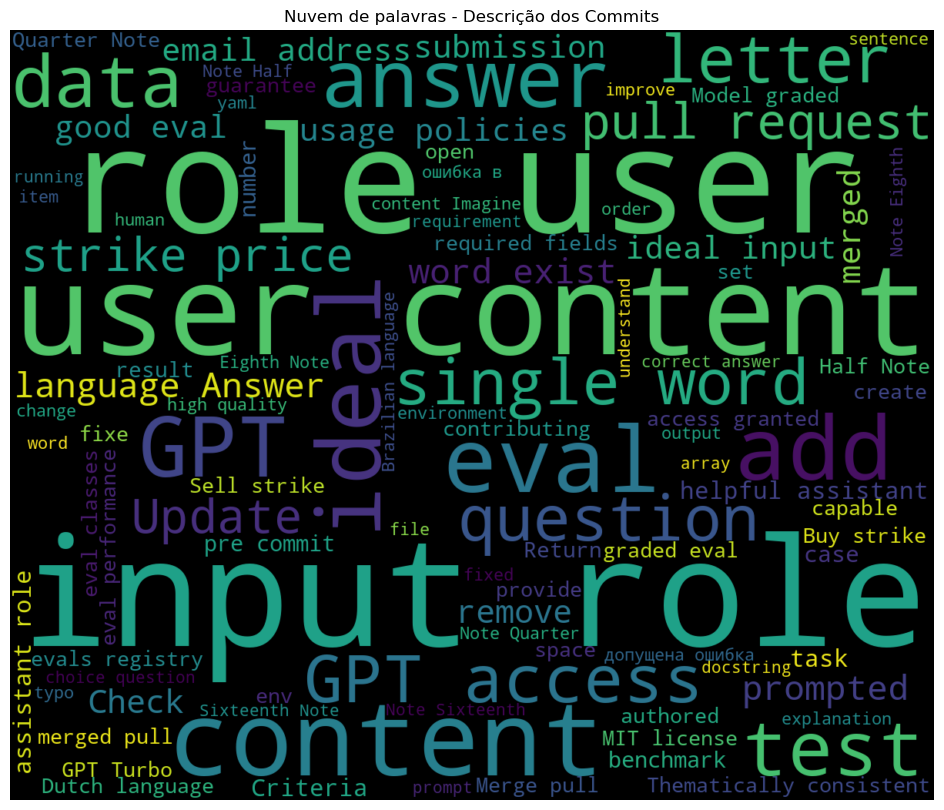

In [266]:
descricao_commit = df_commit['message']

Concatenar = ''

for Loop in descricao_commit:
  Quebra = Loop.split()

  for Palavra in Quebra:
    Concatenar = Concatenar + ' ' + Palavra

# Criando a nuvem
Nuvem_Palavras = WordCloud(
  width= 1200,
  height= 1000,
  max_words=100,
  min_font_size=10,
  
  # Remover palavras
  stopwords=["0o", "0s", "3a", "3b", "3d", "6b", "6o", "a", "a1", "a2", "a3", "a4", "ab", "able", "about", "above", "abst", "ac", "accordance", "according", "accordingly", "across", "act", "actually", "ad", "added", "adj", "ae", "af", "affected", "affecting", "affects", "after", "afterwards", "ag", "again", "against", "ah", "ain", "ain't", "aj", "al", "all", "allow", "allows", "almost", "alone", "along", "already", "also", "although", "always", "am", "among", "amongst", "amoungst", "amount", "an", "and", "announce", "another", "any", "anybody", "anyhow", "anymore", "anyone", "anything", "anyway", "anyways", "anywhere", "ao", "ap", "apart", "apparently", "appear", "appreciate", "appropriate", "approximately", "ar", "are", "aren", "arent", "aren't", "arise", "around", "as", "a's", "aside", "ask", "asking", "associated", "at", "au", "auth", "av", "available", "aw", "away", "awfully", "ax", "ay", "az", "b", "b1", "b2", "b3", "ba", "back", "bc", "bd", "be", "became", "because", "become", "becomes", "becoming", "been", "before", "beforehand", "begin", "beginning", "beginnings", "begins", "behind", "being", "believe", "below", "beside", "besides", "best", "better", "between", "beyond", "bi", "bill", "biol", "bj", "bk", "bl", "bn", "both", "bottom", "bp", "br", "brief", "briefly", "bs", "bt", "bu", "but", "bx", "by", "c", "c1", "c2", "c3", "ca", "call", "came", "can", "cannot", "cant", "can't", "cause", "causes", "cc", "cd", "ce", "certain", "certainly", "cf", "cg", "ch", "changes", "ci", "cit", "cj", "cl", "clearly", "cm", "c'mon", "cn", "co", "com", "come", "comes", "con", "concerning", "consequently", "consider", "considering", "contain", "containing", "contains", "corresponding", "could", "couldn", "couldnt", "couldn't", "course", "cp", "cq", "cr", "cry", "cs", "c's", "ct", "cu", "currently", "cv", "cx", "cy", "cz", "d", "d2", "da", "date", "dc", "dd", "de", "definitely", "describe", "described", "despite", "detail", "df", "di", "did", "didn", "didn't", "different", "dj", "dk", "dl", "do", "does", "doesn", "doesn't", "doing", "don", "done", "don't", "down", "downwards", "dp", "dr", "ds", "dt", "du", "due", "during", "dx", "dy", "e", "e2", "e3", "ea", "each", "ec", "ed", "edu", "ee", "ef", "effect", "eg", "ei", "eight", "eighty", "either", "ej", "el", "eleven", "else", "elsewhere", "em", "empty", "en", "end", "ending", "enough", "entirely", "eo", "ep", "eq", "er", "es", "especially", "est", "et", "et-al", "etc", "eu", "ev", "even", "ever", "every", "everybody", "everyone", "everything", "everywhere", "ex", "exactly", "example", "except", "ey", "f", "f2", "fa", "far", "fc", "few", "ff", "fi", "fifteen", "fifth", "fify", "fill", "find", "fire", "first", "five", "fix", "fj", "fl", "fn", "fo", "followed", "following", "follows", "for", "former", "formerly", "forth", "forty", "found", "four", "fr", "from", "front", "fs", "ft", "fu", "full", "further", "furthermore", "fy", "g", "ga", "gave", "ge", "get", "gets", "getting", "gi", "give", "given", "gives", "giving", "gj", "gl", "go", "goes", "going", "gone", "got", "gotten", "gr", "greetings", "gs", "gy", "h", "h2", "h3", "had", "hadn", "hadn't", "happens", "hardly", "has", "hasn", "hasnt", "hasn't", "have", "haven", "haven't", "having", "he", "hed", "he'd", "he'll", "hello", "help", "hence", "her", "here", "hereafter", "hereby", "herein", "heres", "here's", "hereupon", "hers", "herself", "hes", "he's", "hh", "hi", "hid", "him", "himself", "his", "hither", "hj", "ho", "home", "hopefully", "how", "howbeit", "however", "how's", "hr", "hs", "http", "hu", "hundred", "hy", "i", "i2", "i3", "i4", "i6", "i7", "i8", "ia", "ib", "ibid", "ic", "id", "i'd", "ie", "if", "ig", "ignored", "ih", "ii", "ij", "il", "i'll", "im", "i'm", "immediate", "immediately", "importance", "important", "in", "inasmuch", "inc", "indeed", "index", "indicate", "indicated", "indicates", "information", "inner", "insofar", "instead", "interest", "into", "invention", "inward", "io", "ip", "iq", "ir", "is", "isn", "isn't", "it", "itd", "it'd", "it'll", "its", "it's", "itself", "iv", "i've", "ix", "iy", "iz", "j", "jj", "jr", "js", "jt", "ju", "just", "k", "ke", "keep", "keeps", "kept", "kg", "kj", "km", "know", "known", "knows", "ko", "l", "l2", "la", "largely", "last", "lately", "later", "latter", "latterly", "lb", "lc", "le", "least", "les", "less", "lest", "let", "lets", "let's", "lf", "like", "liked", "likely", "line", "little", "lj", "ll", "ll", "ln", "lo", "look", "looking", "looks", "los", "lr", "ls", "lt", "ltd", "m", "m2", "ma", "made", "mainly", "make", "makes", "many", "may", "maybe", "me", "mean", "means", "meantime", "meanwhile", "merely", "mg", "might", "mightn", "mightn't", "mill", "million", "mine", "miss", "ml", "mn", "mo", "more", "moreover", "most", "mostly", "move", "mr", "mrs", "ms", "mt", "mu", "much", "mug", "must", "mustn", "mustn't", "my", "myself", "n", "n2", "na", "name", "namely", "nay", "nc", "nd", "ne", "near", "nearly", "necessarily", "necessary", "need", "needn", "needn't", "needs", "neither", "never", "nevertheless", "new", "next", "ng", "ni", "nine", "ninety", "nj", "nl", "nn", "no", "nobody", "non", "none", "nonetheless", "noone", "nor", "normally", "nos", "not", "noted", "nothing", "novel", "now", "nowhere", "nr", "ns", "nt", "ny", "o", "oa", "ob", "obtain", "obtained", "obviously", "oc", "od", "of", "off", "often", "og", "oh", "oi", "oj", "ok", "okay", "ol", "old", "om", "omitted", "on", "once", "one", "ones", "only", "onto", "oo", "op", "oq", "or", "ord", "os", "ot", "other", "others", "otherwise", "ou", "ought", "our", "ours", "ourselves", "out", "outside", "over", "overall", "ow", "owing", "own", "ox", "oz", "p", "p1", "p2", "p3", "page", "pagecount", "pages", "par", "part", "particular", "particularly", "pas", "past", "pc", "pd", "pe", "per", "perhaps", "pf", "ph", "pi", "pj", "pk", "pl", "placed", "please", "plus", "pm", "pn", "po", "poorly", "possible", "possibly", "potentially", "pp", "pq", "pr", "predominantly", "present", "presumably", "previously", "primarily", "probably", "promptly", "proud", "provides", "ps", "pt", "pu", "put", "py", "q", "qj", "qu", "que", "quickly", "quite", "qv", "r", "r2", "ra", "ran", "rather", "rc", "rd", "re", "readily", "really", "reasonably", "recent", "recently", "ref", "refs", "regarding", "regardless", "regards", "related", "relatively", "research", "research-articl", "respectively", "resulted", "resulting", "results", "rf", "rh", "ri", "right", "rj", "rl", "rm", "rn", "ro", "rq", "rr", "rs", "rt", "ru", "run", "rv", "ry", "s", "s2", "sa", "said", "same", "saw", "say", "saying", "says", "sc", "sd", "se", "sec", "second", "secondly", "section", "see", "seeing", "seem", "seemed", "seeming", "seems", "seen", "self", "selves", "sensible", "sent", "serious", "seriously", "seven", "several", "sf", "shall", "shan", "shan't", "she", "shed", "she'd", "she'll", "shes", "she's", "should", "shouldn", "shouldn't", "should've", "show", "showed", "shown", "showns", "shows", "si", "side", "significant", "significantly", "similar", "similarly", "since", "sincere", "six", "sixty", "sj", "sl", "slightly", "sm", "sn", "so", "some", "somebody", "somehow", "someone", "somethan", "something", "sometime", "sometimes", "somewhat", "somewhere", "soon", "sorry", "sp", "specifically", "specified", "specify", "specifying", "sq", "sr", "ss", "st", "still", "stop", "strongly", "sub", "substantially", "successfully", "such", "sufficiently", "suggest", "sup", "sure", "sy", "system", "sz", "t", "t1", "t2", "t3", "take", "taken", "taking", "tb", "tc", "td", "te", "tell", "ten", "tends", "tf", "th", "than", "thank", "thanks", "thanx", "that", "that'll", "thats", "that's", "that've", "the", "their", "theirs", "them", "themselves", "then", "thence", "there", "thereafter", "thereby", "thered", "therefore", "therein", "there'll", "thereof", "therere", "theres", "there's", "thereto", "thereupon", "there've", "these", "they", "theyd", "they'd", "they'll", "theyre", "they're", "they've", "thickv", "thin", "think", "third", "this", "thorough", "thoroughly", "those", "thou", "though", "thoughh", "thousand", "three", "throug", "through", "throughout", "thru", "thus", "ti", "til", "tip", "tj", "tl", "tm", "tn", "to", "together", "too", "took", "top", "toward", "towards", "tp", "tq", "tr", "tried", "tries", "truly", "try", "trying", "ts", "t's", "tt", "tv", "twelve", "twenty", "twice", "two", "tx", "u", "u201d", "ue", "ui", "uj", "uk", "um", "un", "under", "unfortunately", "unless", "unlike", "unlikely", "until", "unto", "uo", "up", "upon", "ups", "ur", "us", "use", "used", "useful", "usefully", "usefulness", "uses", "using", "usually", "ut", "v", "va", "value", "various", "vd", "ve", "ve", "very", "via", "viz", "vj", "vo", "vol", "vols", "volumtype", "vq", "vs", "vt", "vu", "w", "wa", "want", "wants", "was", "wasn", "wasnt", "wasn't", "way", "we", "wed", "we'd", "welcome", "well", "we'll", "well-b", "went", "were", "we're", "weren", "werent", "weren't", "we've", "what", "whatever", "what'll", "whats", "what's", "when", "whence", "whenever", "when's", "where", "whereafter", "whereas", "whereby", "wherein", "wheres", "where's", "whereupon", "wherever", "whether", "which", "while", "whim", "whither", "who", "whod", "whoever", "whole", "who'll", "whom", "whomever", "whos", "who's", "whose", "why", "why's", "wi", "widely", "will", "willing", "wish", "with", "within", "without", "wo", "won", "wonder", "wont", "won't", "words", "world", "would", "wouldn", "wouldnt", "wouldn't", "www", "x", "x1", "x2", "x3", "xf", "xi", "xj", "xk", "xl", "xn", "xo", "xs", "xt", "xv", "xx", "y", "y2", "yes", "yet", "yj", "yl", "you", "youd", "you'd", "you'll", "your", "youre", "you're", "yours", "yourself", "yourselves", "you've", "yr", "ys", "yt", "z", "zero", "zi", "zz"]
  ).generate( Concatenar )
 
Figura, Eixo = plt.subplots( figsize=(12, 10) )
plt.title('Nuvem de palavras - Descrição dos Commits')
Eixo.imshow( Nuvem_Palavras, interpolation='bilinear' )
Eixo.set_axis_off()
plt.savefig('Analise_Nuvem_Palavras_Commit.png')

Comentário Commit

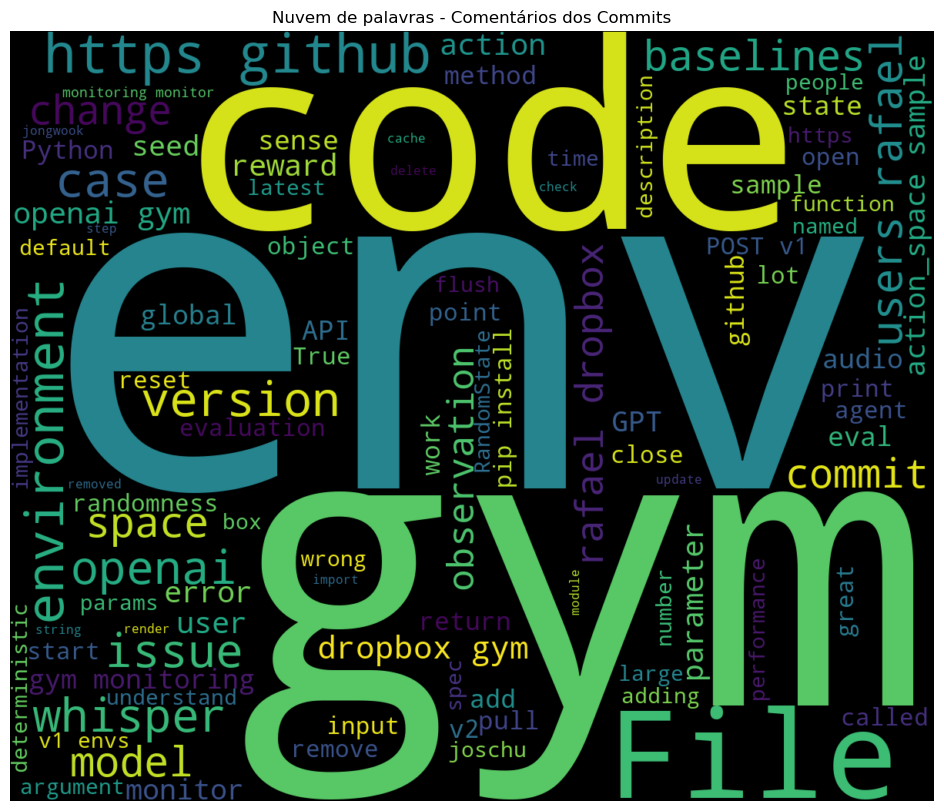

In [778]:
comentario_commit = df_commit_coments['body']

Concatenar = ''

for Loop in comentario_commit:
  Quebra = Loop.split()

  for Palavra in Quebra:
    Concatenar = Concatenar + ' ' + Palavra
    
# Criando a nuvem
Nuvem_Palavras = WordCloud(
  width= 1200,
  height= 1000,
  max_words=100,
  min_font_size=10,
  
  # Remover palavras
  stopwords=["0o", "0s", "3a", "3b", "3d", "6b", "6o", "a", "a1", "a2", "a3", "a4", "ab", "able", "about", "above", "abst", "ac", "accordance", "according", "accordingly", "across", "act", "actually", "ad", "added", "adj", "ae", "af", "affected", "affecting", "affects", "after", "afterwards", "ag", "again", "against", "ah", "ain", "ain't", "aj", "al", "all", "allow", "allows", "almost", "alone", "along", "already", "also", "although", "always", "am", "among", "amongst", "amoungst", "amount", "an", "and", "announce", "another", "any", "anybody", "anyhow", "anymore", "anyone", "anything", "anyway", "anyways", "anywhere", "ao", "ap", "apart", "apparently", "appear", "appreciate", "appropriate", "approximately", "ar", "are", "aren", "arent", "aren't", "arise", "around", "as", "a's", "aside", "ask", "asking", "associated", "at", "au", "auth", "av", "available", "aw", "away", "awfully", "ax", "ay", "az", "b", "b1", "b2", "b3", "ba", "back", "bc", "bd", "be", "became", "because", "become", "becomes", "becoming", "been", "before", "beforehand", "begin", "beginning", "beginnings", "begins", "behind", "being", "believe", "below", "beside", "besides", "best", "better", "between", "beyond", "bi", "bill", "biol", "bj", "bk", "bl", "bn", "both", "bottom", "bp", "br", "brief", "briefly", "bs", "bt", "bu", "but", "bx", "by", "c", "c1", "c2", "c3", "ca", "call", "came", "can", "cannot", "cant", "can't", "cause", "causes", "cc", "cd", "ce", "certain", "certainly", "cf", "cg", "ch", "changes", "ci", "cit", "cj", "cl", "clearly", "cm", "c'mon", "cn", "co", "com", "come", "comes", "con", "concerning", "consequently", "consider", "considering", "contain", "containing", "contains", "corresponding", "could", "couldn", "couldnt", "couldn't", "course", "cp", "cq", "cr", "cry", "cs", "c's", "ct", "cu", "currently", "cv", "cx", "cy", "cz", "d", "d2", "da", "date", "dc", "dd", "de", "definitely", "describe", "described", "despite", "detail", "df", "di", "did", "didn", "didn't", "different", "dj", "dk", "dl", "do", "does", "doesn", "doesn't", "doing", "don", "done", "don't", "down", "downwards", "dp", "dr", "ds", "dt", "du", "due", "during", "dx", "dy", "e", "e2", "e3", "ea", "each", "ec", "ed", "edu", "ee", "ef", "effect", "eg", "ei", "eight", "eighty", "either", "ej", "el", "eleven", "else", "elsewhere", "em", "empty", "en", "end", "ending", "enough", "entirely", "eo", "ep", "eq", "er", "es", "especially", "est", "et", "et-al", "etc", "eu", "ev", "even", "ever", "every", "everybody", "everyone", "everything", "everywhere", "ex", "exactly", "example", "except", "ey", "f", "f2", "fa", "far", "fc", "few", "ff", "fi", "fifteen", "fifth", "fify", "fill", "find", "fire", "first", "five", "fix", "fj", "fl", "fn", "fo", "followed", "following", "follows", "for", "former", "formerly", "forth", "forty", "found", "four", "fr", "from", "front", "fs", "ft", "fu", "full", "further", "furthermore", "fy", "g", "ga", "gave", "ge", "get", "gets", "getting", "gi", "give", "given", "gives", "giving", "gj", "gl", "go", "goes", "going", "gone", "got", "gotten", "gr", "greetings", "gs", "gy", "h", "h2", "h3", "had", "hadn", "hadn't", "happens", "hardly", "has", "hasn", "hasnt", "hasn't", "have", "haven", "haven't", "having", "he", "hed", "he'd", "he'll", "hello", "help", "hence", "her", "here", "hereafter", "hereby", "herein", "heres", "here's", "hereupon", "hers", "herself", "hes", "he's", "hh", "hi", "hid", "him", "himself", "his", "hither", "hj", "ho", "home", "hopefully", "how", "howbeit", "however", "how's", "hr", "hs", "http", "hu", "hundred", "hy", "i", "i2", "i3", "i4", "i6", "i7", "i8", "ia", "ib", "ibid", "ic", "id", "i'd", "ie", "if", "ig", "ignored", "ih", "ii", "ij", "il", "i'll", "im", "i'm", "immediate", "immediately", "importance", "important", "in", "inasmuch", "inc", "indeed", "index", "indicate", "indicated", "indicates", "information", "inner", "insofar", "instead", "interest", "into", "invention", "inward", "io", "ip", "iq", "ir", "is", "isn", "isn't", "it", "itd", "it'd", "it'll", "its", "it's", "itself", "iv", "i've", "ix", "iy", "iz", "j", "jj", "jr", "js", "jt", "ju", "just", "k", "ke", "keep", "keeps", "kept", "kg", "kj", "km", "know", "known", "knows", "ko", "l", "l2", "la", "largely", "last", "lately", "later", "latter", "latterly", "lb", "lc", "le", "least", "les", "less", "lest", "let", "lets", "let's", "lf", "like", "liked", "likely", "line", "little", "lj", "ll", "ll", "ln", "lo", "look", "looking", "looks", "los", "lr", "ls", "lt", "ltd", "m", "m2", "ma", "made", "mainly", "make", "makes", "many", "may", "maybe", "me", "mean", "means", "meantime", "meanwhile", "merely", "mg", "might", "mightn", "mightn't", "mill", "million", "mine", "miss", "ml", "mn", "mo", "more", "moreover", "most", "mostly", "move", "mr", "mrs", "ms", "mt", "mu", "much", "mug", "must", "mustn", "mustn't", "my", "myself", "n", "n2", "na", "name", "namely", "nay", "nc", "nd", "ne", "near", "nearly", "necessarily", "necessary", "need", "needn", "needn't", "needs", "neither", "never", "nevertheless", "new", "next", "ng", "ni", "nine", "ninety", "nj", "nl", "nn", "no", "nobody", "non", "none", "nonetheless", "noone", "nor", "normally", "nos", "not", "noted", "nothing", "novel", "now", "nowhere", "nr", "ns", "nt", "ny", "o", "oa", "ob", "obtain", "obtained", "obviously", "oc", "od", "of", "off", "often", "og", "oh", "oi", "oj", "ok", "okay", "ol", "old", "om", "omitted", "on", "once", "one", "ones", "only", "onto", "oo", "op", "oq", "or", "ord", "os", "ot", "other", "others", "otherwise", "ou", "ought", "our", "ours", "ourselves", "out", "outside", "over", "overall", "ow", "owing", "own", "ox", "oz", "p", "p1", "p2", "p3", "page", "pagecount", "pages", "par", "part", "particular", "particularly", "pas", "past", "pc", "pd", "pe", "per", "perhaps", "pf", "ph", "pi", "pj", "pk", "pl", "placed", "please", "plus", "pm", "pn", "po", "poorly", "possible", "possibly", "potentially", "pp", "pq", "pr", "predominantly", "present", "presumably", "previously", "primarily", "probably", "promptly", "proud", "provides", "ps", "pt", "pu", "put", "py", "q", "qj", "qu", "que", "quickly", "quite", "qv", "r", "r2", "ra", "ran", "rather", "rc", "rd", "re", "readily", "really", "reasonably", "recent", "recently", "ref", "refs", "regarding", "regardless", "regards", "related", "relatively", "research", "research-articl", "respectively", "resulted", "resulting", "results", "rf", "rh", "ri", "right", "rj", "rl", "rm", "rn", "ro", "rq", "rr", "rs", "rt", "ru", "run", "rv", "ry", "s", "s2", "sa", "said", "same", "saw", "say", "saying", "says", "sc", "sd", "se", "sec", "second", "secondly", "section", "see", "seeing", "seem", "seemed", "seeming", "seems", "seen", "self", "selves", "sensible", "sent", "serious", "seriously", "seven", "several", "sf", "shall", "shan", "shan't", "she", "shed", "she'd", "she'll", "shes", "she's", "should", "shouldn", "shouldn't", "should've", "show", "showed", "shown", "showns", "shows", "si", "side", "significant", "significantly", "similar", "similarly", "since", "sincere", "six", "sixty", "sj", "sl", "slightly", "sm", "sn", "so", "some", "somebody", "somehow", "someone", "somethan", "something", "sometime", "sometimes", "somewhat", "somewhere", "soon", "sorry", "sp", "specifically", "specified", "specify", "specifying", "sq", "sr", "ss", "st", "still", "stop", "strongly", "sub", "substantially", "successfully", "such", "sufficiently", "suggest", "sup", "sure", "sy", "system", "sz", "t", "t1", "t2", "t3", "take", "taken", "taking", "tb", "tc", "td", "te", "tell", "ten", "tends", "tf", "th", "than", "thank", "thanks", "thanx", "that", "that'll", "thats", "that's", "that've", "the", "their", "theirs", "them", "themselves", "then", "thence", "there", "thereafter", "thereby", "thered", "therefore", "therein", "there'll", "thereof", "therere", "theres", "there's", "thereto", "thereupon", "there've", "these", "they", "theyd", "they'd", "they'll", "theyre", "they're", "they've", "thickv", "thin", "think", "third", "this", "thorough", "thoroughly", "those", "thou", "though", "thoughh", "thousand", "three", "throug", "through", "throughout", "thru", "thus", "ti", "til", "tip", "tj", "tl", "tm", "tn", "to", "together", "too", "took", "top", "toward", "towards", "tp", "tq", "tr", "tried", "tries", "truly", "try", "trying", "ts", "t's", "tt", "tv", "twelve", "twenty", "twice", "two", "tx", "u", "u201d", "ue", "ui", "uj", "uk", "um", "un", "under", "unfortunately", "unless", "unlike", "unlikely", "until", "unto", "uo", "up", "upon", "ups", "ur", "us", "use", "used", "useful", "usefully", "usefulness", "uses", "using", "usually", "ut", "v", "va", "value", "various", "vd", "ve", "ve", "very", "via", "viz", "vj", "vo", "vol", "vols", "volumtype", "vq", "vs", "vt", "vu", "w", "wa", "want", "wants", "was", "wasn", "wasnt", "wasn't", "way", "we", "wed", "we'd", "welcome", "well", "we'll", "well-b", "went", "were", "we're", "weren", "werent", "weren't", "we've", "what", "whatever", "what'll", "whats", "what's", "when", "whence", "whenever", "when's", "where", "whereafter", "whereas", "whereby", "wherein", "wheres", "where's", "whereupon", "wherever", "whether", "which", "while", "whim", "whither", "who", "whod", "whoever", "whole", "who'll", "whom", "whomever", "whos", "who's", "whose", "why", "why's", "wi", "widely", "will", "willing", "wish", "with", "within", "without", "wo", "won", "wonder", "wont", "won't", "words", "world", "would", "wouldn", "wouldnt", "wouldn't", "www", "x", "x1", "x2", "x3", "xf", "xi", "xj", "xk", "xl", "xn", "xo", "xs", "xt", "xv", "xx", "y", "y2", "yes", "yet", "yj", "yl", "you", "youd", "you'd", "you'll", "your", "youre", "you're", "yours", "yourself", "yourselves", "you've", "yr", "ys", "yt", "z", "zero", "zi", "zz"]
  ).generate( Concatenar )
 
Figura, Eixo = plt.subplots( figsize=(12, 10) )
plt.title('Nuvem de palavras - Comentários dos Commits')
Eixo.imshow( Nuvem_Palavras, interpolation='bilinear' )
Eixo.set_axis_off()
plt.savefig('Analise_Nuvem_Palavras_Commit_Comments.png')

Descrição Issues

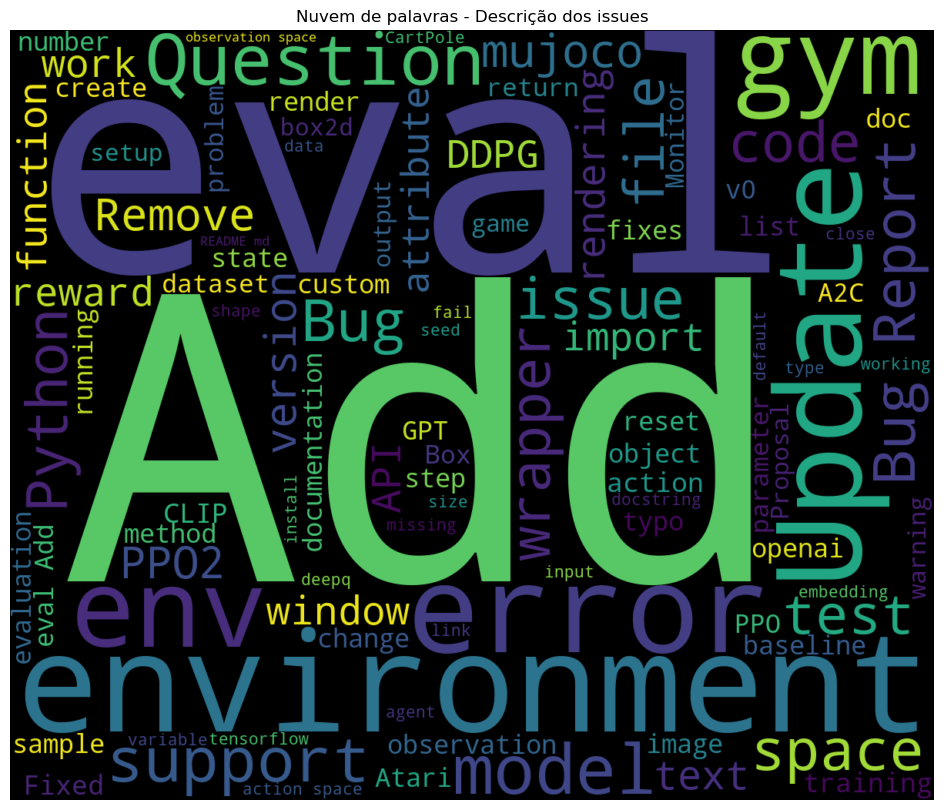

In [268]:
comentario_commit = df_issue['title']

Concatenar = ''

for Loop in comentario_commit:
  Quebra = Loop.split()

  for Palavra in Quebra:
    Concatenar = Concatenar + ' ' + Palavra
    
# Criando a nuvem
Nuvem_Palavras = WordCloud(
  width= 1200,
  height= 1000,
  max_words=100,
  min_font_size=10,
  
  # Remover palavras
  stopwords=["0o", "0s", "3a", "3b", "3d", "6b", "6o", "a", "a1", "a2", "a3", "a4", "ab", "able", "about", "above", "abst", "ac", "accordance", "according", "accordingly", "across", "act", "actually", "ad", "added", "adj", "ae", "af", "affected", "affecting", "affects", "after", "afterwards", "ag", "again", "against", "ah", "ain", "ain't", "aj", "al", "all", "allow", "allows", "almost", "alone", "along", "already", "also", "although", "always", "am", "among", "amongst", "amoungst", "amount", "an", "and", "announce", "another", "any", "anybody", "anyhow", "anymore", "anyone", "anything", "anyway", "anyways", "anywhere", "ao", "ap", "apart", "apparently", "appear", "appreciate", "appropriate", "approximately", "ar", "are", "aren", "arent", "aren't", "arise", "around", "as", "a's", "aside", "ask", "asking", "associated", "at", "au", "auth", "av", "available", "aw", "away", "awfully", "ax", "ay", "az", "b", "b1", "b2", "b3", "ba", "back", "bc", "bd", "be", "became", "because", "become", "becomes", "becoming", "been", "before", "beforehand", "begin", "beginning", "beginnings", "begins", "behind", "being", "believe", "below", "beside", "besides", "best", "better", "between", "beyond", "bi", "bill", "biol", "bj", "bk", "bl", "bn", "both", "bottom", "bp", "br", "brief", "briefly", "bs", "bt", "bu", "but", "bx", "by", "c", "c1", "c2", "c3", "ca", "call", "came", "can", "cannot", "cant", "can't", "cause", "causes", "cc", "cd", "ce", "certain", "certainly", "cf", "cg", "ch", "changes", "ci", "cit", "cj", "cl", "clearly", "cm", "c'mon", "cn", "co", "com", "come", "comes", "con", "concerning", "consequently", "consider", "considering", "contain", "containing", "contains", "corresponding", "could", "couldn", "couldnt", "couldn't", "course", "cp", "cq", "cr", "cry", "cs", "c's", "ct", "cu", "currently", "cv", "cx", "cy", "cz", "d", "d2", "da", "date", "dc", "dd", "de", "definitely", "describe", "described", "despite", "detail", "df", "di", "did", "didn", "didn't", "different", "dj", "dk", "dl", "do", "does", "doesn", "doesn't", "doing", "don", "done", "don't", "down", "downwards", "dp", "dr", "ds", "dt", "du", "due", "during", "dx", "dy", "e", "e2", "e3", "ea", "each", "ec", "ed", "edu", "ee", "ef", "effect", "eg", "ei", "eight", "eighty", "either", "ej", "el", "eleven", "else", "elsewhere", "em", "empty", "en", "end", "ending", "enough", "entirely", "eo", "ep", "eq", "er", "es", "especially", "est", "et", "et-al", "etc", "eu", "ev", "even", "ever", "every", "everybody", "everyone", "everything", "everywhere", "ex", "exactly", "example", "except", "ey", "f", "f2", "fa", "far", "fc", "few", "ff", "fi", "fifteen", "fifth", "fify", "fill", "find", "fire", "first", "five", "fix", "fj", "fl", "fn", "fo", "followed", "following", "follows", "for", "former", "formerly", "forth", "forty", "found", "four", "fr", "from", "front", "fs", "ft", "fu", "full", "further", "furthermore", "fy", "g", "ga", "gave", "ge", "get", "gets", "getting", "gi", "give", "given", "gives", "giving", "gj", "gl", "go", "goes", "going", "gone", "got", "gotten", "gr", "greetings", "gs", "gy", "h", "h2", "h3", "had", "hadn", "hadn't", "happens", "hardly", "has", "hasn", "hasnt", "hasn't", "have", "haven", "haven't", "having", "he", "hed", "he'd", "he'll", "hello", "help", "hence", "her", "here", "hereafter", "hereby", "herein", "heres", "here's", "hereupon", "hers", "herself", "hes", "he's", "hh", "hi", "hid", "him", "himself", "his", "hither", "hj", "ho", "home", "hopefully", "how", "howbeit", "however", "how's", "hr", "hs", "http", "hu", "hundred", "hy", "i", "i2", "i3", "i4", "i6", "i7", "i8", "ia", "ib", "ibid", "ic", "id", "i'd", "ie", "if", "ig", "ignored", "ih", "ii", "ij", "il", "i'll", "im", "i'm", "immediate", "immediately", "importance", "important", "in", "inasmuch", "inc", "indeed", "index", "indicate", "indicated", "indicates", "information", "inner", "insofar", "instead", "interest", "into", "invention", "inward", "io", "ip", "iq", "ir", "is", "isn", "isn't", "it", "itd", "it'd", "it'll", "its", "it's", "itself", "iv", "i've", "ix", "iy", "iz", "j", "jj", "jr", "js", "jt", "ju", "just", "k", "ke", "keep", "keeps", "kept", "kg", "kj", "km", "know", "known", "knows", "ko", "l", "l2", "la", "largely", "last", "lately", "later", "latter", "latterly", "lb", "lc", "le", "least", "les", "less", "lest", "let", "lets", "let's", "lf", "like", "liked", "likely", "line", "little", "lj", "ll", "ll", "ln", "lo", "look", "looking", "looks", "los", "lr", "ls", "lt", "ltd", "m", "m2", "ma", "made", "mainly", "make", "makes", "many", "may", "maybe", "me", "mean", "means", "meantime", "meanwhile", "merely", "mg", "might", "mightn", "mightn't", "mill", "million", "mine", "miss", "ml", "mn", "mo", "more", "moreover", "most", "mostly", "move", "mr", "mrs", "ms", "mt", "mu", "much", "mug", "must", "mustn", "mustn't", "my", "myself", "n", "n2", "na", "name", "namely", "nay", "nc", "nd", "ne", "near", "nearly", "necessarily", "necessary", "need", "needn", "needn't", "needs", "neither", "never", "nevertheless", "new", "next", "ng", "ni", "nine", "ninety", "nj", "nl", "nn", "no", "nobody", "non", "none", "nonetheless", "noone", "nor", "normally", "nos", "not", "noted", "nothing", "novel", "now", "nowhere", "nr", "ns", "nt", "ny", "o", "oa", "ob", "obtain", "obtained", "obviously", "oc", "od", "of", "off", "often", "og", "oh", "oi", "oj", "ok", "okay", "ol", "old", "om", "omitted", "on", "once", "one", "ones", "only", "onto", "oo", "op", "oq", "or", "ord", "os", "ot", "other", "others", "otherwise", "ou", "ought", "our", "ours", "ourselves", "out", "outside", "over", "overall", "ow", "owing", "own", "ox", "oz", "p", "p1", "p2", "p3", "page", "pagecount", "pages", "par", "part", "particular", "particularly", "pas", "past", "pc", "pd", "pe", "per", "perhaps", "pf", "ph", "pi", "pj", "pk", "pl", "placed", "please", "plus", "pm", "pn", "po", "poorly", "possible", "possibly", "potentially", "pp", "pq", "pr", "predominantly", "present", "presumably", "previously", "primarily", "probably", "promptly", "proud", "provides", "ps", "pt", "pu", "put", "py", "q", "qj", "qu", "que", "quickly", "quite", "qv", "r", "r2", "ra", "ran", "rather", "rc", "rd", "re", "readily", "really", "reasonably", "recent", "recently", "ref", "refs", "regarding", "regardless", "regards", "related", "relatively", "research", "research-articl", "respectively", "resulted", "resulting", "results", "rf", "rh", "ri", "right", "rj", "rl", "rm", "rn", "ro", "rq", "rr", "rs", "rt", "ru", "run", "rv", "ry", "s", "s2", "sa", "said", "same", "saw", "say", "saying", "says", "sc", "sd", "se", "sec", "second", "secondly", "section", "see", "seeing", "seem", "seemed", "seeming", "seems", "seen", "self", "selves", "sensible", "sent", "serious", "seriously", "seven", "several", "sf", "shall", "shan", "shan't", "she", "shed", "she'd", "she'll", "shes", "she's", "should", "shouldn", "shouldn't", "should've", "show", "showed", "shown", "showns", "shows", "si", "side", "significant", "significantly", "similar", "similarly", "since", "sincere", "six", "sixty", "sj", "sl", "slightly", "sm", "sn", "so", "some", "somebody", "somehow", "someone", "somethan", "something", "sometime", "sometimes", "somewhat", "somewhere", "soon", "sorry", "sp", "specifically", "specified", "specify", "specifying", "sq", "sr", "ss", "st", "still", "stop", "strongly", "sub", "substantially", "successfully", "such", "sufficiently", "suggest", "sup", "sure", "sy", "system", "sz", "t", "t1", "t2", "t3", "take", "taken", "taking", "tb", "tc", "td", "te", "tell", "ten", "tends", "tf", "th", "than", "thank", "thanks", "thanx", "that", "that'll", "thats", "that's", "that've", "the", "their", "theirs", "them", "themselves", "then", "thence", "there", "thereafter", "thereby", "thered", "therefore", "therein", "there'll", "thereof", "therere", "theres", "there's", "thereto", "thereupon", "there've", "these", "they", "theyd", "they'd", "they'll", "theyre", "they're", "they've", "thickv", "thin", "think", "third", "this", "thorough", "thoroughly", "those", "thou", "though", "thoughh", "thousand", "three", "throug", "through", "throughout", "thru", "thus", "ti", "til", "tip", "tj", "tl", "tm", "tn", "to", "together", "too", "took", "top", "toward", "towards", "tp", "tq", "tr", "tried", "tries", "truly", "try", "trying", "ts", "t's", "tt", "tv", "twelve", "twenty", "twice", "two", "tx", "u", "u201d", "ue", "ui", "uj", "uk", "um", "un", "under", "unfortunately", "unless", "unlike", "unlikely", "until", "unto", "uo", "up", "upon", "ups", "ur", "us", "use", "used", "useful", "usefully", "usefulness", "uses", "using", "usually", "ut", "v", "va", "value", "various", "vd", "ve", "ve", "very", "via", "viz", "vj", "vo", "vol", "vols", "volumtype", "vq", "vs", "vt", "vu", "w", "wa", "want", "wants", "was", "wasn", "wasnt", "wasn't", "way", "we", "wed", "we'd", "welcome", "well", "we'll", "well-b", "went", "were", "we're", "weren", "werent", "weren't", "we've", "what", "whatever", "what'll", "whats", "what's", "when", "whence", "whenever", "when's", "where", "whereafter", "whereas", "whereby", "wherein", "wheres", "where's", "whereupon", "wherever", "whether", "which", "while", "whim", "whither", "who", "whod", "whoever", "whole", "who'll", "whom", "whomever", "whos", "who's", "whose", "why", "why's", "wi", "widely", "will", "willing", "wish", "with", "within", "without", "wo", "won", "wonder", "wont", "won't", "words", "world", "would", "wouldn", "wouldnt", "wouldn't", "www", "x", "x1", "x2", "x3", "xf", "xi", "xj", "xk", "xl", "xn", "xo", "xs", "xt", "xv", "xx", "y", "y2", "yes", "yet", "yj", "yl", "you", "youd", "you'd", "you'll", "your", "youre", "you're", "yours", "yourself", "yourselves", "you've", "yr", "ys", "yt", "z", "zero", "zi", "zz"]
  ).generate( Concatenar )
 
Figura, Eixo = plt.subplots( figsize=(12, 10) )
plt.title('Nuvem de palavras - Descrição dos issues')
Eixo.imshow( Nuvem_Palavras, interpolation='bilinear' )
Eixo.set_axis_off()
plt.savefig('Analise_Nuvem_Palavras_Issue.png')

Comentários Issues

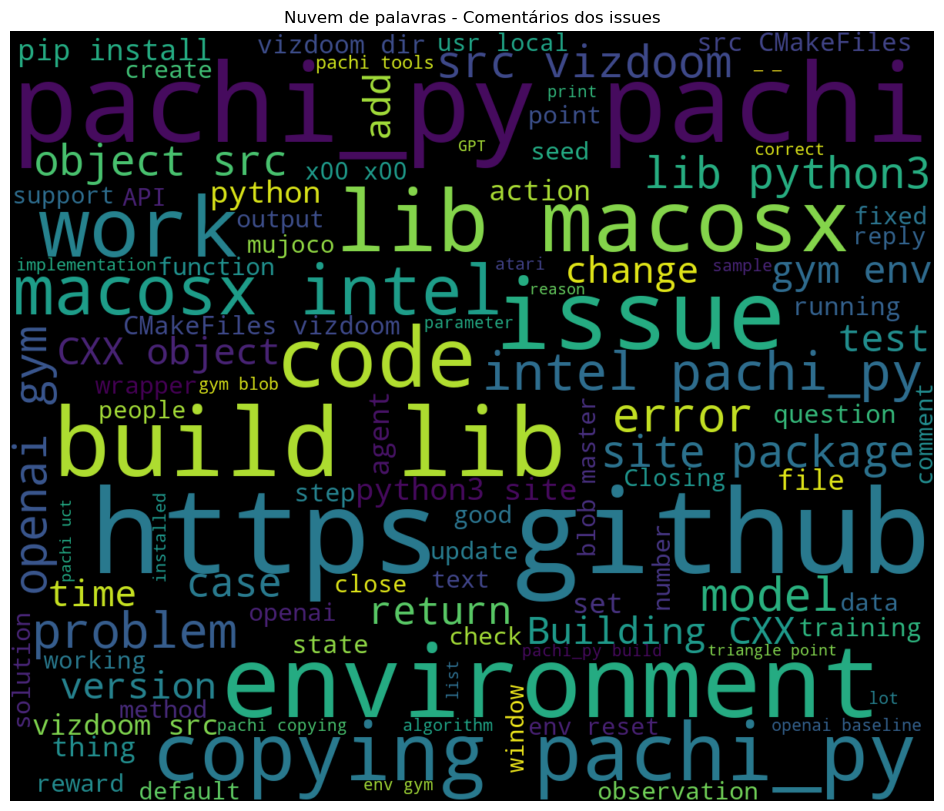

In [269]:
comentario_issue = df_issue_coments['body']

Concatenar = ''

for Loop in comentario_issue:
  Quebra = Loop.split()

  for Palavra in Quebra:
    Concatenar = Concatenar + ' ' + Palavra
    
# Criando a nuvem
Nuvem_Palavras = WordCloud(
  width= 1200,
  height= 1000,
  max_words=100,
  min_font_size=10,
  
  # Remover palavras
  stopwords=["0o", "0s", "3a", "3b", "3d", "6b", "6o", "a", "a1", "a2", "a3", "a4", "ab", "able", "about", "above", "abst", "ac", "accordance", "according", "accordingly", "across", "act", "actually", "ad", "added", "adj", "ae", "af", "affected", "affecting", "affects", "after", "afterwards", "ag", "again", "against", "ah", "ain", "ain't", "aj", "al", "all", "allow", "allows", "almost", "alone", "along", "already", "also", "although", "always", "am", "among", "amongst", "amoungst", "amount", "an", "and", "announce", "another", "any", "anybody", "anyhow", "anymore", "anyone", "anything", "anyway", "anyways", "anywhere", "ao", "ap", "apart", "apparently", "appear", "appreciate", "appropriate", "approximately", "ar", "are", "aren", "arent", "aren't", "arise", "around", "as", "a's", "aside", "ask", "asking", "associated", "at", "au", "auth", "av", "available", "aw", "away", "awfully", "ax", "ay", "az", "b", "b1", "b2", "b3", "ba", "back", "bc", "bd", "be", "became", "because", "become", "becomes", "becoming", "been", "before", "beforehand", "begin", "beginning", "beginnings", "begins", "behind", "being", "believe", "below", "beside", "besides", "best", "better", "between", "beyond", "bi", "bill", "biol", "bj", "bk", "bl", "bn", "both", "bottom", "bp", "br", "brief", "briefly", "bs", "bt", "bu", "but", "bx", "by", "c", "c1", "c2", "c3", "ca", "call", "came", "can", "cannot", "cant", "can't", "cause", "causes", "cc", "cd", "ce", "certain", "certainly", "cf", "cg", "ch", "changes", "ci", "cit", "cj", "cl", "clearly", "cm", "c'mon", "cn", "co", "com", "come", "comes", "con", "concerning", "consequently", "consider", "considering", "contain", "containing", "contains", "corresponding", "could", "couldn", "couldnt", "couldn't", "course", "cp", "cq", "cr", "cry", "cs", "c's", "ct", "cu", "currently", "cv", "cx", "cy", "cz", "d", "d2", "da", "date", "dc", "dd", "de", "definitely", "describe", "described", "despite", "detail", "df", "di", "did", "didn", "didn't", "different", "dj", "dk", "dl", "do", "does", "doesn", "doesn't", "doing", "don", "done", "don't", "down", "downwards", "dp", "dr", "ds", "dt", "du", "due", "during", "dx", "dy", "e", "e2", "e3", "ea", "each", "ec", "ed", "edu", "ee", "ef", "effect", "eg", "ei", "eight", "eighty", "either", "ej", "el", "eleven", "else", "elsewhere", "em", "empty", "en", "end", "ending", "enough", "entirely", "eo", "ep", "eq", "er", "es", "especially", "est", "et", "et-al", "etc", "eu", "ev", "even", "ever", "every", "everybody", "everyone", "everything", "everywhere", "ex", "exactly", "example", "except", "ey", "f", "f2", "fa", "far", "fc", "few", "ff", "fi", "fifteen", "fifth", "fify", "fill", "find", "fire", "first", "five", "fix", "fj", "fl", "fn", "fo", "followed", "following", "follows", "for", "former", "formerly", "forth", "forty", "found", "four", "fr", "from", "front", "fs", "ft", "fu", "full", "further", "furthermore", "fy", "g", "ga", "gave", "ge", "get", "gets", "getting", "gi", "give", "given", "gives", "giving", "gj", "gl", "go", "goes", "going", "gone", "got", "gotten", "gr", "greetings", "gs", "gy", "h", "h2", "h3", "had", "hadn", "hadn't", "happens", "hardly", "has", "hasn", "hasnt", "hasn't", "have", "haven", "haven't", "having", "he", "hed", "he'd", "he'll", "hello", "help", "hence", "her", "here", "hereafter", "hereby", "herein", "heres", "here's", "hereupon", "hers", "herself", "hes", "he's", "hh", "hi", "hid", "him", "himself", "his", "hither", "hj", "ho", "home", "hopefully", "how", "howbeit", "however", "how's", "hr", "hs", "http", "hu", "hundred", "hy", "i", "i2", "i3", "i4", "i6", "i7", "i8", "ia", "ib", "ibid", "ic", "id", "i'd", "ie", "if", "ig", "ignored", "ih", "ii", "ij", "il", "i'll", "im", "i'm", "immediate", "immediately", "importance", "important", "in", "inasmuch", "inc", "indeed", "index", "indicate", "indicated", "indicates", "information", "inner", "insofar", "instead", "interest", "into", "invention", "inward", "io", "ip", "iq", "ir", "is", "isn", "isn't", "it", "itd", "it'd", "it'll", "its", "it's", "itself", "iv", "i've", "ix", "iy", "iz", "j", "jj", "jr", "js", "jt", "ju", "just", "k", "ke", "keep", "keeps", "kept", "kg", "kj", "km", "know", "known", "knows", "ko", "l", "l2", "la", "largely", "last", "lately", "later", "latter", "latterly", "lb", "lc", "le", "least", "les", "less", "lest", "let", "lets", "let's", "lf", "like", "liked", "likely", "line", "little", "lj", "ll", "ll", "ln", "lo", "look", "looking", "looks", "los", "lr", "ls", "lt", "ltd", "m", "m2", "ma", "made", "mainly", "make", "makes", "many", "may", "maybe", "me", "mean", "means", "meantime", "meanwhile", "merely", "mg", "might", "mightn", "mightn't", "mill", "million", "mine", "miss", "ml", "mn", "mo", "more", "moreover", "most", "mostly", "move", "mr", "mrs", "ms", "mt", "mu", "much", "mug", "must", "mustn", "mustn't", "my", "myself", "n", "n2", "na", "name", "namely", "nay", "nc", "nd", "ne", "near", "nearly", "necessarily", "necessary", "need", "needn", "needn't", "needs", "neither", "never", "nevertheless", "new", "next", "ng", "ni", "nine", "ninety", "nj", "nl", "nn", "no", "nobody", "non", "none", "nonetheless", "noone", "nor", "normally", "nos", "not", "noted", "nothing", "novel", "now", "nowhere", "nr", "ns", "nt", "ny", "o", "oa", "ob", "obtain", "obtained", "obviously", "oc", "od", "of", "off", "often", "og", "oh", "oi", "oj", "ok", "okay", "ol", "old", "om", "omitted", "on", "once", "one", "ones", "only", "onto", "oo", "op", "oq", "or", "ord", "os", "ot", "other", "others", "otherwise", "ou", "ought", "our", "ours", "ourselves", "out", "outside", "over", "overall", "ow", "owing", "own", "ox", "oz", "p", "p1", "p2", "p3", "page", "pagecount", "pages", "par", "part", "particular", "particularly", "pas", "past", "pc", "pd", "pe", "per", "perhaps", "pf", "ph", "pi", "pj", "pk", "pl", "placed", "please", "plus", "pm", "pn", "po", "poorly", "possible", "possibly", "potentially", "pp", "pq", "pr", "predominantly", "present", "presumably", "previously", "primarily", "probably", "promptly", "proud", "provides", "ps", "pt", "pu", "put", "py", "q", "qj", "qu", "que", "quickly", "quite", "qv", "r", "r2", "ra", "ran", "rather", "rc", "rd", "re", "readily", "really", "reasonably", "recent", "recently", "ref", "refs", "regarding", "regardless", "regards", "related", "relatively", "research", "research-articl", "respectively", "resulted", "resulting", "results", "rf", "rh", "ri", "right", "rj", "rl", "rm", "rn", "ro", "rq", "rr", "rs", "rt", "ru", "run", "rv", "ry", "s", "s2", "sa", "said", "same", "saw", "say", "saying", "says", "sc", "sd", "se", "sec", "second", "secondly", "section", "see", "seeing", "seem", "seemed", "seeming", "seems", "seen", "self", "selves", "sensible", "sent", "serious", "seriously", "seven", "several", "sf", "shall", "shan", "shan't", "she", "shed", "she'd", "she'll", "shes", "she's", "should", "shouldn", "shouldn't", "should've", "show", "showed", "shown", "showns", "shows", "si", "side", "significant", "significantly", "similar", "similarly", "since", "sincere", "six", "sixty", "sj", "sl", "slightly", "sm", "sn", "so", "some", "somebody", "somehow", "someone", "somethan", "something", "sometime", "sometimes", "somewhat", "somewhere", "soon", "sorry", "sp", "specifically", "specified", "specify", "specifying", "sq", "sr", "ss", "st", "still", "stop", "strongly", "sub", "substantially", "successfully", "such", "sufficiently", "suggest", "sup", "sure", "sy", "system", "sz", "t", "t1", "t2", "t3", "take", "taken", "taking", "tb", "tc", "td", "te", "tell", "ten", "tends", "tf", "th", "than", "thank", "thanks", "thanx", "that", "that'll", "thats", "that's", "that've", "the", "their", "theirs", "them", "themselves", "then", "thence", "there", "thereafter", "thereby", "thered", "therefore", "therein", "there'll", "thereof", "therere", "theres", "there's", "thereto", "thereupon", "there've", "these", "they", "theyd", "they'd", "they'll", "theyre", "they're", "they've", "thickv", "thin", "think", "third", "this", "thorough", "thoroughly", "those", "thou", "though", "thoughh", "thousand", "three", "throug", "through", "throughout", "thru", "thus", "ti", "til", "tip", "tj", "tl", "tm", "tn", "to", "together", "too", "took", "top", "toward", "towards", "tp", "tq", "tr", "tried", "tries", "truly", "try", "trying", "ts", "t's", "tt", "tv", "twelve", "twenty", "twice", "two", "tx", "u", "u201d", "ue", "ui", "uj", "uk", "um", "un", "under", "unfortunately", "unless", "unlike", "unlikely", "until", "unto", "uo", "up", "upon", "ups", "ur", "us", "use", "used", "useful", "usefully", "usefulness", "uses", "using", "usually", "ut", "v", "va", "value", "various", "vd", "ve", "ve", "very", "via", "viz", "vj", "vo", "vol", "vols", "volumtype", "vq", "vs", "vt", "vu", "w", "wa", "want", "wants", "was", "wasn", "wasnt", "wasn't", "way", "we", "wed", "we'd", "welcome", "well", "we'll", "well-b", "went", "were", "we're", "weren", "werent", "weren't", "we've", "what", "whatever", "what'll", "whats", "what's", "when", "whence", "whenever", "when's", "where", "whereafter", "whereas", "whereby", "wherein", "wheres", "where's", "whereupon", "wherever", "whether", "which", "while", "whim", "whither", "who", "whod", "whoever", "whole", "who'll", "whom", "whomever", "whos", "who's", "whose", "why", "why's", "wi", "widely", "will", "willing", "wish", "with", "within", "without", "wo", "won", "wonder", "wont", "won't", "words", "world", "would", "wouldn", "wouldnt", "wouldn't", "www", "x", "x1", "x2", "x3", "xf", "xi", "xj", "xk", "xl", "xn", "xo", "xs", "xt", "xv", "xx", "y", "y2", "yes", "yet", "yj", "yl", "you", "youd", "you'd", "you'll", "your", "youre", "you're", "yours", "yourself", "yourselves", "you've", "yr", "ys", "yt", "z", "zero", "zi", "zz"]
  ).generate( Concatenar )
 
Figura, Eixo = plt.subplots( figsize=(12, 10) )
plt.title('Nuvem de palavras - Comentários dos issues')
Eixo.imshow( Nuvem_Palavras, interpolation='bilinear' )
Eixo.set_axis_off()
plt.savefig('Analise_Nuvem_Palavras_Issue_Comentario.png')